In [1]:
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os

## Constants

In [2]:
LOGDIR = '../trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

## Utility code

In [3]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [4]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [5]:
class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

In [6]:
def get_bucket_from_num_gpus(num_gpus):
    """Maps GPU count to a bucket for plotting purposes."""
    if num_gpus is None:
        return None
    if num_gpus == 1:
        return 0
    elif num_gpus >= 2 and num_gpus <= 4:
        return 1
    elif num_gpus >= 5 and num_gpus <= 8:
        return 2
    elif num_gpus > 8:
        return 3
    else:
        return None
    
def get_plot_config_from_bucket(bucket):
    """Returns plotting configuration information."""
    if bucket == 0:
        return ('1', 'green', '-')
    elif bucket == 1:
        return ('2-4', 'blue', '-.')
    elif bucket == 2:
        return ('5-8', 'red', '--')
    elif bucket == 3:
        return ('>8', 'purple', ':')

## Load the cluster log

In [7]:
import psutil

B_2_MB = 1024 * 1024
B_2_GB = B_2_MB * 1024
jobs = None
cluster_job_log = None

p = psutil.Process(os.getpid())
print("{}({}) occupy {:.2f} MB of memory".format(p.name(), p.pid, p.memory_info().rss / B_2_MB))

cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [Job(**job) for job in cluster_job_log]

print("After load, {}({}) occupy {:.2f} MB of memory".format(p.name(), p.pid, p.memory_info().rss / B_2_MB))


python3(17687) occupy 73.77 MB of memory
After load, python3(17687) occupy 417.49 MB of memory


# Job Runtimes (Figure 2)

In [8]:
run_times = {}
for job in jobs:
    num_gpus = job.num_gpus
    bucket = get_bucket_from_num_gpus(num_gpus)
    if bucket is None:
        continue
    if bucket not in run_times:
        run_times[bucket] = []
    run_time = job.run_time
    if run_time is not None:
        run_times[bucket].append(run_time)

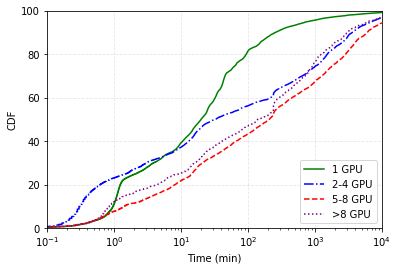

In [9]:
buckets = sorted([bucket for bucket in run_times])
for bucket in buckets:
    num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
    x, y = get_cdf(run_times[bucket])
    plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim(10 ** -1, 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

# Queueing Delay (Figure 3)

In [10]:
queueing_delays = {}
for job in jobs:
    vc = job.vc
    if vc not in queueing_delays:
        queueing_delays[vc] = {}
    bucket = get_bucket_from_num_gpus(job.num_gpus)
    if bucket is None:
        continue
    if bucket not in queueing_delays[vc]:
        queueing_delays[vc][bucket] = []
    # NOTE: Each period between the job being placed on the queue
    # and being scheduled on a machine is recorded as an individual
    # queueing delay.
    queueing_delay = 0.0
    queue_time = job.submitted_time
    for attempt in job.attempts:
        start_time = attempt['start_time']
        if queue_time is not None and start_time is not None:
            queueing_delay = timedelta_to_minutes(start_time - queue_time)
            queue_time = attempt['end_time']
        queueing_delays[vc][bucket].append(queueing_delay)
for vc in queueing_delays:
    for bucket in queueing_delays[vc]:
        queueing_delays[vc][bucket] = filter(None, queueing_delays[vc][bucket])

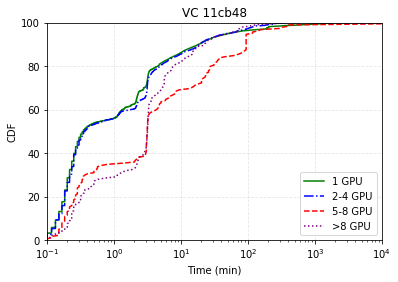

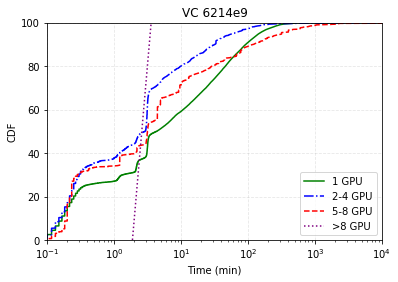

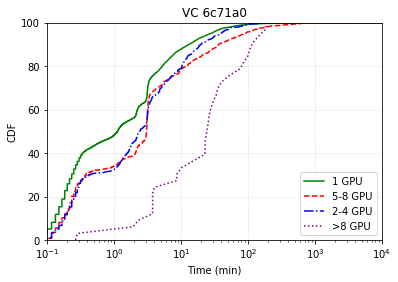

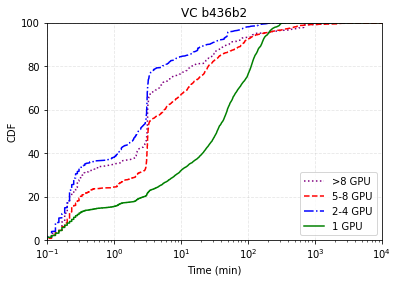

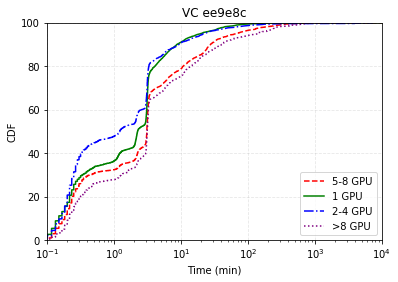

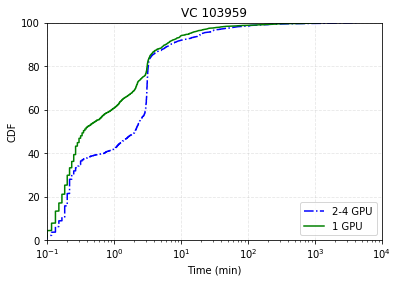

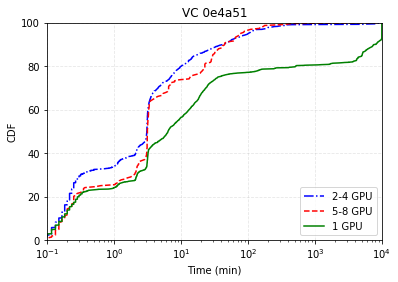

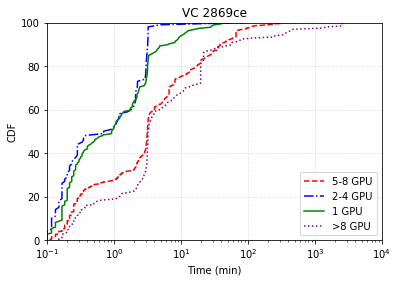

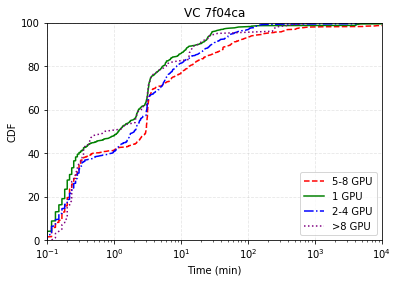

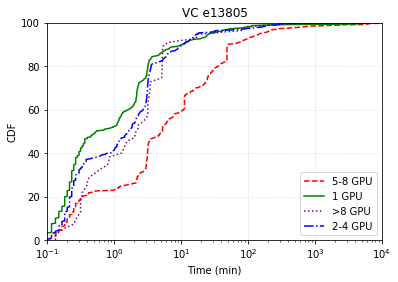

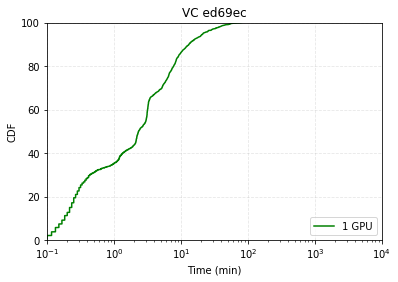

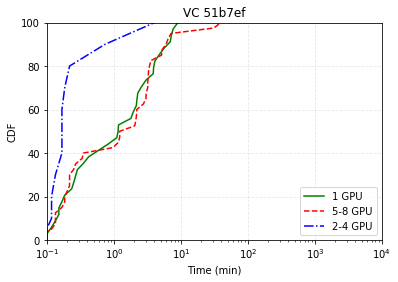

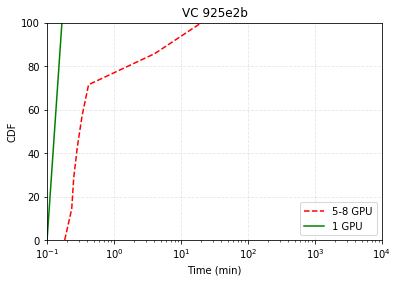

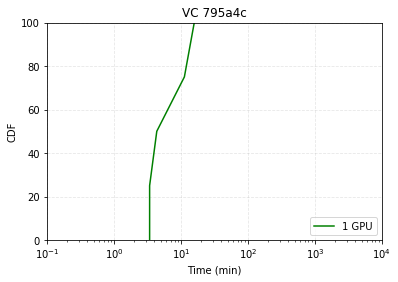

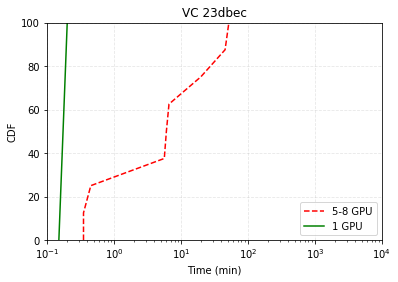

In [11]:
vcs = queueing_delays.keys()
for i, vc in enumerate(vcs):
    for bucket in queueing_delays[vc]:
        num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
        x, y = get_cdf(queueing_delays[vc][bucket])
        plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
    plt.title('VC %s' % (vc))
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.ylim(0, 100)
    plt.xlim(10 ** -1, 10 ** 4)
    plt.xlabel('Time (min)')
    plt.ylabel('CDF')
    plt.grid(alpha=.3, linestyle='--')
    if i < len(vcs) - 1:
        plt.figure()
plt.show()

# Locality Constraints (Figure 4)

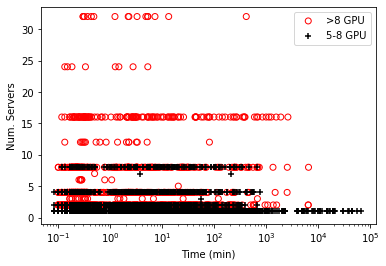

In [12]:
data = {}
for i, job in enumerate(jobs):
    if len(job.attempts) == 0:
        continue
    num_gpus = job.num_gpus
    if num_gpus < 5:
        continue
    bucket = get_bucket_from_num_gpus(num_gpus)
    if bucket not in data:
        data[bucket] = {
            'x': [],
            'y': []
        }
    queueing_delay = job.queueing_delay
    num_servers = len(job.attempts[0]['detail'])
    data[bucket]['x'].append(queueing_delay)
    data[bucket]['y'].append(num_servers)
for bucket in data:
    num_gpus, _, _ = get_plot_config_from_bucket(bucket)
    if bucket == 2:
        marker = '+'
        facecolors = 'black'
        edgecolors = 'none'
    else:
        marker = 'o'
        facecolors = 'none'
        edgecolors = 'red'
    plt.scatter(data[bucket]['x'], data[bucket]['y'], label='%s GPU' % (num_gpus),
                marker=marker, facecolors=facecolors, edgecolors=edgecolors)
    plt.legend()
plt.xscale('log')
plt.xlabel('Time (min)')
plt.ylabel('Num. Servers')
plt.show()

# GPU Utilization (Figures 5, 6)

In [9]:
import shelve

src_file = 'cluster_gpu_util'
db_file = 'cluster_gpu_util.shelve'

gpu_util_path = os.path.join(LOGDIR, src_file)

gpu_util = shelve.open(db_file, writeback=True)

with open(gpu_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        time = row[0][:-4] # Remove the timezone
        machineId = row[1]
        if machineId not in gpu_util:
            gpu_util[machineId] = {}
        gpu_util[machineId][time] = row[2:-1] # Ignore extra empty string at the end
        
        if i % 1000000 == 0:
        
            p = psutil.Process(os.getpid())
            rss = p.memory_info().rss / B_2_GB
            print("{}({}) occupy {:.2f} GB of memory".format(p.name(), p.pid, rss))
            if rss > 14:
                print("flushing db to disk")
                gpu_util.sync()
    gpu_util.sync()
    print("all data in {} written to database {}".format(src_file, db_file))

python3(14579) occupy 0.52 GB of memory
python3(14579) occupy 1.14 GB of memory
python3(14579) occupy 1.56 GB of memory
python3(14579) occupy 1.89 GB of memory
python3(14579) occupy 2.53 GB of memory
python3(14579) occupy 2.86 GB of memory
python3(14579) occupy 3.64 GB of memory
python3(14579) occupy 4.32 GB of memory
python3(14579) occupy 5.07 GB of memory
python3(14579) occupy 5.76 GB of memory
python3(14579) occupy 6.31 GB of memory
python3(14579) occupy 6.70 GB of memory
python3(14579) occupy 7.00 GB of memory
python3(14579) occupy 7.60 GB of memory
python3(14579) occupy 8.13 GB of memory
python3(14579) occupy 8.59 GB of memory
python3(14579) occupy 9.24 GB of memory
python3(14579) occupy 9.55 GB of memory
python3(14579) occupy 10.20 GB of memory
python3(14579) occupy 10.90 GB of memory
python3(14579) occupy 11.48 GB of memory
python3(14579) occupy 11.81 GB of memory
python3(14579) occupy 12.54 GB of memory
flushing db to disk
python3(14579) occupy 3.64 GB of memory
python3(14579) 

In [8]:
import shelve

src_file = 'cluster_gpu_util'
db_file = 'cluster_gpu_util.shelve'

gpu_util_path = os.path.join(LOGDIR, src_file)

gpu_util = shelve.open(db_file, writeback=True)

In [10]:
def get_utilization_data(db_file, jobs, only_large_jobs=False, only_dedicated_servers=False):
    """Aggregates GPU utilization data for a set of jobs.
    
       Args:
           jobs: A list of Jobs.
           only_large_jobs: If True, only considers jobs of size 8 or 16 GPUs.
                            Otherwise, considers jobs of size 1, 4, 8, or 16 GPUs.       
           only_dedicated_servers: If True, only considers jobs that use all GPUs
                                   available on a server(s).
       
       Returns:
           A dict indexed by 1) job completion status, 2) number of GPUs requested
           by the job, and 3) timestamp. The value of each nested dict is a list of
           percentages indicating the utilization of each individual GPU on the
           servers used by the job at the particular time requested.
    """
    
    data = shelve.open(db_file, writeback=True)
    
    job_size = len(jobs)
    
    for i, job in enumerate(jobs):
        num_gpus = job.num_gpus
        if (len(job.attempts) == 0 or
            (num_gpus != 1 and num_gpus != 4 and num_gpus != 8 and num_gpus != 16)):
            continue
        if only_large_jobs and num_gpus < 8:
            continue
        status = job.status
        if status not in data:
            data[status] = {}
        if num_gpus not in data[status]:
            data[status][num_gpus] = []
        for attempt in job.attempts:
            if only_dedicated_servers and len(attempt['detail']) > (num_gpus / 8):
                continue
            current_time = attempt['start_time']
            if current_time is None or attempt['end_time'] is None:
                continue
            current_minute = round_to_nearest_minute(current_time)
            while current_minute < attempt['end_time']:
                current_minute_str = str(current_minute)
                for detail in attempt['detail']:
                    machineId = detail['ip']

                    if current_minute_str in gpu_util[machineId]:
                        for gpu_id in detail['gpus']:
                            gpu_num = int(gpu_id[3:]) # Remove the 'gpu' prefix
                            try:
                                u = gpu_util[machineId][current_minute_str][gpu_num]
                                if u != 'NA':
                                    data[status][num_gpus].append(float(u))
                            except Exception as e:
                                print(gpu_util[machineId][current_minute_str])
                                print(gpu_num)
                                raise ValueError(e)
                current_minute = add_minute(current_minute)
                
        if i % 100 == 0:

            p = psutil.Process(os.getpid())
            rss = p.memory_info().rss / B_2_GB
            print("{}/{}, {}({}) occupy {:.2f} GB of memory".format(i, job_size, p.name(), p.pid, rss))
            if rss > 30:
                print("flushing db to disk")
                data.sync()
                gpu_util.sync()
                rss = p.memory_info().rss / B_2_GB
                print("after flush, {}({}) occupy {:.2f} GB of memory".format(p.name(), p.pid, rss))

    data.sync()
    gpu_util.sync()
    print("all data aggregating GPU utilization data for a set of jobs written to database {}"
          .format(db_file))
    return data
            

In [11]:
db_file = 'get_utilization_data.shelve'
data = get_utilization_data(db_file, jobs)

0/117325, python3(17687) occupy 0.45 GB of memory
100/117325, python3(17687) occupy 4.08 GB of memory
200/117325, python3(17687) occupy 6.40 GB of memory
300/117325, python3(17687) occupy 8.64 GB of memory
400/117325, python3(17687) occupy 8.99 GB of memory
500/117325, python3(17687) occupy 9.14 GB of memory
600/117325, python3(17687) occupy 9.73 GB of memory
700/117325, python3(17687) occupy 9.88 GB of memory
800/117325, python3(17687) occupy 9.90 GB of memory
900/117325, python3(17687) occupy 10.04 GB of memory
1000/117325, python3(17687) occupy 10.04 GB of memory
1100/117325, python3(17687) occupy 10.14 GB of memory
1200/117325, python3(17687) occupy 10.54 GB of memory
1300/117325, python3(17687) occupy 10.73 GB of memory
1400/117325, python3(17687) occupy 10.73 GB of memory
1500/117325, python3(17687) occupy 10.73 GB of memory
1600/117325, python3(17687) occupy 10.83 GB of memory
1700/117325, python3(17687) occupy 11.04 GB of memory
1800/117325, python3(17687) occupy 11.12 GB of me

15600/117325, python3(17687) occupy 24.31 GB of memory
15700/117325, python3(17687) occupy 24.31 GB of memory
15800/117325, python3(17687) occupy 24.31 GB of memory
15900/117325, python3(17687) occupy 24.34 GB of memory
16000/117325, python3(17687) occupy 24.37 GB of memory
16100/117325, python3(17687) occupy 24.37 GB of memory
16200/117325, python3(17687) occupy 24.41 GB of memory
16300/117325, python3(17687) occupy 24.44 GB of memory
16400/117325, python3(17687) occupy 24.46 GB of memory
16600/117325, python3(17687) occupy 24.46 GB of memory
16700/117325, python3(17687) occupy 24.47 GB of memory
16800/117325, python3(17687) occupy 24.47 GB of memory
16900/117325, python3(17687) occupy 24.47 GB of memory
17000/117325, python3(17687) occupy 24.47 GB of memory
17100/117325, python3(17687) occupy 24.47 GB of memory
17300/117325, python3(17687) occupy 24.49 GB of memory
17400/117325, python3(17687) occupy 24.49 GB of memory
17500/117325, python3(17687) occupy 24.49 GB of memory
17600/1173

31400/117325, python3(17687) occupy 26.05 GB of memory
31600/117325, python3(17687) occupy 26.06 GB of memory
31700/117325, python3(17687) occupy 26.08 GB of memory
31800/117325, python3(17687) occupy 26.10 GB of memory
31900/117325, python3(17687) occupy 26.14 GB of memory
32000/117325, python3(17687) occupy 26.15 GB of memory
32100/117325, python3(17687) occupy 26.18 GB of memory
32200/117325, python3(17687) occupy 26.21 GB of memory
32300/117325, python3(17687) occupy 26.22 GB of memory
32400/117325, python3(17687) occupy 26.22 GB of memory
32500/117325, python3(17687) occupy 26.27 GB of memory
32600/117325, python3(17687) occupy 26.28 GB of memory
32700/117325, python3(17687) occupy 26.28 GB of memory
32800/117325, python3(17687) occupy 26.29 GB of memory
32900/117325, python3(17687) occupy 26.29 GB of memory
33000/117325, python3(17687) occupy 26.30 GB of memory
33100/117325, python3(17687) occupy 26.30 GB of memory
33200/117325, python3(17687) occupy 26.30 GB of memory
33400/1173

48200/117325, python3(17687) occupy 27.22 GB of memory
48300/117325, python3(17687) occupy 27.22 GB of memory
48400/117325, python3(17687) occupy 27.22 GB of memory
48500/117325, python3(17687) occupy 27.22 GB of memory
48600/117325, python3(17687) occupy 27.22 GB of memory
48700/117325, python3(17687) occupy 27.22 GB of memory
48800/117325, python3(17687) occupy 27.22 GB of memory
48900/117325, python3(17687) occupy 27.22 GB of memory
49000/117325, python3(17687) occupy 27.22 GB of memory
49100/117325, python3(17687) occupy 27.22 GB of memory
49200/117325, python3(17687) occupy 27.22 GB of memory
49300/117325, python3(17687) occupy 27.22 GB of memory
49500/117325, python3(17687) occupy 27.22 GB of memory
49600/117325, python3(17687) occupy 27.22 GB of memory
49700/117325, python3(17687) occupy 27.22 GB of memory
49800/117325, python3(17687) occupy 27.22 GB of memory
49900/117325, python3(17687) occupy 27.22 GB of memory
50000/117325, python3(17687) occupy 27.22 GB of memory
50100/1173

64300/117325, python3(17687) occupy 27.71 GB of memory
64400/117325, python3(17687) occupy 27.71 GB of memory
64500/117325, python3(17687) occupy 27.71 GB of memory
64600/117325, python3(17687) occupy 27.71 GB of memory
64700/117325, python3(17687) occupy 27.72 GB of memory
64800/117325, python3(17687) occupy 27.72 GB of memory
65000/117325, python3(17687) occupy 27.72 GB of memory
65200/117325, python3(17687) occupy 27.74 GB of memory
65300/117325, python3(17687) occupy 27.74 GB of memory
65400/117325, python3(17687) occupy 27.74 GB of memory
65500/117325, python3(17687) occupy 27.74 GB of memory
65600/117325, python3(17687) occupy 27.74 GB of memory
65700/117325, python3(17687) occupy 27.74 GB of memory
65800/117325, python3(17687) occupy 27.74 GB of memory
65900/117325, python3(17687) occupy 27.74 GB of memory
66000/117325, python3(17687) occupy 27.74 GB of memory
66100/117325, python3(17687) occupy 27.75 GB of memory
66200/117325, python3(17687) occupy 27.75 GB of memory
66300/1173

80400/117325, python3(17687) occupy 28.29 GB of memory
80500/117325, python3(17687) occupy 28.32 GB of memory
80600/117325, python3(17687) occupy 28.32 GB of memory
80700/117325, python3(17687) occupy 28.33 GB of memory
80900/117325, python3(17687) occupy 28.33 GB of memory
81000/117325, python3(17687) occupy 28.33 GB of memory
81100/117325, python3(17687) occupy 28.33 GB of memory
81200/117325, python3(17687) occupy 28.33 GB of memory
81300/117325, python3(17687) occupy 28.33 GB of memory
81400/117325, python3(17687) occupy 28.33 GB of memory
81500/117325, python3(17687) occupy 28.34 GB of memory
81600/117325, python3(17687) occupy 28.41 GB of memory
81700/117325, python3(17687) occupy 28.66 GB of memory
81800/117325, python3(17687) occupy 28.81 GB of memory
82000/117325, python3(17687) occupy 28.87 GB of memory
82100/117325, python3(17687) occupy 28.87 GB of memory
82200/117325, python3(17687) occupy 28.88 GB of memory
82300/117325, python3(17687) occupy 28.88 GB of memory
82400/1173

98700/117325, python3(17687) occupy 29.56 GB of memory
98800/117325, python3(17687) occupy 29.57 GB of memory
98900/117325, python3(17687) occupy 29.58 GB of memory
99000/117325, python3(17687) occupy 29.59 GB of memory
99100/117325, python3(17687) occupy 29.60 GB of memory
99200/117325, python3(17687) occupy 29.60 GB of memory
99300/117325, python3(17687) occupy 29.60 GB of memory
99400/117325, python3(17687) occupy 29.60 GB of memory
99500/117325, python3(17687) occupy 29.60 GB of memory
99600/117325, python3(17687) occupy 29.60 GB of memory
99700/117325, python3(17687) occupy 29.61 GB of memory
99800/117325, python3(17687) occupy 29.62 GB of memory
99900/117325, python3(17687) occupy 29.62 GB of memory
100000/117325, python3(17687) occupy 29.63 GB of memory
100100/117325, python3(17687) occupy 29.67 GB of memory
100200/117325, python3(17687) occupy 29.67 GB of memory
100300/117325, python3(17687) occupy 29.67 GB of memory
100400/117325, python3(17687) occupy 29.68 GB of memory
10050

115100/117325, python3(17687) occupy 26.53 GB of memory
115200/117325, python3(17687) occupy 26.54 GB of memory
115300/117325, python3(17687) occupy 27.13 GB of memory
115400/117325, python3(17687) occupy 27.53 GB of memory
115500/117325, python3(17687) occupy 27.65 GB of memory
115600/117325, python3(17687) occupy 27.65 GB of memory
115700/117325, python3(17687) occupy 27.65 GB of memory
115800/117325, python3(17687) occupy 27.65 GB of memory
115900/117325, python3(17687) occupy 27.76 GB of memory
116000/117325, python3(17687) occupy 28.16 GB of memory
116100/117325, python3(17687) occupy 28.16 GB of memory
116200/117325, python3(17687) occupy 28.16 GB of memory
116300/117325, python3(17687) occupy 28.16 GB of memory
116400/117325, python3(17687) occupy 28.16 GB of memory
116500/117325, python3(17687) occupy 28.16 GB of memory
116600/117325, python3(17687) occupy 28.17 GB of memory
116700/117325, python3(17687) occupy 28.20 GB of memory
116800/117325, python3(17687) occupy 28.20 GB of

Pass
Killed
Failed
Pass
<class 'list'>
0, python3(17104) occupy 7.22 GB of memory
Killed
<class 'list'>
1, python3(17104) occupy 8.77 GB of memory
Failed
<class 'list'>
2, python3(17104) occupy 12.62 GB of memory


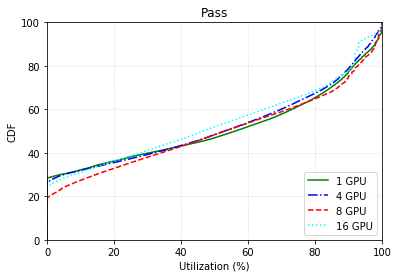

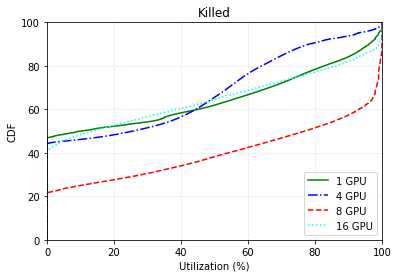

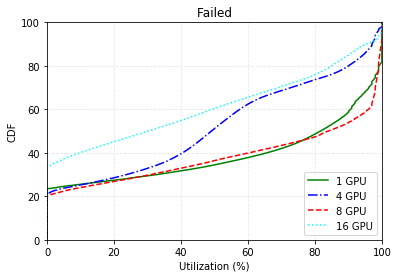

In [23]:
statuses = data.keys()

for i, status in enumerate(statuses):
    print(status)

for i, status in enumerate(statuses):
    print(status)
    a = data[status]
    print(type(data[status][1]))
    all_keys = data[status].keys()
    all_num_gpus = sorted(all_keys)
    for num_gpus in all_num_gpus:
        if num_gpus == 1:
            color = 'green'
            linestyle = '-'
        elif num_gpus == 4:
            color = 'blue'
            linestyle = '-.'
        elif num_gpus == 8:
            color = 'red'
            linestyle = '--'
        elif num_gpus == 16:
            color = 'cyan'
            linestyle = ':'
        x, y = get_cdf(data[status][num_gpus])
        plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
    p = psutil.Process(os.getpid())
    rss = p.memory_info().rss / B_2_GB
    print("{}, {}({}) occupy {:.2f} GB of memory".format(i, p.name(), p.pid, rss))
    
    if rss > 28:
        break
    
    
    plt.title(status)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.legend(loc='lower right')
    plt.xlabel('Utilization (%)')
    plt.ylabel('CDF')
    plt.grid(alpha=.3, linestyle='--')
    if i < len(statuses) - 1:
        plt.figure()
plt.show()

In [12]:
data.close()
db_file = 'get_utilization_data_large_dedicated.shelve'
data = get_utilization_data(db_file, jobs)

0/117325, python3(17687) occupy 6.54 GB of memory
100/117325, python3(17687) occupy 9.27 GB of memory
200/117325, python3(17687) occupy 11.07 GB of memory
300/117325, python3(17687) occupy 12.78 GB of memory
400/117325, python3(17687) occupy 13.04 GB of memory
500/117325, python3(17687) occupy 13.13 GB of memory
600/117325, python3(17687) occupy 13.56 GB of memory
700/117325, python3(17687) occupy 13.69 GB of memory
800/117325, python3(17687) occupy 13.71 GB of memory
900/117325, python3(17687) occupy 13.82 GB of memory
1000/117325, python3(17687) occupy 13.82 GB of memory
1100/117325, python3(17687) occupy 13.89 GB of memory
1200/117325, python3(17687) occupy 14.21 GB of memory
1300/117325, python3(17687) occupy 14.34 GB of memory
1400/117325, python3(17687) occupy 14.34 GB of memory
1500/117325, python3(17687) occupy 14.34 GB of memory
1600/117325, python3(17687) occupy 14.44 GB of memory
1700/117325, python3(17687) occupy 14.56 GB of memory
1800/117325, python3(17687) occupy 14.63 G

15400/117325, python3(17687) occupy 24.69 GB of memory
15500/117325, python3(17687) occupy 24.69 GB of memory
15600/117325, python3(17687) occupy 24.69 GB of memory
15700/117325, python3(17687) occupy 24.69 GB of memory
15800/117325, python3(17687) occupy 24.70 GB of memory
15900/117325, python3(17687) occupy 24.72 GB of memory
16000/117325, python3(17687) occupy 24.75 GB of memory
16100/117325, python3(17687) occupy 24.75 GB of memory
16200/117325, python3(17687) occupy 24.78 GB of memory
16300/117325, python3(17687) occupy 24.79 GB of memory
16400/117325, python3(17687) occupy 24.79 GB of memory
16600/117325, python3(17687) occupy 24.80 GB of memory
16700/117325, python3(17687) occupy 24.80 GB of memory
16800/117325, python3(17687) occupy 24.80 GB of memory
16900/117325, python3(17687) occupy 24.80 GB of memory
17000/117325, python3(17687) occupy 24.80 GB of memory
17100/117325, python3(17687) occupy 24.80 GB of memory
17300/117325, python3(17687) occupy 24.81 GB of memory
17400/1173

31200/117325, python3(17687) occupy 26.02 GB of memory
31300/117325, python3(17687) occupy 26.03 GB of memory
31400/117325, python3(17687) occupy 26.04 GB of memory
31600/117325, python3(17687) occupy 26.04 GB of memory
31700/117325, python3(17687) occupy 26.06 GB of memory
31800/117325, python3(17687) occupy 26.08 GB of memory
31900/117325, python3(17687) occupy 26.12 GB of memory
32000/117325, python3(17687) occupy 26.13 GB of memory
32100/117325, python3(17687) occupy 26.13 GB of memory
32200/117325, python3(17687) occupy 26.20 GB of memory
32300/117325, python3(17687) occupy 26.21 GB of memory
32400/117325, python3(17687) occupy 26.21 GB of memory
32500/117325, python3(17687) occupy 26.26 GB of memory
32600/117325, python3(17687) occupy 26.27 GB of memory
32700/117325, python3(17687) occupy 26.28 GB of memory
32800/117325, python3(17687) occupy 26.28 GB of memory
32900/117325, python3(17687) occupy 26.28 GB of memory
33000/117325, python3(17687) occupy 26.29 GB of memory
33100/1173

48200/117325, python3(17687) occupy 27.29 GB of memory
48300/117325, python3(17687) occupy 27.29 GB of memory
48400/117325, python3(17687) occupy 27.29 GB of memory
48500/117325, python3(17687) occupy 27.29 GB of memory
48600/117325, python3(17687) occupy 27.29 GB of memory
48700/117325, python3(17687) occupy 27.29 GB of memory
48800/117325, python3(17687) occupy 27.29 GB of memory
48900/117325, python3(17687) occupy 27.29 GB of memory
49000/117325, python3(17687) occupy 27.29 GB of memory
49100/117325, python3(17687) occupy 27.29 GB of memory
49200/117325, python3(17687) occupy 27.29 GB of memory
49300/117325, python3(17687) occupy 27.29 GB of memory
49500/117325, python3(17687) occupy 27.29 GB of memory
49600/117325, python3(17687) occupy 27.29 GB of memory
49700/117325, python3(17687) occupy 27.29 GB of memory
49800/117325, python3(17687) occupy 27.29 GB of memory
49900/117325, python3(17687) occupy 27.29 GB of memory
50000/117325, python3(17687) occupy 27.29 GB of memory
50100/1173

64300/117325, python3(17687) occupy 27.81 GB of memory
64400/117325, python3(17687) occupy 27.81 GB of memory
64500/117325, python3(17687) occupy 27.81 GB of memory
64600/117325, python3(17687) occupy 27.81 GB of memory
64700/117325, python3(17687) occupy 27.81 GB of memory
64800/117325, python3(17687) occupy 27.82 GB of memory
65000/117325, python3(17687) occupy 27.82 GB of memory
65200/117325, python3(17687) occupy 27.84 GB of memory
65300/117325, python3(17687) occupy 27.84 GB of memory
65400/117325, python3(17687) occupy 27.84 GB of memory
65500/117325, python3(17687) occupy 27.84 GB of memory
65600/117325, python3(17687) occupy 27.84 GB of memory
65700/117325, python3(17687) occupy 27.84 GB of memory
65800/117325, python3(17687) occupy 27.84 GB of memory
65900/117325, python3(17687) occupy 27.84 GB of memory
66000/117325, python3(17687) occupy 27.84 GB of memory
66100/117325, python3(17687) occupy 27.84 GB of memory
66200/117325, python3(17687) occupy 27.84 GB of memory
66300/1173

80400/117325, python3(17687) occupy 28.41 GB of memory
80500/117325, python3(17687) occupy 28.43 GB of memory
80600/117325, python3(17687) occupy 28.44 GB of memory
80700/117325, python3(17687) occupy 28.45 GB of memory
80900/117325, python3(17687) occupy 28.45 GB of memory
81000/117325, python3(17687) occupy 28.45 GB of memory
81100/117325, python3(17687) occupy 28.45 GB of memory
81200/117325, python3(17687) occupy 28.45 GB of memory
81300/117325, python3(17687) occupy 28.45 GB of memory
81400/117325, python3(17687) occupy 28.45 GB of memory
81500/117325, python3(17687) occupy 28.45 GB of memory
81600/117325, python3(17687) occupy 28.53 GB of memory
81700/117325, python3(17687) occupy 28.78 GB of memory
81800/117325, python3(17687) occupy 28.96 GB of memory
82000/117325, python3(17687) occupy 29.03 GB of memory
82100/117325, python3(17687) occupy 29.03 GB of memory
82200/117325, python3(17687) occupy 29.03 GB of memory
82300/117325, python3(17687) occupy 29.04 GB of memory
82400/1173

98700/117325, python3(17687) occupy 29.67 GB of memory
98800/117325, python3(17687) occupy 29.68 GB of memory
98900/117325, python3(17687) occupy 29.69 GB of memory
99000/117325, python3(17687) occupy 29.70 GB of memory
99100/117325, python3(17687) occupy 29.71 GB of memory
99200/117325, python3(17687) occupy 29.71 GB of memory
99300/117325, python3(17687) occupy 29.71 GB of memory
99400/117325, python3(17687) occupy 29.71 GB of memory
99500/117325, python3(17687) occupy 29.71 GB of memory
99600/117325, python3(17687) occupy 29.71 GB of memory
99700/117325, python3(17687) occupy 29.72 GB of memory
99800/117325, python3(17687) occupy 29.73 GB of memory
99900/117325, python3(17687) occupy 29.73 GB of memory
100000/117325, python3(17687) occupy 29.74 GB of memory
100100/117325, python3(17687) occupy 29.78 GB of memory
100200/117325, python3(17687) occupy 29.78 GB of memory
100300/117325, python3(17687) occupy 29.78 GB of memory
100400/117325, python3(17687) occupy 29.78 GB of memory
10050

115100/117325, python3(17687) occupy 26.92 GB of memory
115200/117325, python3(17687) occupy 26.93 GB of memory
115300/117325, python3(17687) occupy 27.39 GB of memory
115400/117325, python3(17687) occupy 27.82 GB of memory
115500/117325, python3(17687) occupy 27.85 GB of memory
115600/117325, python3(17687) occupy 27.85 GB of memory
115700/117325, python3(17687) occupy 27.85 GB of memory
115800/117325, python3(17687) occupy 27.85 GB of memory
115900/117325, python3(17687) occupy 27.96 GB of memory
116000/117325, python3(17687) occupy 28.36 GB of memory
116100/117325, python3(17687) occupy 28.36 GB of memory
116200/117325, python3(17687) occupy 28.36 GB of memory
116300/117325, python3(17687) occupy 28.36 GB of memory
116400/117325, python3(17687) occupy 28.36 GB of memory
116500/117325, python3(17687) occupy 28.37 GB of memory
116600/117325, python3(17687) occupy 28.43 GB of memory
116700/117325, python3(17687) occupy 28.45 GB of memory
116800/117325, python3(17687) occupy 28.45 GB of

8
python3(17687) occupy 10.14 GB of memory
1
python3(17687) occupy 10.14 GB of memory
4
python3(17687) occupy 10.14 GB of memory
16
python3(17687) occupy 10.14 GB of memory
8
python3(17687) occupy 10.14 GB of memory
1
python3(17687) occupy 10.14 GB of memory
4
python3(17687) occupy 10.14 GB of memory
16
python3(17687) occupy 10.14 GB of memory
16
python3(17687) occupy 10.14 GB of memory
1
python3(17687) occupy 10.14 GB of memory
4
python3(17687) occupy 10.14 GB of memory
8
python3(17687) occupy 10.14 GB of memory
[1, 4, 8, 16]


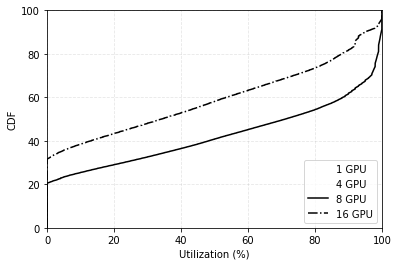

In [18]:
aggregate_data = {}
for status in data:
    for num_gpus in data[status]:
        print(num_gpus)
        if num_gpus not in aggregate_data:
            aggregate_data[num_gpus] = []
            
        p = psutil.Process(os.getpid())
        rss = p.memory_info().rss / B_2_GB
        print("{}({}) occupy {:.2f} GB of memory".format(p.name(), p.pid, rss))
        
        aggregate_data[num_gpus] += data[status][num_gpus]
all_num_gpus = sorted(aggregate_data.keys())

print(all_num_gpus)

linestyle = ''

for num_gpus in all_num_gpus:
    if num_gpus == 8:
        linestyle = '-'
    elif num_gpus == 16:
        linestyle = '-.'
    x, y = get_cdf(aggregate_data[num_gpus])
    plt.plot(x, y, label='%s GPU' % (num_gpus), color='black', linestyle=linestyle)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.xlabel('Utilization (%)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [19]:
data.close()
gpu_util.close()

In [20]:
aggregate_data = {}

# Host Resource Utilization (Figure 7)

In [21]:
mem_util_path = os.path.join(LOGDIR, 'cluster_mem_util')
# db_file = 'mem_util.shelve'
# mem_util = shelve.open(db_file, writeback=True)
# mem_util['list'] = []

mem_util = []
with open(mem_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if row[2] == 'NA':
            continue
        mem_total = float(row[2])
        mem_free = float(row[3])
        if mem_total == 0:
            continue
        mem_util.append(100.0 * (mem_total - mem_free) / mem_total)
        
        if i % 1000 == 0:
            p = psutil.Process(os.getpid())
            rss = p.memory_info().rss / B_2_GB
            print("{}, {}({}) occupy {:.2f} GB of memory".format(i, p.name(), p.pid, rss))
            
            if rss > 30:
                mem_util = []
                break
            

0, python3(17687) occupy 13.77 GB of memory
1000, python3(17687) occupy 13.77 GB of memory
2000, python3(17687) occupy 13.77 GB of memory
3000, python3(17687) occupy 13.77 GB of memory
4000, python3(17687) occupy 13.77 GB of memory
5000, python3(17687) occupy 13.77 GB of memory
6000, python3(17687) occupy 13.77 GB of memory
7000, python3(17687) occupy 13.77 GB of memory
8000, python3(17687) occupy 13.77 GB of memory
9000, python3(17687) occupy 13.77 GB of memory
10000, python3(17687) occupy 13.77 GB of memory
11000, python3(17687) occupy 13.77 GB of memory
12000, python3(17687) occupy 13.77 GB of memory
13000, python3(17687) occupy 13.77 GB of memory
14000, python3(17687) occupy 13.77 GB of memory
15000, python3(17687) occupy 13.77 GB of memory
16000, python3(17687) occupy 13.77 GB of memory
17000, python3(17687) occupy 13.77 GB of memory
18000, python3(17687) occupy 13.77 GB of memory
19000, python3(17687) occupy 13.77 GB of memory
20000, python3(17687) occupy 13.77 GB of memory
21000

270000, python3(17687) occupy 13.77 GB of memory
271000, python3(17687) occupy 13.77 GB of memory
272000, python3(17687) occupy 13.77 GB of memory
273000, python3(17687) occupy 13.77 GB of memory
274000, python3(17687) occupy 13.77 GB of memory
275000, python3(17687) occupy 13.77 GB of memory
276000, python3(17687) occupy 13.77 GB of memory
277000, python3(17687) occupy 13.77 GB of memory
278000, python3(17687) occupy 13.77 GB of memory
279000, python3(17687) occupy 13.77 GB of memory
280000, python3(17687) occupy 13.77 GB of memory
281000, python3(17687) occupy 13.77 GB of memory
282000, python3(17687) occupy 13.77 GB of memory
283000, python3(17687) occupy 13.77 GB of memory
284000, python3(17687) occupy 13.77 GB of memory
285000, python3(17687) occupy 13.77 GB of memory
286000, python3(17687) occupy 13.77 GB of memory
287000, python3(17687) occupy 13.77 GB of memory
288000, python3(17687) occupy 13.77 GB of memory
289000, python3(17687) occupy 13.77 GB of memory
290000, python3(1768

491000, python3(17687) occupy 13.77 GB of memory
492000, python3(17687) occupy 13.77 GB of memory
493000, python3(17687) occupy 13.77 GB of memory
494000, python3(17687) occupy 13.77 GB of memory
495000, python3(17687) occupy 13.77 GB of memory
496000, python3(17687) occupy 13.77 GB of memory
497000, python3(17687) occupy 13.77 GB of memory
498000, python3(17687) occupy 13.77 GB of memory
499000, python3(17687) occupy 13.77 GB of memory
500000, python3(17687) occupy 13.77 GB of memory
501000, python3(17687) occupy 13.77 GB of memory
502000, python3(17687) occupy 13.77 GB of memory
503000, python3(17687) occupy 13.77 GB of memory
504000, python3(17687) occupy 13.77 GB of memory
505000, python3(17687) occupy 13.77 GB of memory
506000, python3(17687) occupy 13.77 GB of memory
507000, python3(17687) occupy 13.77 GB of memory
508000, python3(17687) occupy 13.77 GB of memory
509000, python3(17687) occupy 13.77 GB of memory
510000, python3(17687) occupy 13.77 GB of memory
511000, python3(1768

713000, python3(17687) occupy 13.77 GB of memory
714000, python3(17687) occupy 13.77 GB of memory
715000, python3(17687) occupy 13.77 GB of memory
716000, python3(17687) occupy 13.77 GB of memory
717000, python3(17687) occupy 13.77 GB of memory
718000, python3(17687) occupy 13.77 GB of memory
719000, python3(17687) occupy 13.77 GB of memory
720000, python3(17687) occupy 13.77 GB of memory
721000, python3(17687) occupy 13.77 GB of memory
722000, python3(17687) occupy 13.77 GB of memory
723000, python3(17687) occupy 13.77 GB of memory
724000, python3(17687) occupy 13.77 GB of memory
725000, python3(17687) occupy 13.77 GB of memory
726000, python3(17687) occupy 13.77 GB of memory
727000, python3(17687) occupy 13.77 GB of memory
728000, python3(17687) occupy 13.77 GB of memory
729000, python3(17687) occupy 13.77 GB of memory
730000, python3(17687) occupy 13.77 GB of memory
731000, python3(17687) occupy 13.77 GB of memory
732000, python3(17687) occupy 13.77 GB of memory
733000, python3(1768

934000, python3(17687) occupy 13.77 GB of memory
935000, python3(17687) occupy 13.77 GB of memory
936000, python3(17687) occupy 13.77 GB of memory
937000, python3(17687) occupy 13.77 GB of memory
938000, python3(17687) occupy 13.77 GB of memory
939000, python3(17687) occupy 13.77 GB of memory
940000, python3(17687) occupy 13.77 GB of memory
941000, python3(17687) occupy 13.77 GB of memory
942000, python3(17687) occupy 13.77 GB of memory
943000, python3(17687) occupy 13.77 GB of memory
944000, python3(17687) occupy 13.77 GB of memory
945000, python3(17687) occupy 13.77 GB of memory
946000, python3(17687) occupy 13.77 GB of memory
947000, python3(17687) occupy 13.77 GB of memory
948000, python3(17687) occupy 13.77 GB of memory
949000, python3(17687) occupy 13.77 GB of memory
950000, python3(17687) occupy 13.77 GB of memory
951000, python3(17687) occupy 13.77 GB of memory
952000, python3(17687) occupy 13.77 GB of memory
953000, python3(17687) occupy 13.77 GB of memory
954000, python3(1768

1154000, python3(17687) occupy 13.78 GB of memory
1155000, python3(17687) occupy 13.78 GB of memory
1156000, python3(17687) occupy 13.78 GB of memory
1157000, python3(17687) occupy 13.78 GB of memory
1158000, python3(17687) occupy 13.78 GB of memory
1159000, python3(17687) occupy 13.78 GB of memory
1160000, python3(17687) occupy 13.78 GB of memory
1161000, python3(17687) occupy 13.78 GB of memory
1162000, python3(17687) occupy 13.78 GB of memory
1163000, python3(17687) occupy 13.78 GB of memory
1164000, python3(17687) occupy 13.78 GB of memory
1165000, python3(17687) occupy 13.78 GB of memory
1166000, python3(17687) occupy 13.78 GB of memory
1167000, python3(17687) occupy 13.78 GB of memory
1168000, python3(17687) occupy 13.78 GB of memory
1169000, python3(17687) occupy 13.78 GB of memory
1170000, python3(17687) occupy 13.78 GB of memory
1171000, python3(17687) occupy 13.78 GB of memory
1172000, python3(17687) occupy 13.78 GB of memory
1173000, python3(17687) occupy 13.78 GB of memory


1353000, python3(17687) occupy 13.78 GB of memory
1354000, python3(17687) occupy 13.78 GB of memory
1355000, python3(17687) occupy 13.78 GB of memory
1356000, python3(17687) occupy 13.78 GB of memory
1357000, python3(17687) occupy 13.78 GB of memory
1358000, python3(17687) occupy 13.78 GB of memory
1359000, python3(17687) occupy 13.78 GB of memory
1360000, python3(17687) occupy 13.78 GB of memory
1361000, python3(17687) occupy 13.78 GB of memory
1362000, python3(17687) occupy 13.78 GB of memory
1363000, python3(17687) occupy 13.78 GB of memory
1364000, python3(17687) occupy 13.78 GB of memory
1365000, python3(17687) occupy 13.78 GB of memory
1366000, python3(17687) occupy 13.78 GB of memory
1367000, python3(17687) occupy 13.78 GB of memory
1368000, python3(17687) occupy 13.78 GB of memory
1369000, python3(17687) occupy 13.78 GB of memory
1370000, python3(17687) occupy 13.78 GB of memory
1371000, python3(17687) occupy 13.78 GB of memory
1372000, python3(17687) occupy 13.78 GB of memory


1553000, python3(17687) occupy 13.78 GB of memory
1554000, python3(17687) occupy 13.78 GB of memory
1555000, python3(17687) occupy 13.78 GB of memory
1556000, python3(17687) occupy 13.78 GB of memory
1557000, python3(17687) occupy 13.78 GB of memory
1558000, python3(17687) occupy 13.78 GB of memory
1559000, python3(17687) occupy 13.78 GB of memory
1560000, python3(17687) occupy 13.78 GB of memory
1561000, python3(17687) occupy 13.78 GB of memory
1562000, python3(17687) occupy 13.78 GB of memory
1563000, python3(17687) occupy 13.78 GB of memory
1564000, python3(17687) occupy 13.78 GB of memory
1565000, python3(17687) occupy 13.78 GB of memory
1566000, python3(17687) occupy 13.78 GB of memory
1567000, python3(17687) occupy 13.78 GB of memory
1568000, python3(17687) occupy 13.78 GB of memory
1569000, python3(17687) occupy 13.78 GB of memory
1570000, python3(17687) occupy 13.78 GB of memory
1571000, python3(17687) occupy 13.78 GB of memory
1572000, python3(17687) occupy 13.78 GB of memory


1756000, python3(17687) occupy 13.79 GB of memory
1757000, python3(17687) occupy 13.79 GB of memory
1758000, python3(17687) occupy 13.79 GB of memory
1759000, python3(17687) occupy 13.79 GB of memory
1760000, python3(17687) occupy 13.79 GB of memory
1761000, python3(17687) occupy 13.79 GB of memory
1762000, python3(17687) occupy 13.79 GB of memory
1763000, python3(17687) occupy 13.79 GB of memory
1764000, python3(17687) occupy 13.79 GB of memory
1765000, python3(17687) occupy 13.79 GB of memory
1766000, python3(17687) occupy 13.79 GB of memory
1767000, python3(17687) occupy 13.79 GB of memory
1768000, python3(17687) occupy 13.79 GB of memory
1769000, python3(17687) occupy 13.79 GB of memory
1770000, python3(17687) occupy 13.79 GB of memory
1771000, python3(17687) occupy 13.79 GB of memory
1772000, python3(17687) occupy 13.79 GB of memory
1773000, python3(17687) occupy 13.79 GB of memory
1774000, python3(17687) occupy 13.79 GB of memory
1775000, python3(17687) occupy 13.79 GB of memory


1961000, python3(17687) occupy 13.79 GB of memory
1962000, python3(17687) occupy 13.79 GB of memory
1963000, python3(17687) occupy 13.79 GB of memory
1964000, python3(17687) occupy 13.79 GB of memory
1965000, python3(17687) occupy 13.79 GB of memory
1966000, python3(17687) occupy 13.79 GB of memory
1967000, python3(17687) occupy 13.79 GB of memory
1968000, python3(17687) occupy 13.79 GB of memory
1969000, python3(17687) occupy 13.79 GB of memory
1970000, python3(17687) occupy 13.79 GB of memory
1971000, python3(17687) occupy 13.79 GB of memory
1972000, python3(17687) occupy 13.79 GB of memory
1973000, python3(17687) occupy 13.79 GB of memory
1974000, python3(17687) occupy 13.79 GB of memory
1975000, python3(17687) occupy 13.79 GB of memory
1976000, python3(17687) occupy 13.79 GB of memory
1977000, python3(17687) occupy 13.79 GB of memory
1978000, python3(17687) occupy 13.79 GB of memory
1979000, python3(17687) occupy 13.79 GB of memory
1980000, python3(17687) occupy 13.79 GB of memory


2151000, python3(17687) occupy 13.80 GB of memory
2152000, python3(17687) occupy 13.80 GB of memory
2153000, python3(17687) occupy 13.80 GB of memory
2154000, python3(17687) occupy 13.80 GB of memory
2155000, python3(17687) occupy 13.80 GB of memory
2156000, python3(17687) occupy 13.80 GB of memory
2157000, python3(17687) occupy 13.80 GB of memory
2158000, python3(17687) occupy 13.80 GB of memory
2159000, python3(17687) occupy 13.80 GB of memory
2160000, python3(17687) occupy 13.80 GB of memory
2161000, python3(17687) occupy 13.80 GB of memory
2163000, python3(17687) occupy 13.80 GB of memory
2164000, python3(17687) occupy 13.80 GB of memory
2165000, python3(17687) occupy 13.80 GB of memory
2166000, python3(17687) occupy 13.80 GB of memory
2167000, python3(17687) occupy 13.80 GB of memory
2168000, python3(17687) occupy 13.80 GB of memory
2169000, python3(17687) occupy 13.80 GB of memory
2170000, python3(17687) occupy 13.80 GB of memory
2171000, python3(17687) occupy 13.80 GB of memory


2355000, python3(17687) occupy 13.80 GB of memory
2356000, python3(17687) occupy 13.80 GB of memory
2357000, python3(17687) occupy 13.80 GB of memory
2358000, python3(17687) occupy 13.80 GB of memory
2359000, python3(17687) occupy 13.80 GB of memory
2360000, python3(17687) occupy 13.80 GB of memory
2361000, python3(17687) occupy 13.80 GB of memory
2362000, python3(17687) occupy 13.80 GB of memory
2363000, python3(17687) occupy 13.80 GB of memory
2364000, python3(17687) occupy 13.80 GB of memory
2365000, python3(17687) occupy 13.80 GB of memory
2366000, python3(17687) occupy 13.80 GB of memory
2367000, python3(17687) occupy 13.80 GB of memory
2368000, python3(17687) occupy 13.80 GB of memory
2369000, python3(17687) occupy 13.80 GB of memory
2370000, python3(17687) occupy 13.80 GB of memory
2371000, python3(17687) occupy 13.80 GB of memory
2372000, python3(17687) occupy 13.80 GB of memory
2373000, python3(17687) occupy 13.80 GB of memory
2374000, python3(17687) occupy 13.80 GB of memory


2570000, python3(17687) occupy 13.81 GB of memory
2571000, python3(17687) occupy 13.81 GB of memory
2572000, python3(17687) occupy 13.81 GB of memory
2573000, python3(17687) occupy 13.81 GB of memory
2574000, python3(17687) occupy 13.81 GB of memory
2575000, python3(17687) occupy 13.81 GB of memory
2576000, python3(17687) occupy 13.81 GB of memory
2577000, python3(17687) occupy 13.81 GB of memory
2578000, python3(17687) occupy 13.81 GB of memory
2579000, python3(17687) occupy 13.81 GB of memory
2580000, python3(17687) occupy 13.81 GB of memory
2581000, python3(17687) occupy 13.81 GB of memory
2582000, python3(17687) occupy 13.81 GB of memory
2583000, python3(17687) occupy 13.81 GB of memory
2584000, python3(17687) occupy 13.81 GB of memory
2585000, python3(17687) occupy 13.81 GB of memory
2586000, python3(17687) occupy 13.81 GB of memory
2587000, python3(17687) occupy 13.81 GB of memory
2588000, python3(17687) occupy 13.81 GB of memory
2589000, python3(17687) occupy 13.81 GB of memory


2781000, python3(17687) occupy 13.81 GB of memory
2782000, python3(17687) occupy 13.81 GB of memory
2783000, python3(17687) occupy 13.81 GB of memory
2784000, python3(17687) occupy 13.81 GB of memory
2785000, python3(17687) occupy 13.81 GB of memory
2786000, python3(17687) occupy 13.81 GB of memory
2787000, python3(17687) occupy 13.81 GB of memory
2788000, python3(17687) occupy 13.81 GB of memory
2789000, python3(17687) occupy 13.81 GB of memory
2790000, python3(17687) occupy 13.81 GB of memory
2791000, python3(17687) occupy 13.81 GB of memory
2792000, python3(17687) occupy 13.81 GB of memory
2793000, python3(17687) occupy 13.81 GB of memory
2794000, python3(17687) occupy 13.81 GB of memory
2795000, python3(17687) occupy 13.81 GB of memory
2796000, python3(17687) occupy 13.81 GB of memory
2797000, python3(17687) occupy 13.81 GB of memory
2798000, python3(17687) occupy 13.81 GB of memory
2799000, python3(17687) occupy 13.81 GB of memory
2800000, python3(17687) occupy 13.81 GB of memory


2989000, python3(17687) occupy 13.82 GB of memory
2990000, python3(17687) occupy 13.82 GB of memory
2991000, python3(17687) occupy 13.82 GB of memory
2992000, python3(17687) occupy 13.82 GB of memory
2993000, python3(17687) occupy 13.82 GB of memory
2994000, python3(17687) occupy 13.82 GB of memory
2995000, python3(17687) occupy 13.82 GB of memory
2996000, python3(17687) occupy 13.82 GB of memory
2997000, python3(17687) occupy 13.82 GB of memory
2998000, python3(17687) occupy 13.82 GB of memory
2999000, python3(17687) occupy 13.82 GB of memory
3000000, python3(17687) occupy 13.82 GB of memory
3001000, python3(17687) occupy 13.82 GB of memory
3002000, python3(17687) occupy 13.82 GB of memory
3003000, python3(17687) occupy 13.82 GB of memory
3004000, python3(17687) occupy 13.82 GB of memory
3005000, python3(17687) occupy 13.82 GB of memory
3006000, python3(17687) occupy 13.82 GB of memory
3007000, python3(17687) occupy 13.82 GB of memory
3008000, python3(17687) occupy 13.82 GB of memory


3177000, python3(17687) occupy 13.82 GB of memory
3178000, python3(17687) occupy 13.82 GB of memory
3179000, python3(17687) occupy 13.82 GB of memory
3180000, python3(17687) occupy 13.82 GB of memory
3181000, python3(17687) occupy 13.82 GB of memory
3182000, python3(17687) occupy 13.82 GB of memory
3183000, python3(17687) occupy 13.82 GB of memory
3184000, python3(17687) occupy 13.82 GB of memory
3185000, python3(17687) occupy 13.82 GB of memory
3186000, python3(17687) occupy 13.82 GB of memory
3187000, python3(17687) occupy 13.82 GB of memory
3188000, python3(17687) occupy 13.82 GB of memory
3189000, python3(17687) occupy 13.82 GB of memory
3190000, python3(17687) occupy 13.82 GB of memory
3191000, python3(17687) occupy 13.82 GB of memory
3192000, python3(17687) occupy 13.82 GB of memory
3193000, python3(17687) occupy 13.82 GB of memory
3194000, python3(17687) occupy 13.82 GB of memory
3195000, python3(17687) occupy 13.82 GB of memory
3196000, python3(17687) occupy 13.82 GB of memory


3380000, python3(17687) occupy 13.83 GB of memory
3381000, python3(17687) occupy 13.83 GB of memory
3382000, python3(17687) occupy 13.83 GB of memory
3383000, python3(17687) occupy 13.83 GB of memory
3384000, python3(17687) occupy 13.83 GB of memory
3385000, python3(17687) occupy 13.83 GB of memory
3386000, python3(17687) occupy 13.83 GB of memory
3387000, python3(17687) occupy 13.83 GB of memory
3388000, python3(17687) occupy 13.83 GB of memory
3389000, python3(17687) occupy 13.83 GB of memory
3390000, python3(17687) occupy 13.83 GB of memory
3391000, python3(17687) occupy 13.83 GB of memory
3392000, python3(17687) occupy 13.83 GB of memory
3393000, python3(17687) occupy 13.83 GB of memory
3394000, python3(17687) occupy 13.83 GB of memory
3395000, python3(17687) occupy 13.83 GB of memory
3396000, python3(17687) occupy 13.83 GB of memory
3397000, python3(17687) occupy 13.83 GB of memory
3398000, python3(17687) occupy 13.83 GB of memory
3399000, python3(17687) occupy 13.83 GB of memory


3567000, python3(17687) occupy 13.83 GB of memory
3568000, python3(17687) occupy 13.83 GB of memory
3569000, python3(17687) occupy 13.83 GB of memory
3570000, python3(17687) occupy 13.83 GB of memory
3571000, python3(17687) occupy 13.83 GB of memory
3572000, python3(17687) occupy 13.83 GB of memory
3573000, python3(17687) occupy 13.83 GB of memory
3574000, python3(17687) occupy 13.83 GB of memory
3575000, python3(17687) occupy 13.83 GB of memory
3576000, python3(17687) occupy 13.83 GB of memory
3577000, python3(17687) occupy 13.83 GB of memory
3578000, python3(17687) occupy 13.83 GB of memory
3579000, python3(17687) occupy 13.83 GB of memory
3580000, python3(17687) occupy 13.83 GB of memory
3581000, python3(17687) occupy 13.83 GB of memory
3582000, python3(17687) occupy 13.83 GB of memory
3583000, python3(17687) occupy 13.83 GB of memory
3584000, python3(17687) occupy 13.83 GB of memory
3585000, python3(17687) occupy 13.83 GB of memory
3586000, python3(17687) occupy 13.83 GB of memory


3767000, python3(17687) occupy 13.83 GB of memory
3768000, python3(17687) occupy 13.83 GB of memory
3769000, python3(17687) occupy 13.83 GB of memory
3770000, python3(17687) occupy 13.83 GB of memory
3771000, python3(17687) occupy 13.83 GB of memory
3772000, python3(17687) occupy 13.83 GB of memory
3773000, python3(17687) occupy 13.83 GB of memory
3774000, python3(17687) occupy 13.83 GB of memory
3775000, python3(17687) occupy 13.83 GB of memory
3776000, python3(17687) occupy 13.83 GB of memory
3777000, python3(17687) occupy 13.83 GB of memory
3778000, python3(17687) occupy 13.83 GB of memory
3779000, python3(17687) occupy 13.83 GB of memory
3780000, python3(17687) occupy 13.83 GB of memory
3781000, python3(17687) occupy 13.83 GB of memory
3782000, python3(17687) occupy 13.83 GB of memory
3783000, python3(17687) occupy 13.83 GB of memory
3784000, python3(17687) occupy 13.83 GB of memory
3785000, python3(17687) occupy 13.83 GB of memory
3786000, python3(17687) occupy 13.83 GB of memory


3969000, python3(17687) occupy 13.84 GB of memory
3970000, python3(17687) occupy 13.84 GB of memory
3971000, python3(17687) occupy 13.84 GB of memory
3972000, python3(17687) occupy 13.84 GB of memory
3973000, python3(17687) occupy 13.84 GB of memory
3974000, python3(17687) occupy 13.84 GB of memory
3975000, python3(17687) occupy 13.84 GB of memory
3976000, python3(17687) occupy 13.84 GB of memory
3977000, python3(17687) occupy 13.84 GB of memory
3978000, python3(17687) occupy 13.84 GB of memory
3979000, python3(17687) occupy 13.84 GB of memory
3980000, python3(17687) occupy 13.84 GB of memory
3981000, python3(17687) occupy 13.84 GB of memory
3982000, python3(17687) occupy 13.84 GB of memory
3983000, python3(17687) occupy 13.84 GB of memory
3984000, python3(17687) occupy 13.84 GB of memory
3985000, python3(17687) occupy 13.84 GB of memory
3986000, python3(17687) occupy 13.84 GB of memory
3987000, python3(17687) occupy 13.84 GB of memory
3988000, python3(17687) occupy 13.84 GB of memory


4185000, python3(17687) occupy 13.84 GB of memory
4186000, python3(17687) occupy 13.84 GB of memory
4187000, python3(17687) occupy 13.84 GB of memory
4188000, python3(17687) occupy 13.84 GB of memory
4189000, python3(17687) occupy 13.84 GB of memory
4190000, python3(17687) occupy 13.84 GB of memory
4191000, python3(17687) occupy 13.84 GB of memory
4192000, python3(17687) occupy 13.84 GB of memory
4193000, python3(17687) occupy 13.84 GB of memory
4194000, python3(17687) occupy 13.84 GB of memory
4195000, python3(17687) occupy 13.84 GB of memory
4196000, python3(17687) occupy 13.84 GB of memory
4197000, python3(17687) occupy 13.84 GB of memory
4198000, python3(17687) occupy 13.84 GB of memory
4199000, python3(17687) occupy 13.84 GB of memory
4200000, python3(17687) occupy 13.84 GB of memory
4201000, python3(17687) occupy 13.84 GB of memory
4202000, python3(17687) occupy 13.84 GB of memory
4203000, python3(17687) occupy 13.84 GB of memory
4204000, python3(17687) occupy 13.84 GB of memory


4390000, python3(17687) occupy 13.85 GB of memory
4391000, python3(17687) occupy 13.85 GB of memory
4392000, python3(17687) occupy 13.85 GB of memory
4393000, python3(17687) occupy 13.85 GB of memory
4394000, python3(17687) occupy 13.85 GB of memory
4395000, python3(17687) occupy 13.85 GB of memory
4396000, python3(17687) occupy 13.85 GB of memory
4397000, python3(17687) occupy 13.85 GB of memory
4398000, python3(17687) occupy 13.85 GB of memory
4399000, python3(17687) occupy 13.85 GB of memory
4400000, python3(17687) occupy 13.85 GB of memory
4401000, python3(17687) occupy 13.85 GB of memory
4402000, python3(17687) occupy 13.85 GB of memory
4403000, python3(17687) occupy 13.85 GB of memory
4404000, python3(17687) occupy 13.85 GB of memory
4405000, python3(17687) occupy 13.85 GB of memory
4406000, python3(17687) occupy 13.85 GB of memory
4407000, python3(17687) occupy 13.85 GB of memory
4408000, python3(17687) occupy 13.85 GB of memory
4409000, python3(17687) occupy 13.85 GB of memory


4585000, python3(17687) occupy 13.85 GB of memory
4586000, python3(17687) occupy 13.85 GB of memory
4587000, python3(17687) occupy 13.85 GB of memory
4588000, python3(17687) occupy 13.85 GB of memory
4589000, python3(17687) occupy 13.85 GB of memory
4590000, python3(17687) occupy 13.85 GB of memory
4591000, python3(17687) occupy 13.85 GB of memory
4592000, python3(17687) occupy 13.85 GB of memory
4593000, python3(17687) occupy 13.85 GB of memory
4594000, python3(17687) occupy 13.85 GB of memory
4595000, python3(17687) occupy 13.85 GB of memory
4596000, python3(17687) occupy 13.85 GB of memory
4597000, python3(17687) occupy 13.85 GB of memory
4598000, python3(17687) occupy 13.85 GB of memory
4599000, python3(17687) occupy 13.85 GB of memory
4600000, python3(17687) occupy 13.85 GB of memory
4601000, python3(17687) occupy 13.85 GB of memory
4602000, python3(17687) occupy 13.85 GB of memory
4603000, python3(17687) occupy 13.85 GB of memory
4604000, python3(17687) occupy 13.85 GB of memory


4785000, python3(17687) occupy 13.86 GB of memory
4786000, python3(17687) occupy 13.86 GB of memory
4787000, python3(17687) occupy 13.86 GB of memory
4788000, python3(17687) occupy 13.86 GB of memory
4789000, python3(17687) occupy 13.86 GB of memory
4790000, python3(17687) occupy 13.86 GB of memory
4791000, python3(17687) occupy 13.86 GB of memory
4792000, python3(17687) occupy 13.86 GB of memory
4797000, python3(17687) occupy 13.86 GB of memory
4800000, python3(17687) occupy 13.86 GB of memory
4801000, python3(17687) occupy 13.86 GB of memory
4802000, python3(17687) occupy 13.86 GB of memory
4803000, python3(17687) occupy 13.86 GB of memory
4804000, python3(17687) occupy 13.86 GB of memory
4805000, python3(17687) occupy 13.86 GB of memory
4806000, python3(17687) occupy 13.86 GB of memory
4807000, python3(17687) occupy 13.86 GB of memory
4808000, python3(17687) occupy 13.86 GB of memory
4809000, python3(17687) occupy 13.86 GB of memory
4810000, python3(17687) occupy 13.86 GB of memory


4996000, python3(17687) occupy 13.86 GB of memory
4997000, python3(17687) occupy 13.86 GB of memory
4998000, python3(17687) occupy 13.86 GB of memory
4999000, python3(17687) occupy 13.86 GB of memory
5000000, python3(17687) occupy 13.86 GB of memory
5001000, python3(17687) occupy 13.86 GB of memory
5002000, python3(17687) occupy 13.86 GB of memory
5003000, python3(17687) occupy 13.86 GB of memory
5004000, python3(17687) occupy 13.86 GB of memory
5005000, python3(17687) occupy 13.86 GB of memory
5006000, python3(17687) occupy 13.86 GB of memory
5007000, python3(17687) occupy 13.86 GB of memory
5008000, python3(17687) occupy 13.86 GB of memory
5009000, python3(17687) occupy 13.86 GB of memory
5010000, python3(17687) occupy 13.86 GB of memory
5012000, python3(17687) occupy 13.86 GB of memory
5013000, python3(17687) occupy 13.86 GB of memory
5014000, python3(17687) occupy 13.86 GB of memory
5015000, python3(17687) occupy 13.86 GB of memory
5016000, python3(17687) occupy 13.86 GB of memory


5211000, python3(17687) occupy 13.87 GB of memory
5212000, python3(17687) occupy 13.87 GB of memory
5213000, python3(17687) occupy 13.87 GB of memory
5214000, python3(17687) occupy 13.87 GB of memory
5215000, python3(17687) occupy 13.87 GB of memory
5216000, python3(17687) occupy 13.87 GB of memory
5217000, python3(17687) occupy 13.87 GB of memory
5218000, python3(17687) occupy 13.87 GB of memory
5219000, python3(17687) occupy 13.87 GB of memory
5220000, python3(17687) occupy 13.87 GB of memory
5221000, python3(17687) occupy 13.87 GB of memory
5222000, python3(17687) occupy 13.87 GB of memory
5223000, python3(17687) occupy 13.87 GB of memory
5224000, python3(17687) occupy 13.87 GB of memory
5225000, python3(17687) occupy 13.87 GB of memory
5226000, python3(17687) occupy 13.87 GB of memory
5227000, python3(17687) occupy 13.87 GB of memory
5228000, python3(17687) occupy 13.87 GB of memory
5229000, python3(17687) occupy 13.87 GB of memory
5230000, python3(17687) occupy 13.87 GB of memory


5426000, python3(17687) occupy 13.87 GB of memory
5427000, python3(17687) occupy 13.87 GB of memory
5428000, python3(17687) occupy 13.87 GB of memory
5429000, python3(17687) occupy 13.87 GB of memory
5430000, python3(17687) occupy 13.87 GB of memory
5431000, python3(17687) occupy 13.87 GB of memory
5432000, python3(17687) occupy 13.87 GB of memory
5433000, python3(17687) occupy 13.87 GB of memory
5434000, python3(17687) occupy 13.87 GB of memory
5435000, python3(17687) occupy 13.87 GB of memory
5436000, python3(17687) occupy 13.87 GB of memory
5437000, python3(17687) occupy 13.87 GB of memory
5438000, python3(17687) occupy 13.87 GB of memory
5439000, python3(17687) occupy 13.87 GB of memory
5440000, python3(17687) occupy 13.87 GB of memory
5441000, python3(17687) occupy 13.87 GB of memory
5442000, python3(17687) occupy 13.87 GB of memory
5443000, python3(17687) occupy 13.87 GB of memory
5444000, python3(17687) occupy 13.87 GB of memory
5445000, python3(17687) occupy 13.87 GB of memory


5631000, python3(17687) occupy 13.88 GB of memory
5632000, python3(17687) occupy 13.88 GB of memory
5633000, python3(17687) occupy 13.88 GB of memory
5634000, python3(17687) occupy 13.88 GB of memory
5635000, python3(17687) occupy 13.88 GB of memory
5636000, python3(17687) occupy 13.88 GB of memory
5637000, python3(17687) occupy 13.88 GB of memory
5638000, python3(17687) occupy 13.88 GB of memory
5639000, python3(17687) occupy 13.88 GB of memory
5640000, python3(17687) occupy 13.88 GB of memory
5641000, python3(17687) occupy 13.88 GB of memory
5642000, python3(17687) occupy 13.88 GB of memory
5643000, python3(17687) occupy 13.88 GB of memory
5644000, python3(17687) occupy 13.88 GB of memory
5645000, python3(17687) occupy 13.88 GB of memory
5646000, python3(17687) occupy 13.88 GB of memory
5647000, python3(17687) occupy 13.88 GB of memory
5648000, python3(17687) occupy 13.88 GB of memory
5649000, python3(17687) occupy 13.88 GB of memory
5650000, python3(17687) occupy 13.88 GB of memory


5870000, python3(17687) occupy 13.88 GB of memory
5871000, python3(17687) occupy 13.88 GB of memory
5872000, python3(17687) occupy 13.88 GB of memory
5873000, python3(17687) occupy 13.88 GB of memory
5874000, python3(17687) occupy 13.88 GB of memory
5875000, python3(17687) occupy 13.88 GB of memory
5876000, python3(17687) occupy 13.88 GB of memory
5877000, python3(17687) occupy 13.88 GB of memory
5878000, python3(17687) occupy 13.88 GB of memory
5879000, python3(17687) occupy 13.88 GB of memory
5880000, python3(17687) occupy 13.88 GB of memory
5881000, python3(17687) occupy 13.88 GB of memory
5882000, python3(17687) occupy 13.88 GB of memory
5883000, python3(17687) occupy 13.88 GB of memory
5884000, python3(17687) occupy 13.88 GB of memory
5885000, python3(17687) occupy 13.88 GB of memory
5886000, python3(17687) occupy 13.88 GB of memory
5887000, python3(17687) occupy 13.88 GB of memory
5888000, python3(17687) occupy 13.88 GB of memory
5889000, python3(17687) occupy 13.88 GB of memory


6075000, python3(17687) occupy 13.88 GB of memory
6076000, python3(17687) occupy 13.88 GB of memory
6077000, python3(17687) occupy 13.88 GB of memory
6078000, python3(17687) occupy 13.88 GB of memory
6079000, python3(17687) occupy 13.88 GB of memory
6080000, python3(17687) occupy 13.88 GB of memory
6081000, python3(17687) occupy 13.88 GB of memory
6082000, python3(17687) occupy 13.88 GB of memory
6083000, python3(17687) occupy 13.88 GB of memory
6084000, python3(17687) occupy 13.88 GB of memory
6085000, python3(17687) occupy 13.88 GB of memory
6086000, python3(17687) occupy 13.88 GB of memory
6087000, python3(17687) occupy 13.88 GB of memory
6088000, python3(17687) occupy 13.88 GB of memory
6089000, python3(17687) occupy 13.88 GB of memory
6090000, python3(17687) occupy 13.88 GB of memory
6091000, python3(17687) occupy 13.88 GB of memory
6092000, python3(17687) occupy 13.88 GB of memory
6093000, python3(17687) occupy 13.88 GB of memory
6094000, python3(17687) occupy 13.88 GB of memory


6290000, python3(17687) occupy 13.89 GB of memory
6291000, python3(17687) occupy 13.89 GB of memory
6292000, python3(17687) occupy 13.89 GB of memory
6293000, python3(17687) occupy 13.89 GB of memory
6294000, python3(17687) occupy 13.89 GB of memory
6295000, python3(17687) occupy 13.89 GB of memory
6296000, python3(17687) occupy 13.89 GB of memory
6297000, python3(17687) occupy 13.89 GB of memory
6298000, python3(17687) occupy 13.89 GB of memory
6299000, python3(17687) occupy 13.89 GB of memory
6300000, python3(17687) occupy 13.89 GB of memory
6301000, python3(17687) occupy 13.89 GB of memory
6302000, python3(17687) occupy 13.89 GB of memory
6303000, python3(17687) occupy 13.89 GB of memory
6304000, python3(17687) occupy 13.89 GB of memory
6305000, python3(17687) occupy 13.89 GB of memory
6306000, python3(17687) occupy 13.89 GB of memory
6307000, python3(17687) occupy 13.89 GB of memory
6308000, python3(17687) occupy 13.89 GB of memory
6309000, python3(17687) occupy 13.89 GB of memory


6569000, python3(17687) occupy 13.89 GB of memory
6570000, python3(17687) occupy 13.89 GB of memory
6571000, python3(17687) occupy 13.89 GB of memory
6572000, python3(17687) occupy 13.89 GB of memory
6573000, python3(17687) occupy 13.89 GB of memory
6574000, python3(17687) occupy 13.89 GB of memory
6575000, python3(17687) occupy 13.89 GB of memory
6576000, python3(17687) occupy 13.89 GB of memory
6577000, python3(17687) occupy 13.89 GB of memory
6578000, python3(17687) occupy 13.89 GB of memory
6579000, python3(17687) occupy 13.89 GB of memory
6580000, python3(17687) occupy 13.89 GB of memory
6581000, python3(17687) occupy 13.89 GB of memory
6582000, python3(17687) occupy 13.89 GB of memory
6583000, python3(17687) occupy 13.89 GB of memory
6584000, python3(17687) occupy 13.89 GB of memory
6585000, python3(17687) occupy 13.89 GB of memory
6586000, python3(17687) occupy 13.89 GB of memory
6587000, python3(17687) occupy 13.89 GB of memory
6588000, python3(17687) occupy 13.89 GB of memory


6867000, python3(17687) occupy 13.90 GB of memory
6868000, python3(17687) occupy 13.90 GB of memory
6869000, python3(17687) occupy 13.90 GB of memory
6870000, python3(17687) occupy 13.90 GB of memory
6871000, python3(17687) occupy 13.90 GB of memory
6872000, python3(17687) occupy 13.90 GB of memory
6873000, python3(17687) occupy 13.90 GB of memory
6874000, python3(17687) occupy 13.90 GB of memory
6875000, python3(17687) occupy 13.90 GB of memory
6876000, python3(17687) occupy 13.90 GB of memory
6877000, python3(17687) occupy 13.90 GB of memory
6878000, python3(17687) occupy 13.90 GB of memory
6879000, python3(17687) occupy 13.90 GB of memory
6880000, python3(17687) occupy 13.90 GB of memory
6881000, python3(17687) occupy 13.90 GB of memory
6882000, python3(17687) occupy 13.90 GB of memory
6883000, python3(17687) occupy 13.90 GB of memory
6884000, python3(17687) occupy 13.90 GB of memory
6885000, python3(17687) occupy 13.90 GB of memory
6886000, python3(17687) occupy 13.90 GB of memory


7070000, python3(17687) occupy 13.90 GB of memory
7071000, python3(17687) occupy 13.90 GB of memory
7072000, python3(17687) occupy 13.90 GB of memory
7073000, python3(17687) occupy 13.90 GB of memory
7074000, python3(17687) occupy 13.90 GB of memory
7075000, python3(17687) occupy 13.90 GB of memory
7076000, python3(17687) occupy 13.90 GB of memory
7077000, python3(17687) occupy 13.90 GB of memory
7078000, python3(17687) occupy 13.90 GB of memory
7079000, python3(17687) occupy 13.90 GB of memory
7080000, python3(17687) occupy 13.90 GB of memory
7081000, python3(17687) occupy 13.90 GB of memory
7082000, python3(17687) occupy 13.90 GB of memory
7083000, python3(17687) occupy 13.90 GB of memory
7084000, python3(17687) occupy 13.90 GB of memory
7085000, python3(17687) occupy 13.90 GB of memory
7086000, python3(17687) occupy 13.90 GB of memory
7087000, python3(17687) occupy 13.90 GB of memory
7088000, python3(17687) occupy 13.90 GB of memory
7089000, python3(17687) occupy 13.90 GB of memory


7269000, python3(17687) occupy 13.91 GB of memory
7270000, python3(17687) occupy 13.91 GB of memory
7271000, python3(17687) occupy 13.91 GB of memory
7272000, python3(17687) occupy 13.91 GB of memory
7273000, python3(17687) occupy 13.91 GB of memory
7274000, python3(17687) occupy 13.91 GB of memory
7275000, python3(17687) occupy 13.91 GB of memory
7276000, python3(17687) occupy 13.91 GB of memory
7277000, python3(17687) occupy 13.91 GB of memory
7278000, python3(17687) occupy 13.91 GB of memory
7279000, python3(17687) occupy 13.91 GB of memory
7280000, python3(17687) occupy 13.91 GB of memory
7281000, python3(17687) occupy 13.91 GB of memory
7282000, python3(17687) occupy 13.91 GB of memory
7283000, python3(17687) occupy 13.91 GB of memory
7284000, python3(17687) occupy 13.91 GB of memory
7285000, python3(17687) occupy 13.91 GB of memory
7286000, python3(17687) occupy 13.91 GB of memory
7287000, python3(17687) occupy 13.91 GB of memory
7288000, python3(17687) occupy 13.91 GB of memory


7548000, python3(17687) occupy 13.91 GB of memory
7549000, python3(17687) occupy 13.91 GB of memory
7550000, python3(17687) occupy 13.91 GB of memory
7551000, python3(17687) occupy 13.91 GB of memory
7552000, python3(17687) occupy 13.91 GB of memory
7553000, python3(17687) occupy 13.91 GB of memory
7554000, python3(17687) occupy 13.91 GB of memory
7555000, python3(17687) occupy 13.91 GB of memory
7556000, python3(17687) occupy 13.91 GB of memory
7557000, python3(17687) occupy 13.91 GB of memory
7558000, python3(17687) occupy 13.91 GB of memory
7559000, python3(17687) occupy 13.91 GB of memory
7560000, python3(17687) occupy 13.91 GB of memory
7561000, python3(17687) occupy 13.91 GB of memory
7562000, python3(17687) occupy 13.91 GB of memory
7563000, python3(17687) occupy 13.91 GB of memory
7564000, python3(17687) occupy 13.91 GB of memory
7565000, python3(17687) occupy 13.91 GB of memory
7566000, python3(17687) occupy 13.91 GB of memory
7567000, python3(17687) occupy 13.91 GB of memory


7753000, python3(17687) occupy 13.91 GB of memory
7754000, python3(17687) occupy 13.91 GB of memory
7755000, python3(17687) occupy 13.91 GB of memory
7756000, python3(17687) occupy 13.91 GB of memory
7757000, python3(17687) occupy 13.91 GB of memory
7758000, python3(17687) occupy 13.91 GB of memory
7759000, python3(17687) occupy 13.91 GB of memory
7760000, python3(17687) occupy 13.91 GB of memory
7761000, python3(17687) occupy 13.91 GB of memory
7762000, python3(17687) occupy 13.91 GB of memory
7763000, python3(17687) occupy 13.91 GB of memory
7764000, python3(17687) occupy 13.92 GB of memory
7765000, python3(17687) occupy 13.92 GB of memory
7766000, python3(17687) occupy 13.92 GB of memory
7767000, python3(17687) occupy 13.92 GB of memory
7768000, python3(17687) occupy 13.92 GB of memory
7769000, python3(17687) occupy 13.92 GB of memory
7770000, python3(17687) occupy 13.92 GB of memory
7771000, python3(17687) occupy 13.92 GB of memory
7772000, python3(17687) occupy 13.92 GB of memory


7953000, python3(17687) occupy 13.92 GB of memory
7954000, python3(17687) occupy 13.92 GB of memory
7955000, python3(17687) occupy 13.92 GB of memory
7956000, python3(17687) occupy 13.92 GB of memory
7957000, python3(17687) occupy 13.92 GB of memory
7958000, python3(17687) occupy 13.92 GB of memory
7959000, python3(17687) occupy 13.92 GB of memory
7960000, python3(17687) occupy 13.92 GB of memory
7961000, python3(17687) occupy 13.92 GB of memory
7962000, python3(17687) occupy 13.92 GB of memory
7963000, python3(17687) occupy 13.92 GB of memory
7964000, python3(17687) occupy 13.92 GB of memory
7965000, python3(17687) occupy 13.92 GB of memory
7966000, python3(17687) occupy 13.92 GB of memory
7967000, python3(17687) occupy 13.92 GB of memory
7968000, python3(17687) occupy 13.92 GB of memory
7969000, python3(17687) occupy 13.92 GB of memory
7970000, python3(17687) occupy 13.92 GB of memory
7971000, python3(17687) occupy 13.92 GB of memory
7972000, python3(17687) occupy 13.92 GB of memory


8152000, python3(17687) occupy 13.92 GB of memory
8153000, python3(17687) occupy 13.92 GB of memory
8154000, python3(17687) occupy 13.92 GB of memory
8155000, python3(17687) occupy 13.92 GB of memory
8156000, python3(17687) occupy 13.92 GB of memory
8157000, python3(17687) occupy 13.92 GB of memory
8158000, python3(17687) occupy 13.92 GB of memory
8159000, python3(17687) occupy 13.92 GB of memory
8160000, python3(17687) occupy 13.92 GB of memory
8161000, python3(17687) occupy 13.92 GB of memory
8162000, python3(17687) occupy 13.92 GB of memory
8163000, python3(17687) occupy 13.92 GB of memory
8164000, python3(17687) occupy 13.92 GB of memory
8165000, python3(17687) occupy 13.92 GB of memory
8166000, python3(17687) occupy 13.92 GB of memory
8167000, python3(17687) occupy 13.92 GB of memory
8168000, python3(17687) occupy 13.92 GB of memory
8169000, python3(17687) occupy 13.92 GB of memory
8170000, python3(17687) occupy 13.92 GB of memory
8171000, python3(17687) occupy 13.92 GB of memory


8340000, python3(17687) occupy 13.93 GB of memory
8341000, python3(17687) occupy 13.93 GB of memory
8342000, python3(17687) occupy 13.93 GB of memory
8343000, python3(17687) occupy 13.93 GB of memory
8344000, python3(17687) occupy 13.93 GB of memory
8345000, python3(17687) occupy 13.93 GB of memory
8346000, python3(17687) occupy 13.93 GB of memory
8347000, python3(17687) occupy 13.93 GB of memory
8348000, python3(17687) occupy 13.93 GB of memory
8349000, python3(17687) occupy 13.93 GB of memory
8350000, python3(17687) occupy 13.93 GB of memory
8351000, python3(17687) occupy 13.93 GB of memory
8352000, python3(17687) occupy 13.93 GB of memory
8353000, python3(17687) occupy 13.93 GB of memory
8354000, python3(17687) occupy 13.93 GB of memory
8355000, python3(17687) occupy 13.93 GB of memory
8356000, python3(17687) occupy 13.93 GB of memory
8357000, python3(17687) occupy 13.93 GB of memory
8358000, python3(17687) occupy 13.93 GB of memory
8359000, python3(17687) occupy 13.93 GB of memory


8547000, python3(17687) occupy 13.93 GB of memory
8548000, python3(17687) occupy 13.93 GB of memory
8549000, python3(17687) occupy 13.93 GB of memory
8550000, python3(17687) occupy 13.93 GB of memory
8551000, python3(17687) occupy 13.93 GB of memory
8552000, python3(17687) occupy 13.93 GB of memory
8553000, python3(17687) occupy 13.93 GB of memory
8554000, python3(17687) occupy 13.93 GB of memory
8555000, python3(17687) occupy 13.93 GB of memory
8556000, python3(17687) occupy 13.93 GB of memory
8557000, python3(17687) occupy 13.93 GB of memory
8558000, python3(17687) occupy 13.93 GB of memory
8559000, python3(17687) occupy 13.93 GB of memory
8560000, python3(17687) occupy 13.93 GB of memory
8561000, python3(17687) occupy 13.93 GB of memory
8562000, python3(17687) occupy 13.93 GB of memory
8563000, python3(17687) occupy 13.93 GB of memory
8564000, python3(17687) occupy 13.93 GB of memory
8565000, python3(17687) occupy 13.93 GB of memory
8566000, python3(17687) occupy 13.93 GB of memory


8741000, python3(17687) occupy 13.94 GB of memory
8742000, python3(17687) occupy 13.94 GB of memory
8743000, python3(17687) occupy 13.94 GB of memory
8744000, python3(17687) occupy 13.94 GB of memory
8745000, python3(17687) occupy 13.94 GB of memory
8746000, python3(17687) occupy 13.94 GB of memory
8747000, python3(17687) occupy 13.94 GB of memory
8748000, python3(17687) occupy 13.94 GB of memory
8749000, python3(17687) occupy 13.94 GB of memory
8750000, python3(17687) occupy 13.94 GB of memory
8751000, python3(17687) occupy 13.94 GB of memory
8752000, python3(17687) occupy 13.94 GB of memory
8753000, python3(17687) occupy 13.94 GB of memory
8754000, python3(17687) occupy 13.94 GB of memory
8755000, python3(17687) occupy 13.94 GB of memory
8756000, python3(17687) occupy 13.94 GB of memory
8757000, python3(17687) occupy 13.94 GB of memory
8758000, python3(17687) occupy 13.94 GB of memory
8759000, python3(17687) occupy 13.94 GB of memory
8760000, python3(17687) occupy 13.94 GB of memory


8934000, python3(17687) occupy 13.94 GB of memory
8935000, python3(17687) occupy 13.94 GB of memory
8936000, python3(17687) occupy 13.94 GB of memory
8937000, python3(17687) occupy 13.94 GB of memory
8938000, python3(17687) occupy 13.94 GB of memory
8939000, python3(17687) occupy 13.94 GB of memory
8940000, python3(17687) occupy 13.94 GB of memory
8941000, python3(17687) occupy 13.94 GB of memory
8942000, python3(17687) occupy 13.94 GB of memory
8943000, python3(17687) occupy 13.94 GB of memory
8944000, python3(17687) occupy 13.94 GB of memory
8945000, python3(17687) occupy 13.94 GB of memory
8946000, python3(17687) occupy 13.94 GB of memory
8947000, python3(17687) occupy 13.94 GB of memory
8948000, python3(17687) occupy 13.94 GB of memory
8949000, python3(17687) occupy 13.94 GB of memory
8950000, python3(17687) occupy 13.94 GB of memory
8951000, python3(17687) occupy 13.94 GB of memory
8952000, python3(17687) occupy 13.94 GB of memory
8953000, python3(17687) occupy 13.94 GB of memory


9133000, python3(17687) occupy 13.95 GB of memory
9134000, python3(17687) occupy 13.95 GB of memory
9135000, python3(17687) occupy 13.95 GB of memory
9136000, python3(17687) occupy 13.95 GB of memory
9137000, python3(17687) occupy 13.95 GB of memory
9138000, python3(17687) occupy 13.95 GB of memory
9139000, python3(17687) occupy 13.95 GB of memory
9140000, python3(17687) occupy 13.95 GB of memory
9141000, python3(17687) occupy 13.95 GB of memory
9142000, python3(17687) occupy 13.95 GB of memory
9143000, python3(17687) occupy 13.95 GB of memory
9144000, python3(17687) occupy 13.95 GB of memory
9145000, python3(17687) occupy 13.95 GB of memory
9146000, python3(17687) occupy 13.95 GB of memory
9147000, python3(17687) occupy 13.95 GB of memory
9148000, python3(17687) occupy 13.95 GB of memory
9149000, python3(17687) occupy 13.95 GB of memory
9150000, python3(17687) occupy 13.95 GB of memory
9151000, python3(17687) occupy 13.95 GB of memory
9152000, python3(17687) occupy 13.95 GB of memory


9338000, python3(17687) occupy 13.95 GB of memory
9339000, python3(17687) occupy 13.95 GB of memory
9340000, python3(17687) occupy 13.95 GB of memory
9341000, python3(17687) occupy 13.95 GB of memory
9342000, python3(17687) occupy 13.95 GB of memory
9343000, python3(17687) occupy 13.95 GB of memory
9344000, python3(17687) occupy 13.95 GB of memory
9345000, python3(17687) occupy 13.95 GB of memory
9346000, python3(17687) occupy 13.95 GB of memory
9347000, python3(17687) occupy 13.95 GB of memory
9348000, python3(17687) occupy 13.95 GB of memory
9349000, python3(17687) occupy 13.95 GB of memory
9350000, python3(17687) occupy 13.95 GB of memory
9351000, python3(17687) occupy 13.95 GB of memory
9352000, python3(17687) occupy 13.95 GB of memory
9353000, python3(17687) occupy 13.95 GB of memory
9354000, python3(17687) occupy 13.95 GB of memory
9355000, python3(17687) occupy 13.95 GB of memory
9356000, python3(17687) occupy 13.95 GB of memory
9357000, python3(17687) occupy 13.95 GB of memory


9547000, python3(17687) occupy 13.96 GB of memory
9548000, python3(17687) occupy 13.96 GB of memory
9549000, python3(17687) occupy 13.96 GB of memory
9550000, python3(17687) occupy 13.96 GB of memory
9551000, python3(17687) occupy 13.96 GB of memory
9552000, python3(17687) occupy 13.96 GB of memory
9553000, python3(17687) occupy 13.96 GB of memory
9554000, python3(17687) occupy 13.96 GB of memory
9555000, python3(17687) occupy 13.96 GB of memory
9556000, python3(17687) occupy 13.96 GB of memory
9557000, python3(17687) occupy 13.96 GB of memory
9558000, python3(17687) occupy 13.96 GB of memory
9559000, python3(17687) occupy 13.96 GB of memory
9560000, python3(17687) occupy 13.96 GB of memory
9561000, python3(17687) occupy 13.96 GB of memory
9562000, python3(17687) occupy 13.96 GB of memory
9563000, python3(17687) occupy 13.96 GB of memory
9564000, python3(17687) occupy 13.96 GB of memory
9565000, python3(17687) occupy 13.96 GB of memory
9566000, python3(17687) occupy 13.96 GB of memory


9753000, python3(17687) occupy 13.96 GB of memory
9754000, python3(17687) occupy 13.96 GB of memory
9755000, python3(17687) occupy 13.96 GB of memory
9756000, python3(17687) occupy 13.96 GB of memory
9757000, python3(17687) occupy 13.96 GB of memory
9758000, python3(17687) occupy 13.96 GB of memory
9759000, python3(17687) occupy 13.96 GB of memory
9760000, python3(17687) occupy 13.96 GB of memory
9761000, python3(17687) occupy 13.96 GB of memory
9762000, python3(17687) occupy 13.96 GB of memory
9763000, python3(17687) occupy 13.96 GB of memory
9764000, python3(17687) occupy 13.96 GB of memory
9765000, python3(17687) occupy 13.96 GB of memory
9766000, python3(17687) occupy 13.96 GB of memory
9767000, python3(17687) occupy 13.96 GB of memory
9768000, python3(17687) occupy 13.96 GB of memory
9769000, python3(17687) occupy 13.96 GB of memory
9770000, python3(17687) occupy 13.96 GB of memory
9771000, python3(17687) occupy 13.96 GB of memory
9772000, python3(17687) occupy 13.96 GB of memory


9967000, python3(17687) occupy 13.96 GB of memory
9968000, python3(17687) occupy 13.96 GB of memory
9969000, python3(17687) occupy 13.96 GB of memory
9970000, python3(17687) occupy 13.96 GB of memory
9971000, python3(17687) occupy 13.96 GB of memory
9972000, python3(17687) occupy 13.96 GB of memory
9973000, python3(17687) occupy 13.96 GB of memory
9974000, python3(17687) occupy 13.96 GB of memory
9975000, python3(17687) occupy 13.96 GB of memory
9976000, python3(17687) occupy 13.96 GB of memory
9977000, python3(17687) occupy 13.96 GB of memory
9978000, python3(17687) occupy 13.96 GB of memory
9979000, python3(17687) occupy 13.96 GB of memory
9980000, python3(17687) occupy 13.97 GB of memory
9981000, python3(17687) occupy 13.97 GB of memory
9982000, python3(17687) occupy 13.97 GB of memory
9983000, python3(17687) occupy 13.97 GB of memory
9984000, python3(17687) occupy 13.97 GB of memory
9985000, python3(17687) occupy 13.97 GB of memory
9986000, python3(17687) occupy 13.97 GB of memory


10184000, python3(17687) occupy 13.97 GB of memory
10185000, python3(17687) occupy 13.97 GB of memory
10186000, python3(17687) occupy 13.97 GB of memory
10187000, python3(17687) occupy 13.97 GB of memory
10188000, python3(17687) occupy 13.97 GB of memory
10189000, python3(17687) occupy 13.97 GB of memory
10190000, python3(17687) occupy 13.97 GB of memory
10191000, python3(17687) occupy 13.97 GB of memory
10192000, python3(17687) occupy 13.97 GB of memory
10193000, python3(17687) occupy 13.97 GB of memory
10194000, python3(17687) occupy 13.97 GB of memory
10195000, python3(17687) occupy 13.97 GB of memory
10196000, python3(17687) occupy 13.97 GB of memory
10197000, python3(17687) occupy 13.97 GB of memory
10198000, python3(17687) occupy 13.97 GB of memory
10199000, python3(17687) occupy 13.97 GB of memory
10200000, python3(17687) occupy 13.97 GB of memory
10201000, python3(17687) occupy 13.97 GB of memory
10202000, python3(17687) occupy 13.97 GB of memory
10203000, python3(17687) occupy

10393000, python3(17687) occupy 13.97 GB of memory
10394000, python3(17687) occupy 13.97 GB of memory
10395000, python3(17687) occupy 13.97 GB of memory
10396000, python3(17687) occupy 13.97 GB of memory
10397000, python3(17687) occupy 13.97 GB of memory
10398000, python3(17687) occupy 13.97 GB of memory
10399000, python3(17687) occupy 13.97 GB of memory
10400000, python3(17687) occupy 13.97 GB of memory
10401000, python3(17687) occupy 13.97 GB of memory
10402000, python3(17687) occupy 13.97 GB of memory
10403000, python3(17687) occupy 13.97 GB of memory
10404000, python3(17687) occupy 13.97 GB of memory
10405000, python3(17687) occupy 13.97 GB of memory
10406000, python3(17687) occupy 13.97 GB of memory
10407000, python3(17687) occupy 13.97 GB of memory
10408000, python3(17687) occupy 13.97 GB of memory
10409000, python3(17687) occupy 13.97 GB of memory
10410000, python3(17687) occupy 13.97 GB of memory
10411000, python3(17687) occupy 13.98 GB of memory
10412000, python3(17687) occupy

10589000, python3(17687) occupy 13.98 GB of memory
10590000, python3(17687) occupy 13.98 GB of memory
10591000, python3(17687) occupy 13.98 GB of memory
10592000, python3(17687) occupy 13.98 GB of memory
10593000, python3(17687) occupy 13.98 GB of memory
10594000, python3(17687) occupy 13.98 GB of memory
10595000, python3(17687) occupy 13.98 GB of memory
10596000, python3(17687) occupy 13.98 GB of memory
10597000, python3(17687) occupy 13.98 GB of memory
10598000, python3(17687) occupy 13.98 GB of memory
10599000, python3(17687) occupy 13.98 GB of memory
10600000, python3(17687) occupy 13.98 GB of memory
10601000, python3(17687) occupy 13.98 GB of memory
10602000, python3(17687) occupy 13.98 GB of memory
10603000, python3(17687) occupy 13.98 GB of memory
10604000, python3(17687) occupy 13.98 GB of memory
10605000, python3(17687) occupy 13.98 GB of memory
10606000, python3(17687) occupy 13.98 GB of memory
10607000, python3(17687) occupy 13.98 GB of memory
10608000, python3(17687) occupy

10782000, python3(17687) occupy 13.98 GB of memory
10783000, python3(17687) occupy 13.98 GB of memory
10784000, python3(17687) occupy 13.98 GB of memory
10785000, python3(17687) occupy 13.98 GB of memory
10786000, python3(17687) occupy 13.98 GB of memory
10787000, python3(17687) occupy 13.98 GB of memory
10788000, python3(17687) occupy 13.98 GB of memory
10789000, python3(17687) occupy 13.98 GB of memory
10790000, python3(17687) occupy 13.98 GB of memory
10791000, python3(17687) occupy 13.98 GB of memory
10792000, python3(17687) occupy 13.98 GB of memory
10793000, python3(17687) occupy 13.98 GB of memory
10794000, python3(17687) occupy 13.98 GB of memory
10795000, python3(17687) occupy 13.98 GB of memory
10796000, python3(17687) occupy 13.98 GB of memory
10797000, python3(17687) occupy 13.98 GB of memory
10798000, python3(17687) occupy 13.98 GB of memory
10799000, python3(17687) occupy 13.98 GB of memory
10800000, python3(17687) occupy 13.98 GB of memory
10801000, python3(17687) occupy

10987000, python3(17687) occupy 13.99 GB of memory
10988000, python3(17687) occupy 13.99 GB of memory
10989000, python3(17687) occupy 13.99 GB of memory
10990000, python3(17687) occupy 13.99 GB of memory
10991000, python3(17687) occupy 13.99 GB of memory
10992000, python3(17687) occupy 13.99 GB of memory
10993000, python3(17687) occupy 13.99 GB of memory
10994000, python3(17687) occupy 13.99 GB of memory
10995000, python3(17687) occupy 13.99 GB of memory
10996000, python3(17687) occupy 13.99 GB of memory
10997000, python3(17687) occupy 13.99 GB of memory
10998000, python3(17687) occupy 13.99 GB of memory
10999000, python3(17687) occupy 13.99 GB of memory
11000000, python3(17687) occupy 13.99 GB of memory
11001000, python3(17687) occupy 13.99 GB of memory
11002000, python3(17687) occupy 13.99 GB of memory
11003000, python3(17687) occupy 13.99 GB of memory
11004000, python3(17687) occupy 13.99 GB of memory
11005000, python3(17687) occupy 13.99 GB of memory
11006000, python3(17687) occupy

11184000, python3(17687) occupy 13.99 GB of memory
11185000, python3(17687) occupy 13.99 GB of memory
11186000, python3(17687) occupy 13.99 GB of memory
11187000, python3(17687) occupy 13.99 GB of memory
11188000, python3(17687) occupy 13.99 GB of memory
11189000, python3(17687) occupy 13.99 GB of memory
11190000, python3(17687) occupy 13.99 GB of memory
11191000, python3(17687) occupy 13.99 GB of memory
11192000, python3(17687) occupy 13.99 GB of memory
11193000, python3(17687) occupy 13.99 GB of memory
11194000, python3(17687) occupy 13.99 GB of memory
11195000, python3(17687) occupy 13.99 GB of memory
11196000, python3(17687) occupy 13.99 GB of memory
11197000, python3(17687) occupy 13.99 GB of memory
11198000, python3(17687) occupy 13.99 GB of memory
11199000, python3(17687) occupy 13.99 GB of memory
11200000, python3(17687) occupy 13.99 GB of memory
11201000, python3(17687) occupy 13.99 GB of memory
11202000, python3(17687) occupy 13.99 GB of memory
11203000, python3(17687) occupy

11388000, python3(17687) occupy 14.00 GB of memory
11389000, python3(17687) occupy 14.00 GB of memory
11390000, python3(17687) occupy 14.00 GB of memory
11391000, python3(17687) occupy 14.00 GB of memory
11392000, python3(17687) occupy 14.00 GB of memory
11393000, python3(17687) occupy 14.00 GB of memory
11394000, python3(17687) occupy 14.00 GB of memory
11395000, python3(17687) occupy 14.00 GB of memory
11396000, python3(17687) occupy 14.00 GB of memory
11397000, python3(17687) occupy 14.00 GB of memory
11398000, python3(17687) occupy 14.00 GB of memory
11399000, python3(17687) occupy 14.00 GB of memory
11400000, python3(17687) occupy 14.00 GB of memory
11401000, python3(17687) occupy 14.00 GB of memory
11402000, python3(17687) occupy 14.00 GB of memory
11403000, python3(17687) occupy 14.00 GB of memory
11404000, python3(17687) occupy 14.00 GB of memory
11405000, python3(17687) occupy 14.00 GB of memory
11406000, python3(17687) occupy 14.00 GB of memory
11407000, python3(17687) occupy

11587000, python3(17687) occupy 14.00 GB of memory
11588000, python3(17687) occupy 14.00 GB of memory
11589000, python3(17687) occupy 14.00 GB of memory
11590000, python3(17687) occupy 14.00 GB of memory
11591000, python3(17687) occupy 14.00 GB of memory
11592000, python3(17687) occupy 14.00 GB of memory
11593000, python3(17687) occupy 14.00 GB of memory
11594000, python3(17687) occupy 14.00 GB of memory
11595000, python3(17687) occupy 14.00 GB of memory
11596000, python3(17687) occupy 14.00 GB of memory
11597000, python3(17687) occupy 14.00 GB of memory
11598000, python3(17687) occupy 14.00 GB of memory
11599000, python3(17687) occupy 14.00 GB of memory
11600000, python3(17687) occupy 14.00 GB of memory
11601000, python3(17687) occupy 14.00 GB of memory
11602000, python3(17687) occupy 14.00 GB of memory
11603000, python3(17687) occupy 14.00 GB of memory
11604000, python3(17687) occupy 14.00 GB of memory
11605000, python3(17687) occupy 14.00 GB of memory
11606000, python3(17687) occupy

11793000, python3(17687) occupy 14.01 GB of memory
11794000, python3(17687) occupy 14.01 GB of memory
11795000, python3(17687) occupy 14.01 GB of memory
11796000, python3(17687) occupy 14.01 GB of memory
11797000, python3(17687) occupy 14.01 GB of memory
11798000, python3(17687) occupy 14.01 GB of memory
11799000, python3(17687) occupy 14.01 GB of memory
11800000, python3(17687) occupy 14.01 GB of memory
11801000, python3(17687) occupy 14.01 GB of memory
11802000, python3(17687) occupy 14.01 GB of memory
11803000, python3(17687) occupy 14.01 GB of memory
11804000, python3(17687) occupy 14.01 GB of memory
11805000, python3(17687) occupy 14.01 GB of memory
11806000, python3(17687) occupy 14.01 GB of memory
11807000, python3(17687) occupy 14.01 GB of memory
11808000, python3(17687) occupy 14.01 GB of memory
11809000, python3(17687) occupy 14.01 GB of memory
11810000, python3(17687) occupy 14.01 GB of memory
11811000, python3(17687) occupy 14.01 GB of memory
11812000, python3(17687) occupy

12000000, python3(17687) occupy 14.01 GB of memory
12001000, python3(17687) occupy 14.01 GB of memory
12002000, python3(17687) occupy 14.01 GB of memory
12003000, python3(17687) occupy 14.01 GB of memory
12004000, python3(17687) occupy 14.01 GB of memory
12005000, python3(17687) occupy 14.01 GB of memory
12006000, python3(17687) occupy 14.01 GB of memory
12007000, python3(17687) occupy 14.01 GB of memory
12008000, python3(17687) occupy 14.01 GB of memory
12009000, python3(17687) occupy 14.01 GB of memory
12010000, python3(17687) occupy 14.01 GB of memory
12011000, python3(17687) occupy 14.01 GB of memory
12012000, python3(17687) occupy 14.01 GB of memory
12013000, python3(17687) occupy 14.01 GB of memory
12014000, python3(17687) occupy 14.01 GB of memory
12015000, python3(17687) occupy 14.01 GB of memory
12016000, python3(17687) occupy 14.01 GB of memory
12017000, python3(17687) occupy 14.01 GB of memory
12018000, python3(17687) occupy 14.01 GB of memory
12019000, python3(17687) occupy

12208000, python3(17687) occupy 14.02 GB of memory
12209000, python3(17687) occupy 14.02 GB of memory
12210000, python3(17687) occupy 14.02 GB of memory
12211000, python3(17687) occupy 14.02 GB of memory
12212000, python3(17687) occupy 14.02 GB of memory
12213000, python3(17687) occupy 14.02 GB of memory
12214000, python3(17687) occupy 14.02 GB of memory
12215000, python3(17687) occupy 14.02 GB of memory
12216000, python3(17687) occupy 14.02 GB of memory
12217000, python3(17687) occupy 14.02 GB of memory
12218000, python3(17687) occupy 14.02 GB of memory
12219000, python3(17687) occupy 14.02 GB of memory
12220000, python3(17687) occupy 14.02 GB of memory
12221000, python3(17687) occupy 14.02 GB of memory
12222000, python3(17687) occupy 14.02 GB of memory
12223000, python3(17687) occupy 14.02 GB of memory
12224000, python3(17687) occupy 14.02 GB of memory
12225000, python3(17687) occupy 14.02 GB of memory
12226000, python3(17687) occupy 14.02 GB of memory
12227000, python3(17687) occupy

12413000, python3(17687) occupy 14.02 GB of memory
12414000, python3(17687) occupy 14.02 GB of memory
12415000, python3(17687) occupy 14.02 GB of memory
12416000, python3(17687) occupy 14.02 GB of memory
12417000, python3(17687) occupy 14.02 GB of memory
12418000, python3(17687) occupy 14.02 GB of memory
12419000, python3(17687) occupy 14.02 GB of memory
12420000, python3(17687) occupy 14.02 GB of memory
12421000, python3(17687) occupy 14.02 GB of memory
12422000, python3(17687) occupy 14.02 GB of memory
12423000, python3(17687) occupy 14.02 GB of memory
12424000, python3(17687) occupy 14.02 GB of memory
12425000, python3(17687) occupy 14.02 GB of memory
12426000, python3(17687) occupy 14.02 GB of memory
12427000, python3(17687) occupy 14.02 GB of memory
12428000, python3(17687) occupy 14.02 GB of memory
12429000, python3(17687) occupy 14.02 GB of memory
12430000, python3(17687) occupy 14.02 GB of memory
12431000, python3(17687) occupy 14.02 GB of memory
12432000, python3(17687) occupy

12615000, python3(17687) occupy 14.02 GB of memory
12616000, python3(17687) occupy 14.02 GB of memory
12617000, python3(17687) occupy 14.02 GB of memory
12618000, python3(17687) occupy 14.03 GB of memory
12619000, python3(17687) occupy 14.03 GB of memory
12620000, python3(17687) occupy 14.03 GB of memory
12621000, python3(17687) occupy 14.03 GB of memory
12622000, python3(17687) occupy 14.03 GB of memory
12623000, python3(17687) occupy 14.03 GB of memory
12624000, python3(17687) occupy 14.03 GB of memory
12625000, python3(17687) occupy 14.03 GB of memory
12626000, python3(17687) occupy 14.03 GB of memory
12627000, python3(17687) occupy 14.03 GB of memory
12628000, python3(17687) occupy 14.03 GB of memory
12629000, python3(17687) occupy 14.03 GB of memory
12630000, python3(17687) occupy 14.03 GB of memory
12631000, python3(17687) occupy 14.03 GB of memory
12632000, python3(17687) occupy 14.03 GB of memory
12633000, python3(17687) occupy 14.03 GB of memory
12634000, python3(17687) occupy

12808000, python3(17687) occupy 14.03 GB of memory
12809000, python3(17687) occupy 14.03 GB of memory
12810000, python3(17687) occupy 14.03 GB of memory
12811000, python3(17687) occupy 14.03 GB of memory
12812000, python3(17687) occupy 14.03 GB of memory
12813000, python3(17687) occupy 14.03 GB of memory
12814000, python3(17687) occupy 14.03 GB of memory
12815000, python3(17687) occupy 14.03 GB of memory
12816000, python3(17687) occupy 14.03 GB of memory
12817000, python3(17687) occupy 14.03 GB of memory
12818000, python3(17687) occupy 14.03 GB of memory
12819000, python3(17687) occupy 14.03 GB of memory
12820000, python3(17687) occupy 14.03 GB of memory
12821000, python3(17687) occupy 14.03 GB of memory
12822000, python3(17687) occupy 14.03 GB of memory
12823000, python3(17687) occupy 14.03 GB of memory
12824000, python3(17687) occupy 14.03 GB of memory
12825000, python3(17687) occupy 14.03 GB of memory
12826000, python3(17687) occupy 14.03 GB of memory
12827000, python3(17687) occupy

13050000, python3(17687) occupy 14.03 GB of memory
13051000, python3(17687) occupy 14.03 GB of memory
13052000, python3(17687) occupy 14.03 GB of memory
13053000, python3(17687) occupy 14.03 GB of memory
13054000, python3(17687) occupy 14.03 GB of memory
13055000, python3(17687) occupy 14.03 GB of memory
13056000, python3(17687) occupy 14.03 GB of memory
13057000, python3(17687) occupy 14.03 GB of memory
13058000, python3(17687) occupy 14.03 GB of memory
13059000, python3(17687) occupy 14.03 GB of memory
13060000, python3(17687) occupy 14.04 GB of memory
13061000, python3(17687) occupy 14.04 GB of memory
13062000, python3(17687) occupy 14.04 GB of memory
13063000, python3(17687) occupy 14.04 GB of memory
13064000, python3(17687) occupy 14.04 GB of memory
13065000, python3(17687) occupy 14.04 GB of memory
13066000, python3(17687) occupy 14.04 GB of memory
13067000, python3(17687) occupy 14.04 GB of memory
13068000, python3(17687) occupy 14.04 GB of memory
13069000, python3(17687) occupy

13252000, python3(17687) occupy 14.04 GB of memory
13253000, python3(17687) occupy 14.04 GB of memory
13254000, python3(17687) occupy 14.04 GB of memory
13255000, python3(17687) occupy 14.04 GB of memory
13256000, python3(17687) occupy 14.04 GB of memory
13257000, python3(17687) occupy 14.04 GB of memory
13258000, python3(17687) occupy 14.04 GB of memory
13259000, python3(17687) occupy 14.04 GB of memory
13260000, python3(17687) occupy 14.04 GB of memory
13261000, python3(17687) occupy 14.04 GB of memory
13262000, python3(17687) occupy 14.04 GB of memory
13263000, python3(17687) occupy 14.04 GB of memory
13264000, python3(17687) occupy 14.04 GB of memory
13265000, python3(17687) occupy 14.04 GB of memory
13266000, python3(17687) occupy 14.04 GB of memory
13267000, python3(17687) occupy 14.04 GB of memory
13268000, python3(17687) occupy 14.04 GB of memory
13269000, python3(17687) occupy 14.04 GB of memory
13270000, python3(17687) occupy 14.04 GB of memory
13271000, python3(17687) occupy

13455000, python3(17687) occupy 14.04 GB of memory
13456000, python3(17687) occupy 14.04 GB of memory
13457000, python3(17687) occupy 14.04 GB of memory
13458000, python3(17687) occupy 14.04 GB of memory
13459000, python3(17687) occupy 14.04 GB of memory
13460000, python3(17687) occupy 14.04 GB of memory
13461000, python3(17687) occupy 14.04 GB of memory
13462000, python3(17687) occupy 14.04 GB of memory
13463000, python3(17687) occupy 14.04 GB of memory
13464000, python3(17687) occupy 14.04 GB of memory
13465000, python3(17687) occupy 14.04 GB of memory
13466000, python3(17687) occupy 14.04 GB of memory
13467000, python3(17687) occupy 14.04 GB of memory
13468000, python3(17687) occupy 14.04 GB of memory
13470000, python3(17687) occupy 14.04 GB of memory
13471000, python3(17687) occupy 14.04 GB of memory
13472000, python3(17687) occupy 14.04 GB of memory
13473000, python3(17687) occupy 14.04 GB of memory
13474000, python3(17687) occupy 14.04 GB of memory
13475000, python3(17687) occupy

13660000, python3(17687) occupy 14.05 GB of memory
13661000, python3(17687) occupy 14.05 GB of memory
13662000, python3(17687) occupy 14.05 GB of memory
13663000, python3(17687) occupy 14.05 GB of memory
13664000, python3(17687) occupy 14.05 GB of memory
13665000, python3(17687) occupy 14.05 GB of memory
13666000, python3(17687) occupy 14.05 GB of memory
13667000, python3(17687) occupy 14.05 GB of memory
13668000, python3(17687) occupy 14.05 GB of memory
13669000, python3(17687) occupy 14.05 GB of memory
13670000, python3(17687) occupy 14.05 GB of memory
13671000, python3(17687) occupy 14.05 GB of memory
13672000, python3(17687) occupy 14.05 GB of memory
13673000, python3(17687) occupy 14.05 GB of memory
13674000, python3(17687) occupy 14.05 GB of memory
13675000, python3(17687) occupy 14.05 GB of memory
13676000, python3(17687) occupy 14.05 GB of memory
13677000, python3(17687) occupy 14.05 GB of memory
13678000, python3(17687) occupy 14.05 GB of memory
13679000, python3(17687) occupy

13865000, python3(17687) occupy 14.05 GB of memory
13866000, python3(17687) occupy 14.05 GB of memory
13867000, python3(17687) occupy 14.05 GB of memory
13868000, python3(17687) occupy 14.05 GB of memory
13869000, python3(17687) occupy 14.05 GB of memory
13870000, python3(17687) occupy 14.05 GB of memory
13871000, python3(17687) occupy 14.05 GB of memory
13872000, python3(17687) occupy 14.05 GB of memory
13873000, python3(17687) occupy 14.05 GB of memory
13874000, python3(17687) occupy 14.05 GB of memory
13875000, python3(17687) occupy 14.05 GB of memory
13876000, python3(17687) occupy 14.05 GB of memory
13877000, python3(17687) occupy 14.05 GB of memory
13878000, python3(17687) occupy 14.05 GB of memory
13879000, python3(17687) occupy 14.05 GB of memory
13880000, python3(17687) occupy 14.05 GB of memory
13881000, python3(17687) occupy 14.05 GB of memory
13882000, python3(17687) occupy 14.05 GB of memory
13883000, python3(17687) occupy 14.05 GB of memory
13884000, python3(17687) occupy

14072000, python3(17687) occupy 14.06 GB of memory
14073000, python3(17687) occupy 14.06 GB of memory
14074000, python3(17687) occupy 14.06 GB of memory
14075000, python3(17687) occupy 14.06 GB of memory
14076000, python3(17687) occupy 14.06 GB of memory
14077000, python3(17687) occupy 14.06 GB of memory
14078000, python3(17687) occupy 14.06 GB of memory
14079000, python3(17687) occupy 14.06 GB of memory
14080000, python3(17687) occupy 14.06 GB of memory
14081000, python3(17687) occupy 14.06 GB of memory
14082000, python3(17687) occupy 14.06 GB of memory
14083000, python3(17687) occupy 14.06 GB of memory
14084000, python3(17687) occupy 14.06 GB of memory
14085000, python3(17687) occupy 14.06 GB of memory
14086000, python3(17687) occupy 14.06 GB of memory
14087000, python3(17687) occupy 14.06 GB of memory
14088000, python3(17687) occupy 14.06 GB of memory
14089000, python3(17687) occupy 14.06 GB of memory
14090000, python3(17687) occupy 14.06 GB of memory
14091000, python3(17687) occupy

14280000, python3(17687) occupy 14.06 GB of memory
14281000, python3(17687) occupy 14.06 GB of memory
14282000, python3(17687) occupy 14.06 GB of memory
14283000, python3(17687) occupy 14.06 GB of memory
14284000, python3(17687) occupy 14.06 GB of memory
14285000, python3(17687) occupy 14.06 GB of memory
14286000, python3(17687) occupy 14.06 GB of memory
14287000, python3(17687) occupy 14.06 GB of memory
14288000, python3(17687) occupy 14.06 GB of memory
14289000, python3(17687) occupy 14.06 GB of memory
14290000, python3(17687) occupy 14.06 GB of memory
14291000, python3(17687) occupy 14.06 GB of memory
14292000, python3(17687) occupy 14.06 GB of memory
14293000, python3(17687) occupy 14.06 GB of memory
14294000, python3(17687) occupy 14.06 GB of memory
14295000, python3(17687) occupy 14.06 GB of memory
14296000, python3(17687) occupy 14.06 GB of memory
14297000, python3(17687) occupy 14.06 GB of memory
14298000, python3(17687) occupy 14.06 GB of memory
14299000, python3(17687) occupy

14472000, python3(17687) occupy 14.07 GB of memory
14473000, python3(17687) occupy 14.07 GB of memory
14474000, python3(17687) occupy 14.07 GB of memory
14475000, python3(17687) occupy 14.07 GB of memory
14476000, python3(17687) occupy 14.07 GB of memory
14477000, python3(17687) occupy 14.07 GB of memory
14478000, python3(17687) occupy 14.07 GB of memory
14479000, python3(17687) occupy 14.07 GB of memory
14480000, python3(17687) occupy 14.07 GB of memory
14481000, python3(17687) occupy 14.07 GB of memory
14482000, python3(17687) occupy 14.07 GB of memory
14483000, python3(17687) occupy 14.07 GB of memory
14484000, python3(17687) occupy 14.07 GB of memory
14485000, python3(17687) occupy 14.07 GB of memory
14486000, python3(17687) occupy 14.07 GB of memory
14487000, python3(17687) occupy 14.07 GB of memory
14488000, python3(17687) occupy 14.07 GB of memory
14489000, python3(17687) occupy 14.07 GB of memory
14490000, python3(17687) occupy 14.07 GB of memory
14491000, python3(17687) occupy

14670000, python3(17687) occupy 14.07 GB of memory
14671000, python3(17687) occupy 14.07 GB of memory
14672000, python3(17687) occupy 14.07 GB of memory
14673000, python3(17687) occupy 14.07 GB of memory
14674000, python3(17687) occupy 14.07 GB of memory
14675000, python3(17687) occupy 14.07 GB of memory
14676000, python3(17687) occupy 14.07 GB of memory
14677000, python3(17687) occupy 14.07 GB of memory
14678000, python3(17687) occupy 14.07 GB of memory
14679000, python3(17687) occupy 14.07 GB of memory
14680000, python3(17687) occupy 14.07 GB of memory
14681000, python3(17687) occupy 14.07 GB of memory
14682000, python3(17687) occupy 14.07 GB of memory
14683000, python3(17687) occupy 14.07 GB of memory
14684000, python3(17687) occupy 14.07 GB of memory
14685000, python3(17687) occupy 14.07 GB of memory
14686000, python3(17687) occupy 14.07 GB of memory
14687000, python3(17687) occupy 14.07 GB of memory
14688000, python3(17687) occupy 14.07 GB of memory
14689000, python3(17687) occupy

14871000, python3(17687) occupy 14.08 GB of memory
14872000, python3(17687) occupy 14.08 GB of memory
14873000, python3(17687) occupy 14.08 GB of memory
14874000, python3(17687) occupy 14.08 GB of memory
14875000, python3(17687) occupy 14.08 GB of memory
14876000, python3(17687) occupy 14.08 GB of memory
14877000, python3(17687) occupy 14.08 GB of memory
14878000, python3(17687) occupy 14.08 GB of memory
14879000, python3(17687) occupy 14.08 GB of memory
14880000, python3(17687) occupy 14.08 GB of memory
14881000, python3(17687) occupy 14.08 GB of memory
14882000, python3(17687) occupy 14.08 GB of memory
14883000, python3(17687) occupy 14.08 GB of memory
14884000, python3(17687) occupy 14.08 GB of memory
14885000, python3(17687) occupy 14.08 GB of memory
14886000, python3(17687) occupy 14.08 GB of memory
14887000, python3(17687) occupy 14.08 GB of memory
14888000, python3(17687) occupy 14.08 GB of memory
14889000, python3(17687) occupy 14.08 GB of memory
14890000, python3(17687) occupy

15077000, python3(17687) occupy 14.08 GB of memory
15078000, python3(17687) occupy 14.08 GB of memory
15079000, python3(17687) occupy 14.08 GB of memory
15080000, python3(17687) occupy 14.08 GB of memory
15081000, python3(17687) occupy 14.08 GB of memory
15082000, python3(17687) occupy 14.08 GB of memory
15083000, python3(17687) occupy 14.08 GB of memory
15084000, python3(17687) occupy 14.08 GB of memory
15085000, python3(17687) occupy 14.08 GB of memory
15086000, python3(17687) occupy 14.08 GB of memory
15087000, python3(17687) occupy 14.08 GB of memory
15088000, python3(17687) occupy 14.08 GB of memory
15089000, python3(17687) occupy 14.08 GB of memory
15090000, python3(17687) occupy 14.08 GB of memory
15091000, python3(17687) occupy 14.08 GB of memory
15092000, python3(17687) occupy 14.08 GB of memory
15093000, python3(17687) occupy 14.08 GB of memory
15094000, python3(17687) occupy 14.08 GB of memory
15095000, python3(17687) occupy 14.08 GB of memory
15096000, python3(17687) occupy

15282000, python3(17687) occupy 14.09 GB of memory
15283000, python3(17687) occupy 14.09 GB of memory
15284000, python3(17687) occupy 14.09 GB of memory
15285000, python3(17687) occupy 14.09 GB of memory
15286000, python3(17687) occupy 14.09 GB of memory
15287000, python3(17687) occupy 14.09 GB of memory
15288000, python3(17687) occupy 14.09 GB of memory
15289000, python3(17687) occupy 14.09 GB of memory
15290000, python3(17687) occupy 14.09 GB of memory
15291000, python3(17687) occupy 14.09 GB of memory
15292000, python3(17687) occupy 14.09 GB of memory
15293000, python3(17687) occupy 14.09 GB of memory
15294000, python3(17687) occupy 14.09 GB of memory
15295000, python3(17687) occupy 14.09 GB of memory
15296000, python3(17687) occupy 14.09 GB of memory
15297000, python3(17687) occupy 14.09 GB of memory
15298000, python3(17687) occupy 14.09 GB of memory
15299000, python3(17687) occupy 14.09 GB of memory
15300000, python3(17687) occupy 14.09 GB of memory
15301000, python3(17687) occupy

15484000, python3(17687) occupy 14.09 GB of memory
15485000, python3(17687) occupy 14.09 GB of memory
15486000, python3(17687) occupy 14.09 GB of memory
15487000, python3(17687) occupy 14.09 GB of memory
15488000, python3(17687) occupy 14.09 GB of memory
15489000, python3(17687) occupy 14.09 GB of memory
15490000, python3(17687) occupy 14.09 GB of memory
15491000, python3(17687) occupy 14.09 GB of memory
15492000, python3(17687) occupy 14.09 GB of memory
15493000, python3(17687) occupy 14.09 GB of memory
15494000, python3(17687) occupy 14.09 GB of memory
15495000, python3(17687) occupy 14.09 GB of memory
15496000, python3(17687) occupy 14.09 GB of memory
15497000, python3(17687) occupy 14.09 GB of memory
15498000, python3(17687) occupy 14.09 GB of memory
15499000, python3(17687) occupy 14.09 GB of memory
15500000, python3(17687) occupy 14.09 GB of memory
15501000, python3(17687) occupy 14.09 GB of memory
15502000, python3(17687) occupy 14.09 GB of memory
15503000, python3(17687) occupy

15690000, python3(17687) occupy 14.09 GB of memory
15691000, python3(17687) occupy 14.09 GB of memory
15692000, python3(17687) occupy 14.09 GB of memory
15693000, python3(17687) occupy 14.09 GB of memory
15694000, python3(17687) occupy 14.09 GB of memory
15695000, python3(17687) occupy 14.09 GB of memory
15696000, python3(17687) occupy 14.09 GB of memory
15697000, python3(17687) occupy 14.09 GB of memory
15698000, python3(17687) occupy 14.09 GB of memory
15699000, python3(17687) occupy 14.09 GB of memory
15700000, python3(17687) occupy 14.09 GB of memory
15701000, python3(17687) occupy 14.09 GB of memory
15702000, python3(17687) occupy 14.09 GB of memory
15703000, python3(17687) occupy 14.09 GB of memory
15704000, python3(17687) occupy 14.09 GB of memory
15705000, python3(17687) occupy 14.09 GB of memory
15706000, python3(17687) occupy 14.09 GB of memory
15707000, python3(17687) occupy 14.09 GB of memory
15708000, python3(17687) occupy 14.09 GB of memory
15709000, python3(17687) occupy

15889000, python3(17687) occupy 14.10 GB of memory
15890000, python3(17687) occupy 14.10 GB of memory
15891000, python3(17687) occupy 14.10 GB of memory
15892000, python3(17687) occupy 14.10 GB of memory
15893000, python3(17687) occupy 14.10 GB of memory
15894000, python3(17687) occupy 14.10 GB of memory
15895000, python3(17687) occupy 14.10 GB of memory
15896000, python3(17687) occupy 14.10 GB of memory
15897000, python3(17687) occupy 14.10 GB of memory
15898000, python3(17687) occupy 14.10 GB of memory
15899000, python3(17687) occupy 14.10 GB of memory
15900000, python3(17687) occupy 14.10 GB of memory
15901000, python3(17687) occupy 14.10 GB of memory
15902000, python3(17687) occupy 14.10 GB of memory
15903000, python3(17687) occupy 14.10 GB of memory
15904000, python3(17687) occupy 14.10 GB of memory
15905000, python3(17687) occupy 14.10 GB of memory
15906000, python3(17687) occupy 14.10 GB of memory
15907000, python3(17687) occupy 14.10 GB of memory
15908000, python3(17687) occupy

16061000, python3(17687) occupy 14.10 GB of memory
16063000, python3(17687) occupy 14.10 GB of memory
16064000, python3(17687) occupy 14.10 GB of memory
16065000, python3(17687) occupy 14.10 GB of memory
16066000, python3(17687) occupy 14.10 GB of memory
16067000, python3(17687) occupy 14.10 GB of memory
16068000, python3(17687) occupy 14.10 GB of memory
16069000, python3(17687) occupy 14.10 GB of memory
16070000, python3(17687) occupy 14.10 GB of memory
16071000, python3(17687) occupy 14.10 GB of memory
16072000, python3(17687) occupy 14.10 GB of memory
16073000, python3(17687) occupy 14.10 GB of memory
16074000, python3(17687) occupy 14.10 GB of memory
16075000, python3(17687) occupy 14.10 GB of memory
16076000, python3(17687) occupy 14.10 GB of memory
16077000, python3(17687) occupy 14.10 GB of memory
16078000, python3(17687) occupy 14.10 GB of memory
16079000, python3(17687) occupy 14.10 GB of memory
16080000, python3(17687) occupy 14.10 GB of memory
16081000, python3(17687) occupy

16250000, python3(17687) occupy 14.11 GB of memory
16251000, python3(17687) occupy 14.11 GB of memory
16252000, python3(17687) occupy 14.11 GB of memory
16253000, python3(17687) occupy 14.11 GB of memory
16254000, python3(17687) occupy 14.11 GB of memory
16255000, python3(17687) occupy 14.11 GB of memory
16256000, python3(17687) occupy 14.11 GB of memory
16257000, python3(17687) occupy 14.11 GB of memory
16258000, python3(17687) occupy 14.11 GB of memory
16259000, python3(17687) occupy 14.11 GB of memory
16260000, python3(17687) occupy 14.11 GB of memory
16261000, python3(17687) occupy 14.11 GB of memory
16262000, python3(17687) occupy 14.11 GB of memory
16263000, python3(17687) occupy 14.11 GB of memory
16264000, python3(17687) occupy 14.11 GB of memory
16265000, python3(17687) occupy 14.11 GB of memory
16266000, python3(17687) occupy 14.11 GB of memory
16267000, python3(17687) occupy 14.11 GB of memory
16268000, python3(17687) occupy 14.11 GB of memory
16269000, python3(17687) occupy

16454000, python3(17687) occupy 14.11 GB of memory
16455000, python3(17687) occupy 14.11 GB of memory
16456000, python3(17687) occupy 14.11 GB of memory
16457000, python3(17687) occupy 14.11 GB of memory
16458000, python3(17687) occupy 14.11 GB of memory
16459000, python3(17687) occupy 14.11 GB of memory
16460000, python3(17687) occupy 14.11 GB of memory
16461000, python3(17687) occupy 14.11 GB of memory
16462000, python3(17687) occupy 14.11 GB of memory
16463000, python3(17687) occupy 14.11 GB of memory
16464000, python3(17687) occupy 14.11 GB of memory
16465000, python3(17687) occupy 14.11 GB of memory
16466000, python3(17687) occupy 14.11 GB of memory
16467000, python3(17687) occupy 14.11 GB of memory
16468000, python3(17687) occupy 14.11 GB of memory
16469000, python3(17687) occupy 14.11 GB of memory
16470000, python3(17687) occupy 14.11 GB of memory
16471000, python3(17687) occupy 14.11 GB of memory
16472000, python3(17687) occupy 14.11 GB of memory
16473000, python3(17687) occupy

16662000, python3(17687) occupy 14.12 GB of memory
16663000, python3(17687) occupy 14.12 GB of memory
16664000, python3(17687) occupy 14.12 GB of memory
16665000, python3(17687) occupy 14.12 GB of memory
16666000, python3(17687) occupy 14.12 GB of memory
16667000, python3(17687) occupy 14.12 GB of memory
16668000, python3(17687) occupy 14.12 GB of memory
16669000, python3(17687) occupy 14.12 GB of memory
16670000, python3(17687) occupy 14.12 GB of memory
16671000, python3(17687) occupy 14.12 GB of memory
16672000, python3(17687) occupy 14.12 GB of memory
16673000, python3(17687) occupy 14.12 GB of memory
16674000, python3(17687) occupy 14.12 GB of memory
16675000, python3(17687) occupy 14.12 GB of memory
16676000, python3(17687) occupy 14.12 GB of memory
16677000, python3(17687) occupy 14.12 GB of memory
16678000, python3(17687) occupy 14.12 GB of memory
16679000, python3(17687) occupy 14.12 GB of memory
16680000, python3(17687) occupy 14.12 GB of memory
16681000, python3(17687) occupy

16871000, python3(17687) occupy 14.12 GB of memory
16872000, python3(17687) occupy 14.12 GB of memory
16873000, python3(17687) occupy 14.12 GB of memory
16874000, python3(17687) occupy 14.12 GB of memory
16875000, python3(17687) occupy 14.12 GB of memory
16876000, python3(17687) occupy 14.12 GB of memory
16877000, python3(17687) occupy 14.12 GB of memory
16878000, python3(17687) occupy 14.12 GB of memory
16879000, python3(17687) occupy 14.12 GB of memory
16880000, python3(17687) occupy 14.12 GB of memory
16881000, python3(17687) occupy 14.12 GB of memory
16882000, python3(17687) occupy 14.12 GB of memory
16883000, python3(17687) occupy 14.12 GB of memory
16884000, python3(17687) occupy 14.12 GB of memory
16885000, python3(17687) occupy 14.12 GB of memory
16886000, python3(17687) occupy 14.12 GB of memory
16887000, python3(17687) occupy 14.12 GB of memory
16888000, python3(17687) occupy 14.12 GB of memory
16889000, python3(17687) occupy 14.12 GB of memory
16890000, python3(17687) occupy

17080000, python3(17687) occupy 14.13 GB of memory
17081000, python3(17687) occupy 14.13 GB of memory
17082000, python3(17687) occupy 14.13 GB of memory
17083000, python3(17687) occupy 14.13 GB of memory
17084000, python3(17687) occupy 14.13 GB of memory
17085000, python3(17687) occupy 14.13 GB of memory
17086000, python3(17687) occupy 14.13 GB of memory
17087000, python3(17687) occupy 14.13 GB of memory
17088000, python3(17687) occupy 14.13 GB of memory
17089000, python3(17687) occupy 14.13 GB of memory
17090000, python3(17687) occupy 14.13 GB of memory
17091000, python3(17687) occupy 14.13 GB of memory
17092000, python3(17687) occupy 14.13 GB of memory
17093000, python3(17687) occupy 14.13 GB of memory
17094000, python3(17687) occupy 14.13 GB of memory
17095000, python3(17687) occupy 14.13 GB of memory
17096000, python3(17687) occupy 14.13 GB of memory
17097000, python3(17687) occupy 14.13 GB of memory
17098000, python3(17687) occupy 14.13 GB of memory
17099000, python3(17687) occupy

17286000, python3(17687) occupy 14.13 GB of memory
17287000, python3(17687) occupy 14.13 GB of memory
17288000, python3(17687) occupy 14.13 GB of memory
17289000, python3(17687) occupy 14.13 GB of memory
17290000, python3(17687) occupy 14.13 GB of memory
17291000, python3(17687) occupy 14.13 GB of memory
17292000, python3(17687) occupy 14.13 GB of memory
17293000, python3(17687) occupy 14.13 GB of memory
17294000, python3(17687) occupy 14.13 GB of memory
17295000, python3(17687) occupy 14.13 GB of memory
17296000, python3(17687) occupy 14.13 GB of memory
17297000, python3(17687) occupy 14.13 GB of memory
17298000, python3(17687) occupy 14.13 GB of memory
17299000, python3(17687) occupy 14.13 GB of memory
17300000, python3(17687) occupy 14.13 GB of memory
17301000, python3(17687) occupy 14.13 GB of memory
17302000, python3(17687) occupy 14.13 GB of memory
17303000, python3(17687) occupy 14.13 GB of memory
17304000, python3(17687) occupy 14.13 GB of memory
17305000, python3(17687) occupy

17494000, python3(17687) occupy 14.14 GB of memory
17495000, python3(17687) occupy 14.14 GB of memory
17496000, python3(17687) occupy 14.14 GB of memory
17497000, python3(17687) occupy 14.14 GB of memory
17498000, python3(17687) occupy 14.14 GB of memory
17499000, python3(17687) occupy 14.14 GB of memory
17500000, python3(17687) occupy 14.14 GB of memory
17501000, python3(17687) occupy 14.14 GB of memory
17502000, python3(17687) occupy 14.14 GB of memory
17503000, python3(17687) occupy 14.14 GB of memory
17504000, python3(17687) occupy 14.14 GB of memory
17505000, python3(17687) occupy 14.14 GB of memory
17506000, python3(17687) occupy 14.14 GB of memory
17507000, python3(17687) occupy 14.14 GB of memory
17508000, python3(17687) occupy 14.14 GB of memory
17509000, python3(17687) occupy 14.14 GB of memory
17510000, python3(17687) occupy 14.14 GB of memory
17511000, python3(17687) occupy 14.14 GB of memory
17512000, python3(17687) occupy 14.14 GB of memory
17513000, python3(17687) occupy

17694000, python3(17687) occupy 14.14 GB of memory
17695000, python3(17687) occupy 14.14 GB of memory
17696000, python3(17687) occupy 14.14 GB of memory
17697000, python3(17687) occupy 14.14 GB of memory
17698000, python3(17687) occupy 14.14 GB of memory
17699000, python3(17687) occupy 14.14 GB of memory
17700000, python3(17687) occupy 14.14 GB of memory
17701000, python3(17687) occupy 14.14 GB of memory
17702000, python3(17687) occupy 14.14 GB of memory
17704000, python3(17687) occupy 14.14 GB of memory
17705000, python3(17687) occupy 14.14 GB of memory
17706000, python3(17687) occupy 14.14 GB of memory
17707000, python3(17687) occupy 14.14 GB of memory
17708000, python3(17687) occupy 14.14 GB of memory
17709000, python3(17687) occupy 14.14 GB of memory
17710000, python3(17687) occupy 14.14 GB of memory
17711000, python3(17687) occupy 14.14 GB of memory
17712000, python3(17687) occupy 14.14 GB of memory
17713000, python3(17687) occupy 14.14 GB of memory
17714000, python3(17687) occupy

17901000, python3(17687) occupy 14.14 GB of memory
17902000, python3(17687) occupy 14.14 GB of memory
17903000, python3(17687) occupy 14.14 GB of memory
17904000, python3(17687) occupy 14.14 GB of memory
17905000, python3(17687) occupy 14.14 GB of memory
17906000, python3(17687) occupy 14.14 GB of memory
17907000, python3(17687) occupy 14.14 GB of memory
17908000, python3(17687) occupy 14.14 GB of memory
17909000, python3(17687) occupy 14.14 GB of memory
17910000, python3(17687) occupy 14.14 GB of memory
17911000, python3(17687) occupy 14.14 GB of memory
17912000, python3(17687) occupy 14.14 GB of memory
17913000, python3(17687) occupy 14.14 GB of memory
17914000, python3(17687) occupy 14.14 GB of memory
17915000, python3(17687) occupy 14.14 GB of memory
17924000, python3(17687) occupy 14.14 GB of memory
17925000, python3(17687) occupy 14.14 GB of memory
17926000, python3(17687) occupy 14.14 GB of memory
17927000, python3(17687) occupy 14.14 GB of memory
17928000, python3(17687) occupy

18111000, python3(17687) occupy 14.15 GB of memory
18112000, python3(17687) occupy 14.15 GB of memory
18113000, python3(17687) occupy 14.15 GB of memory
18114000, python3(17687) occupy 14.15 GB of memory
18115000, python3(17687) occupy 14.15 GB of memory
18116000, python3(17687) occupy 14.15 GB of memory
18117000, python3(17687) occupy 14.15 GB of memory
18118000, python3(17687) occupy 14.15 GB of memory
18119000, python3(17687) occupy 14.15 GB of memory
18120000, python3(17687) occupy 14.15 GB of memory
18121000, python3(17687) occupy 14.15 GB of memory
18122000, python3(17687) occupy 14.15 GB of memory
18123000, python3(17687) occupy 14.15 GB of memory
18124000, python3(17687) occupy 14.15 GB of memory
18125000, python3(17687) occupy 14.15 GB of memory
18126000, python3(17687) occupy 14.15 GB of memory
18127000, python3(17687) occupy 14.15 GB of memory
18128000, python3(17687) occupy 14.15 GB of memory
18129000, python3(17687) occupy 14.15 GB of memory
18130000, python3(17687) occupy

18313000, python3(17687) occupy 14.15 GB of memory
18314000, python3(17687) occupy 14.15 GB of memory
18315000, python3(17687) occupy 14.15 GB of memory
18316000, python3(17687) occupy 14.15 GB of memory
18317000, python3(17687) occupy 14.15 GB of memory
18318000, python3(17687) occupy 14.15 GB of memory
18319000, python3(17687) occupy 14.15 GB of memory
18320000, python3(17687) occupy 14.15 GB of memory
18321000, python3(17687) occupy 14.15 GB of memory
18322000, python3(17687) occupy 14.15 GB of memory
18323000, python3(17687) occupy 14.15 GB of memory
18324000, python3(17687) occupy 14.15 GB of memory
18325000, python3(17687) occupy 14.15 GB of memory
18326000, python3(17687) occupy 14.15 GB of memory
18327000, python3(17687) occupy 14.15 GB of memory
18328000, python3(17687) occupy 14.15 GB of memory
18329000, python3(17687) occupy 14.15 GB of memory
18330000, python3(17687) occupy 14.15 GB of memory
18331000, python3(17687) occupy 14.15 GB of memory
18332000, python3(17687) occupy

18517000, python3(17687) occupy 14.16 GB of memory
18518000, python3(17687) occupy 14.16 GB of memory
18519000, python3(17687) occupy 14.16 GB of memory
18520000, python3(17687) occupy 14.16 GB of memory
18521000, python3(17687) occupy 14.16 GB of memory
18522000, python3(17687) occupy 14.16 GB of memory
18523000, python3(17687) occupy 14.16 GB of memory
18524000, python3(17687) occupy 14.16 GB of memory
18525000, python3(17687) occupy 14.16 GB of memory
18526000, python3(17687) occupy 14.16 GB of memory
18527000, python3(17687) occupy 14.16 GB of memory
18528000, python3(17687) occupy 14.16 GB of memory
18529000, python3(17687) occupy 14.16 GB of memory
18530000, python3(17687) occupy 14.16 GB of memory
18531000, python3(17687) occupy 14.16 GB of memory
18532000, python3(17687) occupy 14.16 GB of memory
18533000, python3(17687) occupy 14.16 GB of memory
18534000, python3(17687) occupy 14.16 GB of memory
18535000, python3(17687) occupy 14.16 GB of memory
18536000, python3(17687) occupy

18721000, python3(17687) occupy 14.16 GB of memory
18722000, python3(17687) occupy 14.16 GB of memory
18723000, python3(17687) occupy 14.16 GB of memory
18724000, python3(17687) occupy 14.16 GB of memory
18725000, python3(17687) occupy 14.16 GB of memory
18726000, python3(17687) occupy 14.16 GB of memory
18727000, python3(17687) occupy 14.16 GB of memory
18728000, python3(17687) occupy 14.16 GB of memory
18729000, python3(17687) occupy 14.16 GB of memory
18730000, python3(17687) occupy 14.16 GB of memory
18731000, python3(17687) occupy 14.16 GB of memory
18732000, python3(17687) occupy 14.16 GB of memory
18733000, python3(17687) occupy 14.16 GB of memory
18734000, python3(17687) occupy 14.16 GB of memory
18735000, python3(17687) occupy 14.16 GB of memory
18736000, python3(17687) occupy 14.16 GB of memory
18737000, python3(17687) occupy 14.16 GB of memory
18738000, python3(17687) occupy 14.16 GB of memory
18739000, python3(17687) occupy 14.16 GB of memory
18740000, python3(17687) occupy

18910000, python3(17687) occupy 14.17 GB of memory
18911000, python3(17687) occupy 14.17 GB of memory
18912000, python3(17687) occupy 14.17 GB of memory
18913000, python3(17687) occupy 14.17 GB of memory
18914000, python3(17687) occupy 14.17 GB of memory
18915000, python3(17687) occupy 14.17 GB of memory
18916000, python3(17687) occupy 14.17 GB of memory
18917000, python3(17687) occupy 14.17 GB of memory
18918000, python3(17687) occupy 14.17 GB of memory
18919000, python3(17687) occupy 14.17 GB of memory
18920000, python3(17687) occupy 14.17 GB of memory
18921000, python3(17687) occupy 14.17 GB of memory
18922000, python3(17687) occupy 14.17 GB of memory
18923000, python3(17687) occupy 14.17 GB of memory
18924000, python3(17687) occupy 14.17 GB of memory
18925000, python3(17687) occupy 14.17 GB of memory
18926000, python3(17687) occupy 14.17 GB of memory
18927000, python3(17687) occupy 14.17 GB of memory
18928000, python3(17687) occupy 14.17 GB of memory
18929000, python3(17687) occupy

19149000, python3(17687) occupy 14.17 GB of memory
19150000, python3(17687) occupy 14.17 GB of memory
19151000, python3(17687) occupy 14.17 GB of memory
19152000, python3(17687) occupy 14.17 GB of memory
19153000, python3(17687) occupy 14.17 GB of memory
19154000, python3(17687) occupy 14.17 GB of memory
19155000, python3(17687) occupy 14.17 GB of memory
19156000, python3(17687) occupy 14.17 GB of memory
19157000, python3(17687) occupy 14.17 GB of memory
19158000, python3(17687) occupy 14.17 GB of memory
19159000, python3(17687) occupy 14.17 GB of memory
19160000, python3(17687) occupy 14.17 GB of memory
19161000, python3(17687) occupy 14.17 GB of memory
19162000, python3(17687) occupy 14.17 GB of memory
19163000, python3(17687) occupy 14.17 GB of memory
19164000, python3(17687) occupy 14.17 GB of memory
19165000, python3(17687) occupy 14.17 GB of memory
19166000, python3(17687) occupy 14.17 GB of memory
19167000, python3(17687) occupy 14.17 GB of memory
19168000, python3(17687) occupy

19354000, python3(17687) occupy 14.18 GB of memory
19355000, python3(17687) occupy 14.18 GB of memory
19356000, python3(17687) occupy 14.18 GB of memory
19357000, python3(17687) occupy 14.18 GB of memory
19358000, python3(17687) occupy 14.18 GB of memory
19359000, python3(17687) occupy 14.18 GB of memory
19360000, python3(17687) occupy 14.18 GB of memory
19361000, python3(17687) occupy 14.18 GB of memory
19362000, python3(17687) occupy 14.18 GB of memory
19363000, python3(17687) occupy 14.18 GB of memory
19364000, python3(17687) occupy 14.18 GB of memory
19365000, python3(17687) occupy 14.18 GB of memory
19366000, python3(17687) occupy 14.18 GB of memory
19367000, python3(17687) occupy 14.18 GB of memory
19368000, python3(17687) occupy 14.18 GB of memory
19369000, python3(17687) occupy 14.18 GB of memory
19370000, python3(17687) occupy 14.18 GB of memory
19371000, python3(17687) occupy 14.18 GB of memory
19372000, python3(17687) occupy 14.18 GB of memory
19373000, python3(17687) occupy

19739000, python3(17687) occupy 14.18 GB of memory
19740000, python3(17687) occupy 14.18 GB of memory
19741000, python3(17687) occupy 14.18 GB of memory
19742000, python3(17687) occupy 14.18 GB of memory
19743000, python3(17687) occupy 14.18 GB of memory
19744000, python3(17687) occupy 14.18 GB of memory
19745000, python3(17687) occupy 14.18 GB of memory
19746000, python3(17687) occupy 14.18 GB of memory
19747000, python3(17687) occupy 14.18 GB of memory
19748000, python3(17687) occupy 14.18 GB of memory
19749000, python3(17687) occupy 14.18 GB of memory
19750000, python3(17687) occupy 14.18 GB of memory
19751000, python3(17687) occupy 14.18 GB of memory
19752000, python3(17687) occupy 14.18 GB of memory
19753000, python3(17687) occupy 14.18 GB of memory
19754000, python3(17687) occupy 14.18 GB of memory
19755000, python3(17687) occupy 14.18 GB of memory
19756000, python3(17687) occupy 14.18 GB of memory
19757000, python3(17687) occupy 14.18 GB of memory
19758000, python3(17687) occupy

19955000, python3(17687) occupy 14.18 GB of memory
19956000, python3(17687) occupy 14.18 GB of memory
19957000, python3(17687) occupy 14.18 GB of memory
19958000, python3(17687) occupy 14.18 GB of memory
19959000, python3(17687) occupy 14.18 GB of memory
19960000, python3(17687) occupy 14.18 GB of memory
19961000, python3(17687) occupy 14.18 GB of memory
19962000, python3(17687) occupy 14.19 GB of memory
19963000, python3(17687) occupy 14.19 GB of memory
19964000, python3(17687) occupy 14.19 GB of memory
19965000, python3(17687) occupy 14.19 GB of memory
19966000, python3(17687) occupy 14.19 GB of memory
19967000, python3(17687) occupy 14.19 GB of memory
19968000, python3(17687) occupy 14.19 GB of memory
19969000, python3(17687) occupy 14.19 GB of memory
19970000, python3(17687) occupy 14.19 GB of memory
19971000, python3(17687) occupy 14.19 GB of memory
19972000, python3(17687) occupy 14.19 GB of memory
19973000, python3(17687) occupy 14.19 GB of memory
19974000, python3(17687) occupy

20174000, python3(17687) occupy 14.19 GB of memory
20175000, python3(17687) occupy 14.19 GB of memory
20176000, python3(17687) occupy 14.19 GB of memory
20177000, python3(17687) occupy 14.19 GB of memory
20178000, python3(17687) occupy 14.19 GB of memory
20179000, python3(17687) occupy 14.19 GB of memory
20180000, python3(17687) occupy 14.19 GB of memory
20181000, python3(17687) occupy 14.19 GB of memory
20182000, python3(17687) occupy 14.19 GB of memory
20183000, python3(17687) occupy 14.19 GB of memory
20184000, python3(17687) occupy 14.19 GB of memory
20185000, python3(17687) occupy 14.19 GB of memory
20186000, python3(17687) occupy 14.19 GB of memory
20187000, python3(17687) occupy 14.19 GB of memory
20188000, python3(17687) occupy 14.19 GB of memory
20189000, python3(17687) occupy 14.19 GB of memory
20190000, python3(17687) occupy 14.19 GB of memory
20191000, python3(17687) occupy 14.19 GB of memory
20192000, python3(17687) occupy 14.19 GB of memory
20193000, python3(17687) occupy

20391000, python3(17687) occupy 14.19 GB of memory
20392000, python3(17687) occupy 14.19 GB of memory
20393000, python3(17687) occupy 14.19 GB of memory
20394000, python3(17687) occupy 14.19 GB of memory
20395000, python3(17687) occupy 14.19 GB of memory
20396000, python3(17687) occupy 14.19 GB of memory
20397000, python3(17687) occupy 14.19 GB of memory
20398000, python3(17687) occupy 14.19 GB of memory
20399000, python3(17687) occupy 14.19 GB of memory
20400000, python3(17687) occupy 14.19 GB of memory
20401000, python3(17687) occupy 14.19 GB of memory
20402000, python3(17687) occupy 14.19 GB of memory
20403000, python3(17687) occupy 14.20 GB of memory
20404000, python3(17687) occupy 14.20 GB of memory
20405000, python3(17687) occupy 14.20 GB of memory
20406000, python3(17687) occupy 14.20 GB of memory
20407000, python3(17687) occupy 14.20 GB of memory
20408000, python3(17687) occupy 14.20 GB of memory
20409000, python3(17687) occupy 14.20 GB of memory
20410000, python3(17687) occupy

20610000, python3(17687) occupy 14.20 GB of memory
20611000, python3(17687) occupy 14.20 GB of memory
20612000, python3(17687) occupy 14.20 GB of memory
20613000, python3(17687) occupy 14.20 GB of memory
20614000, python3(17687) occupy 14.20 GB of memory
20615000, python3(17687) occupy 14.20 GB of memory
20616000, python3(17687) occupy 14.20 GB of memory
20617000, python3(17687) occupy 14.20 GB of memory
20618000, python3(17687) occupy 14.20 GB of memory
20619000, python3(17687) occupy 14.20 GB of memory
20620000, python3(17687) occupy 14.20 GB of memory
20621000, python3(17687) occupy 14.20 GB of memory
20622000, python3(17687) occupy 14.20 GB of memory
20623000, python3(17687) occupy 14.20 GB of memory
20624000, python3(17687) occupy 14.20 GB of memory
20625000, python3(17687) occupy 14.20 GB of memory
20626000, python3(17687) occupy 14.20 GB of memory
20627000, python3(17687) occupy 14.20 GB of memory
20628000, python3(17687) occupy 14.20 GB of memory
20629000, python3(17687) occupy

20830000, python3(17687) occupy 14.20 GB of memory
20831000, python3(17687) occupy 14.20 GB of memory
20832000, python3(17687) occupy 14.20 GB of memory
20833000, python3(17687) occupy 14.20 GB of memory
20834000, python3(17687) occupy 14.21 GB of memory
20835000, python3(17687) occupy 14.21 GB of memory
20836000, python3(17687) occupy 14.21 GB of memory
20837000, python3(17687) occupy 14.21 GB of memory
20838000, python3(17687) occupy 14.21 GB of memory
20839000, python3(17687) occupy 14.21 GB of memory
20840000, python3(17687) occupy 14.21 GB of memory
20841000, python3(17687) occupy 14.21 GB of memory
20842000, python3(17687) occupy 14.21 GB of memory
20843000, python3(17687) occupy 14.21 GB of memory
20844000, python3(17687) occupy 14.21 GB of memory
20845000, python3(17687) occupy 14.21 GB of memory
20846000, python3(17687) occupy 14.21 GB of memory
20847000, python3(17687) occupy 14.21 GB of memory
20848000, python3(17687) occupy 14.21 GB of memory
20849000, python3(17687) occupy

21034000, python3(17687) occupy 14.21 GB of memory
21035000, python3(17687) occupy 14.21 GB of memory
21036000, python3(17687) occupy 14.21 GB of memory
21037000, python3(17687) occupy 14.21 GB of memory
21038000, python3(17687) occupy 14.21 GB of memory
21039000, python3(17687) occupy 14.21 GB of memory
21040000, python3(17687) occupy 14.21 GB of memory
21041000, python3(17687) occupy 14.21 GB of memory
21042000, python3(17687) occupy 14.21 GB of memory
21043000, python3(17687) occupy 14.21 GB of memory
21044000, python3(17687) occupy 14.21 GB of memory
21045000, python3(17687) occupy 14.21 GB of memory
21046000, python3(17687) occupy 14.21 GB of memory
21047000, python3(17687) occupy 14.21 GB of memory
21048000, python3(17687) occupy 14.21 GB of memory
21049000, python3(17687) occupy 14.21 GB of memory
21050000, python3(17687) occupy 14.21 GB of memory
21051000, python3(17687) occupy 14.21 GB of memory
21052000, python3(17687) occupy 14.21 GB of memory
21053000, python3(17687) occupy

21242000, python3(17687) occupy 14.21 GB of memory
21243000, python3(17687) occupy 14.21 GB of memory
21244000, python3(17687) occupy 14.21 GB of memory
21245000, python3(17687) occupy 14.21 GB of memory
21246000, python3(17687) occupy 14.21 GB of memory
21247000, python3(17687) occupy 14.21 GB of memory
21248000, python3(17687) occupy 14.21 GB of memory
21249000, python3(17687) occupy 14.21 GB of memory
21250000, python3(17687) occupy 14.21 GB of memory
21251000, python3(17687) occupy 14.21 GB of memory
21252000, python3(17687) occupy 14.21 GB of memory
21253000, python3(17687) occupy 14.21 GB of memory
21254000, python3(17687) occupy 14.21 GB of memory
21255000, python3(17687) occupy 14.21 GB of memory
21256000, python3(17687) occupy 14.21 GB of memory
21257000, python3(17687) occupy 14.21 GB of memory
21258000, python3(17687) occupy 14.21 GB of memory
21259000, python3(17687) occupy 14.21 GB of memory
21260000, python3(17687) occupy 14.21 GB of memory
21261000, python3(17687) occupy

21441000, python3(17687) occupy 14.22 GB of memory
21442000, python3(17687) occupy 14.22 GB of memory
21443000, python3(17687) occupy 14.22 GB of memory
21444000, python3(17687) occupy 14.22 GB of memory
21445000, python3(17687) occupy 14.22 GB of memory
21446000, python3(17687) occupy 14.22 GB of memory
21447000, python3(17687) occupy 14.22 GB of memory
21448000, python3(17687) occupy 14.22 GB of memory
21449000, python3(17687) occupy 14.22 GB of memory
21450000, python3(17687) occupy 14.22 GB of memory
21451000, python3(17687) occupy 14.22 GB of memory
21452000, python3(17687) occupy 14.22 GB of memory
21453000, python3(17687) occupy 14.22 GB of memory
21454000, python3(17687) occupy 14.22 GB of memory
21455000, python3(17687) occupy 14.22 GB of memory
21456000, python3(17687) occupy 14.22 GB of memory
21457000, python3(17687) occupy 14.22 GB of memory
21458000, python3(17687) occupy 14.22 GB of memory
21459000, python3(17687) occupy 14.22 GB of memory
21460000, python3(17687) occupy

21637000, python3(17687) occupy 14.22 GB of memory
21638000, python3(17687) occupy 14.22 GB of memory
21639000, python3(17687) occupy 14.22 GB of memory
21640000, python3(17687) occupy 14.22 GB of memory
21641000, python3(17687) occupy 14.22 GB of memory
21642000, python3(17687) occupy 14.22 GB of memory
21643000, python3(17687) occupy 14.22 GB of memory
21644000, python3(17687) occupy 14.22 GB of memory
21645000, python3(17687) occupy 14.22 GB of memory
21646000, python3(17687) occupy 14.22 GB of memory
21647000, python3(17687) occupy 14.22 GB of memory
21648000, python3(17687) occupy 14.22 GB of memory
21649000, python3(17687) occupy 14.22 GB of memory
21650000, python3(17687) occupy 14.22 GB of memory
21651000, python3(17687) occupy 14.22 GB of memory
21652000, python3(17687) occupy 14.22 GB of memory
21653000, python3(17687) occupy 14.22 GB of memory
21654000, python3(17687) occupy 14.22 GB of memory
21655000, python3(17687) occupy 14.22 GB of memory
21656000, python3(17687) occupy

21833000, python3(17687) occupy 14.23 GB of memory
21834000, python3(17687) occupy 14.23 GB of memory
21835000, python3(17687) occupy 14.23 GB of memory
21836000, python3(17687) occupy 14.23 GB of memory
21837000, python3(17687) occupy 14.23 GB of memory
21838000, python3(17687) occupy 14.23 GB of memory
21839000, python3(17687) occupy 14.23 GB of memory
21840000, python3(17687) occupy 14.23 GB of memory
21841000, python3(17687) occupy 14.23 GB of memory
21842000, python3(17687) occupy 14.23 GB of memory
21843000, python3(17687) occupy 14.23 GB of memory
21844000, python3(17687) occupy 14.23 GB of memory
21845000, python3(17687) occupy 14.23 GB of memory
21846000, python3(17687) occupy 14.23 GB of memory
21847000, python3(17687) occupy 14.23 GB of memory
21848000, python3(17687) occupy 14.23 GB of memory
21849000, python3(17687) occupy 14.23 GB of memory
21850000, python3(17687) occupy 14.23 GB of memory
21851000, python3(17687) occupy 14.23 GB of memory
21852000, python3(17687) occupy

22036000, python3(17687) occupy 14.23 GB of memory
22037000, python3(17687) occupy 14.23 GB of memory
22038000, python3(17687) occupy 14.23 GB of memory
22039000, python3(17687) occupy 14.23 GB of memory
22040000, python3(17687) occupy 14.23 GB of memory
22041000, python3(17687) occupy 14.23 GB of memory
22042000, python3(17687) occupy 14.23 GB of memory
22043000, python3(17687) occupy 14.23 GB of memory
22044000, python3(17687) occupy 14.23 GB of memory
22045000, python3(17687) occupy 14.23 GB of memory
22046000, python3(17687) occupy 14.23 GB of memory
22047000, python3(17687) occupy 14.23 GB of memory
22048000, python3(17687) occupy 14.23 GB of memory
22049000, python3(17687) occupy 14.23 GB of memory
22050000, python3(17687) occupy 14.23 GB of memory
22051000, python3(17687) occupy 14.23 GB of memory
22052000, python3(17687) occupy 14.23 GB of memory
22053000, python3(17687) occupy 14.23 GB of memory
22054000, python3(17687) occupy 14.23 GB of memory
22055000, python3(17687) occupy

22227000, python3(17687) occupy 14.24 GB of memory
22228000, python3(17687) occupy 14.24 GB of memory
22229000, python3(17687) occupy 14.24 GB of memory
22230000, python3(17687) occupy 14.24 GB of memory
22231000, python3(17687) occupy 14.24 GB of memory
22232000, python3(17687) occupy 14.24 GB of memory
22233000, python3(17687) occupy 14.24 GB of memory
22234000, python3(17687) occupy 14.24 GB of memory
22235000, python3(17687) occupy 14.24 GB of memory
22236000, python3(17687) occupy 14.24 GB of memory
22237000, python3(17687) occupy 14.24 GB of memory
22238000, python3(17687) occupy 14.24 GB of memory
22239000, python3(17687) occupy 14.24 GB of memory
22240000, python3(17687) occupy 14.24 GB of memory
22241000, python3(17687) occupy 14.24 GB of memory
22242000, python3(17687) occupy 14.24 GB of memory
22243000, python3(17687) occupy 14.24 GB of memory
22244000, python3(17687) occupy 14.24 GB of memory
22245000, python3(17687) occupy 14.24 GB of memory
22246000, python3(17687) occupy

22430000, python3(17687) occupy 14.24 GB of memory
22431000, python3(17687) occupy 14.24 GB of memory
22432000, python3(17687) occupy 14.24 GB of memory
22433000, python3(17687) occupy 14.24 GB of memory
22434000, python3(17687) occupy 14.24 GB of memory
22435000, python3(17687) occupy 14.24 GB of memory
22436000, python3(17687) occupy 14.24 GB of memory
22437000, python3(17687) occupy 14.24 GB of memory
22438000, python3(17687) occupy 14.24 GB of memory
22439000, python3(17687) occupy 14.24 GB of memory
22440000, python3(17687) occupy 14.24 GB of memory
22441000, python3(17687) occupy 14.24 GB of memory
22442000, python3(17687) occupy 14.24 GB of memory
22443000, python3(17687) occupy 14.24 GB of memory
22444000, python3(17687) occupy 14.24 GB of memory
22445000, python3(17687) occupy 14.24 GB of memory
22446000, python3(17687) occupy 14.24 GB of memory
22447000, python3(17687) occupy 14.24 GB of memory
22448000, python3(17687) occupy 14.24 GB of memory
22449000, python3(17687) occupy

22636000, python3(17687) occupy 14.25 GB of memory
22637000, python3(17687) occupy 14.25 GB of memory
22638000, python3(17687) occupy 14.25 GB of memory
22639000, python3(17687) occupy 14.25 GB of memory
22640000, python3(17687) occupy 14.25 GB of memory
22641000, python3(17687) occupy 14.25 GB of memory
22642000, python3(17687) occupy 14.25 GB of memory
22643000, python3(17687) occupy 14.25 GB of memory
22644000, python3(17687) occupy 14.25 GB of memory
22645000, python3(17687) occupy 14.25 GB of memory
22646000, python3(17687) occupy 14.25 GB of memory
22647000, python3(17687) occupy 14.25 GB of memory
22648000, python3(17687) occupy 14.25 GB of memory
22649000, python3(17687) occupy 14.25 GB of memory
22650000, python3(17687) occupy 14.25 GB of memory
22651000, python3(17687) occupy 14.25 GB of memory
22652000, python3(17687) occupy 14.25 GB of memory
22653000, python3(17687) occupy 14.25 GB of memory
22654000, python3(17687) occupy 14.25 GB of memory
22655000, python3(17687) occupy

22842000, python3(17687) occupy 14.25 GB of memory
22843000, python3(17687) occupy 14.25 GB of memory
22844000, python3(17687) occupy 14.25 GB of memory
22845000, python3(17687) occupy 14.25 GB of memory
22846000, python3(17687) occupy 14.25 GB of memory
22847000, python3(17687) occupy 14.25 GB of memory
22848000, python3(17687) occupy 14.25 GB of memory
22849000, python3(17687) occupy 14.25 GB of memory
22850000, python3(17687) occupy 14.25 GB of memory
22851000, python3(17687) occupy 14.25 GB of memory
22852000, python3(17687) occupy 14.25 GB of memory
22853000, python3(17687) occupy 14.25 GB of memory
22854000, python3(17687) occupy 14.25 GB of memory
22855000, python3(17687) occupy 14.25 GB of memory
22856000, python3(17687) occupy 14.25 GB of memory
22857000, python3(17687) occupy 14.25 GB of memory
22858000, python3(17687) occupy 14.25 GB of memory
22859000, python3(17687) occupy 14.25 GB of memory
22860000, python3(17687) occupy 14.25 GB of memory
22861000, python3(17687) occupy

23058000, python3(17687) occupy 14.25 GB of memory
23059000, python3(17687) occupy 14.25 GB of memory
23060000, python3(17687) occupy 14.25 GB of memory
23061000, python3(17687) occupy 14.25 GB of memory
23062000, python3(17687) occupy 14.25 GB of memory
23063000, python3(17687) occupy 14.25 GB of memory
23064000, python3(17687) occupy 14.25 GB of memory
23065000, python3(17687) occupy 14.26 GB of memory
23066000, python3(17687) occupy 14.26 GB of memory
23067000, python3(17687) occupy 14.26 GB of memory
23068000, python3(17687) occupy 14.26 GB of memory
23069000, python3(17687) occupy 14.26 GB of memory
23070000, python3(17687) occupy 14.26 GB of memory
23071000, python3(17687) occupy 14.26 GB of memory
23072000, python3(17687) occupy 14.26 GB of memory
23073000, python3(17687) occupy 14.26 GB of memory
23074000, python3(17687) occupy 14.26 GB of memory
23075000, python3(17687) occupy 14.26 GB of memory
23076000, python3(17687) occupy 14.26 GB of memory
23077000, python3(17687) occupy

23258000, python3(17687) occupy 14.26 GB of memory
23259000, python3(17687) occupy 14.26 GB of memory
23260000, python3(17687) occupy 14.26 GB of memory
23261000, python3(17687) occupy 14.26 GB of memory
23262000, python3(17687) occupy 14.26 GB of memory
23263000, python3(17687) occupy 14.26 GB of memory
23264000, python3(17687) occupy 14.26 GB of memory
23265000, python3(17687) occupy 14.26 GB of memory
23266000, python3(17687) occupy 14.26 GB of memory
23267000, python3(17687) occupy 14.26 GB of memory
23268000, python3(17687) occupy 14.26 GB of memory
23269000, python3(17687) occupy 14.26 GB of memory
23270000, python3(17687) occupy 14.26 GB of memory
23271000, python3(17687) occupy 14.26 GB of memory
23272000, python3(17687) occupy 14.26 GB of memory
23273000, python3(17687) occupy 14.26 GB of memory
23274000, python3(17687) occupy 14.26 GB of memory
23275000, python3(17687) occupy 14.26 GB of memory
23276000, python3(17687) occupy 14.26 GB of memory
23277000, python3(17687) occupy

23454000, python3(17687) occupy 14.26 GB of memory
23455000, python3(17687) occupy 14.26 GB of memory
23456000, python3(17687) occupy 14.26 GB of memory
23457000, python3(17687) occupy 14.26 GB of memory
23458000, python3(17687) occupy 14.26 GB of memory
23459000, python3(17687) occupy 14.26 GB of memory
23460000, python3(17687) occupy 14.26 GB of memory
23461000, python3(17687) occupy 14.26 GB of memory
23462000, python3(17687) occupy 14.26 GB of memory
23463000, python3(17687) occupy 14.26 GB of memory
23464000, python3(17687) occupy 14.26 GB of memory
23465000, python3(17687) occupy 14.26 GB of memory
23466000, python3(17687) occupy 14.26 GB of memory
23467000, python3(17687) occupy 14.26 GB of memory
23468000, python3(17687) occupy 14.26 GB of memory
23469000, python3(17687) occupy 14.26 GB of memory
23470000, python3(17687) occupy 14.26 GB of memory
23471000, python3(17687) occupy 14.26 GB of memory
23472000, python3(17687) occupy 14.26 GB of memory
23473000, python3(17687) occupy

23665000, python3(17687) occupy 14.27 GB of memory
23666000, python3(17687) occupy 14.27 GB of memory
23667000, python3(17687) occupy 14.27 GB of memory
23668000, python3(17687) occupy 14.27 GB of memory
23669000, python3(17687) occupy 14.27 GB of memory
23670000, python3(17687) occupy 14.27 GB of memory
23671000, python3(17687) occupy 14.27 GB of memory
23672000, python3(17687) occupy 14.27 GB of memory
23673000, python3(17687) occupy 14.27 GB of memory
23674000, python3(17687) occupy 14.27 GB of memory
23675000, python3(17687) occupy 14.27 GB of memory
23676000, python3(17687) occupy 14.27 GB of memory
23677000, python3(17687) occupy 14.27 GB of memory
23678000, python3(17687) occupy 14.27 GB of memory
23679000, python3(17687) occupy 14.27 GB of memory
23680000, python3(17687) occupy 14.27 GB of memory
23681000, python3(17687) occupy 14.27 GB of memory
23682000, python3(17687) occupy 14.27 GB of memory
23683000, python3(17687) occupy 14.27 GB of memory
23684000, python3(17687) occupy

23871000, python3(17687) occupy 14.27 GB of memory
23872000, python3(17687) occupy 14.27 GB of memory
23873000, python3(17687) occupy 14.27 GB of memory
23874000, python3(17687) occupy 14.27 GB of memory
23875000, python3(17687) occupy 14.27 GB of memory
23876000, python3(17687) occupy 14.27 GB of memory
23877000, python3(17687) occupy 14.27 GB of memory
23878000, python3(17687) occupy 14.27 GB of memory
23879000, python3(17687) occupy 14.27 GB of memory
23880000, python3(17687) occupy 14.27 GB of memory
23881000, python3(17687) occupy 14.27 GB of memory
23882000, python3(17687) occupy 14.27 GB of memory
23883000, python3(17687) occupy 14.27 GB of memory
23884000, python3(17687) occupy 14.27 GB of memory
23885000, python3(17687) occupy 14.27 GB of memory
23886000, python3(17687) occupy 14.27 GB of memory
23887000, python3(17687) occupy 14.27 GB of memory
23888000, python3(17687) occupy 14.27 GB of memory
23889000, python3(17687) occupy 14.27 GB of memory
23890000, python3(17687) occupy

24084000, python3(17687) occupy 14.28 GB of memory
24085000, python3(17687) occupy 14.28 GB of memory
24086000, python3(17687) occupy 14.28 GB of memory
24087000, python3(17687) occupy 14.28 GB of memory
24088000, python3(17687) occupy 14.28 GB of memory
24089000, python3(17687) occupy 14.28 GB of memory
24090000, python3(17687) occupy 14.28 GB of memory
24091000, python3(17687) occupy 14.28 GB of memory
24092000, python3(17687) occupy 14.28 GB of memory
24093000, python3(17687) occupy 14.28 GB of memory
24094000, python3(17687) occupy 14.28 GB of memory
24095000, python3(17687) occupy 14.28 GB of memory
24096000, python3(17687) occupy 14.28 GB of memory
24097000, python3(17687) occupy 14.28 GB of memory
24098000, python3(17687) occupy 14.28 GB of memory
24099000, python3(17687) occupy 14.28 GB of memory
24100000, python3(17687) occupy 14.28 GB of memory
24101000, python3(17687) occupy 14.28 GB of memory
24102000, python3(17687) occupy 14.28 GB of memory
24103000, python3(17687) occupy

24289000, python3(17687) occupy 14.28 GB of memory
24290000, python3(17687) occupy 14.28 GB of memory
24291000, python3(17687) occupy 14.28 GB of memory
24292000, python3(17687) occupy 14.28 GB of memory
24293000, python3(17687) occupy 14.28 GB of memory
24294000, python3(17687) occupy 14.28 GB of memory
24295000, python3(17687) occupy 14.28 GB of memory
24296000, python3(17687) occupy 14.28 GB of memory
24297000, python3(17687) occupy 14.28 GB of memory
24298000, python3(17687) occupy 14.28 GB of memory
24299000, python3(17687) occupy 14.28 GB of memory
24300000, python3(17687) occupy 14.28 GB of memory
24301000, python3(17687) occupy 14.28 GB of memory
24302000, python3(17687) occupy 14.28 GB of memory
24303000, python3(17687) occupy 14.28 GB of memory
24304000, python3(17687) occupy 14.28 GB of memory
24305000, python3(17687) occupy 14.28 GB of memory
24306000, python3(17687) occupy 14.28 GB of memory
24307000, python3(17687) occupy 14.28 GB of memory
24308000, python3(17687) occupy

24570000, python3(17687) occupy 14.29 GB of memory
24571000, python3(17687) occupy 14.29 GB of memory
24572000, python3(17687) occupy 14.29 GB of memory
24573000, python3(17687) occupy 14.29 GB of memory
24574000, python3(17687) occupy 14.29 GB of memory
24575000, python3(17687) occupy 14.29 GB of memory
24576000, python3(17687) occupy 14.29 GB of memory
24577000, python3(17687) occupy 14.29 GB of memory
24578000, python3(17687) occupy 14.29 GB of memory
24579000, python3(17687) occupy 14.29 GB of memory
24580000, python3(17687) occupy 14.29 GB of memory
24581000, python3(17687) occupy 14.29 GB of memory
24582000, python3(17687) occupy 14.29 GB of memory
24583000, python3(17687) occupy 14.29 GB of memory
24584000, python3(17687) occupy 14.29 GB of memory
24585000, python3(17687) occupy 14.29 GB of memory
24586000, python3(17687) occupy 14.29 GB of memory
24587000, python3(17687) occupy 14.29 GB of memory
24588000, python3(17687) occupy 14.29 GB of memory
24589000, python3(17687) occupy

24775000, python3(17687) occupy 14.29 GB of memory
24776000, python3(17687) occupy 14.29 GB of memory
24777000, python3(17687) occupy 14.29 GB of memory
24778000, python3(17687) occupy 14.29 GB of memory
24779000, python3(17687) occupy 14.29 GB of memory
24780000, python3(17687) occupy 14.29 GB of memory
24781000, python3(17687) occupy 14.29 GB of memory
24782000, python3(17687) occupy 14.29 GB of memory
24783000, python3(17687) occupy 14.29 GB of memory
24784000, python3(17687) occupy 14.29 GB of memory
24785000, python3(17687) occupy 14.29 GB of memory
24786000, python3(17687) occupy 14.29 GB of memory
24787000, python3(17687) occupy 14.29 GB of memory
24788000, python3(17687) occupy 14.29 GB of memory
24789000, python3(17687) occupy 14.29 GB of memory
24790000, python3(17687) occupy 14.29 GB of memory
24791000, python3(17687) occupy 14.29 GB of memory
24792000, python3(17687) occupy 14.29 GB of memory
24793000, python3(17687) occupy 14.29 GB of memory
24795000, python3(17687) occupy

24981000, python3(17687) occupy 14.30 GB of memory
24982000, python3(17687) occupy 14.30 GB of memory
24983000, python3(17687) occupy 14.30 GB of memory
24984000, python3(17687) occupy 14.30 GB of memory
24985000, python3(17687) occupy 14.30 GB of memory
24986000, python3(17687) occupy 14.30 GB of memory
24987000, python3(17687) occupy 14.30 GB of memory
24988000, python3(17687) occupy 14.30 GB of memory
24989000, python3(17687) occupy 14.30 GB of memory
24990000, python3(17687) occupy 14.30 GB of memory
24991000, python3(17687) occupy 14.30 GB of memory
24992000, python3(17687) occupy 14.30 GB of memory
24993000, python3(17687) occupy 14.30 GB of memory
24994000, python3(17687) occupy 14.30 GB of memory
24995000, python3(17687) occupy 14.30 GB of memory
24996000, python3(17687) occupy 14.30 GB of memory
24997000, python3(17687) occupy 14.30 GB of memory
24998000, python3(17687) occupy 14.30 GB of memory
24999000, python3(17687) occupy 14.30 GB of memory
25000000, python3(17687) occupy

25187000, python3(17687) occupy 14.30 GB of memory
25188000, python3(17687) occupy 14.30 GB of memory
25189000, python3(17687) occupy 14.30 GB of memory
25190000, python3(17687) occupy 14.30 GB of memory
25191000, python3(17687) occupy 14.30 GB of memory
25192000, python3(17687) occupy 14.30 GB of memory
25193000, python3(17687) occupy 14.30 GB of memory
25194000, python3(17687) occupy 14.30 GB of memory
25195000, python3(17687) occupy 14.30 GB of memory
25196000, python3(17687) occupy 14.30 GB of memory
25197000, python3(17687) occupy 14.30 GB of memory
25198000, python3(17687) occupy 14.30 GB of memory
25199000, python3(17687) occupy 14.30 GB of memory
25200000, python3(17687) occupy 14.30 GB of memory
25201000, python3(17687) occupy 14.30 GB of memory
25202000, python3(17687) occupy 14.30 GB of memory
25203000, python3(17687) occupy 14.30 GB of memory
25204000, python3(17687) occupy 14.30 GB of memory
25205000, python3(17687) occupy 14.30 GB of memory
25206000, python3(17687) occupy

25396000, python3(17687) occupy 14.30 GB of memory
25397000, python3(17687) occupy 14.30 GB of memory
25398000, python3(17687) occupy 14.30 GB of memory
25399000, python3(17687) occupy 14.30 GB of memory
25400000, python3(17687) occupy 14.30 GB of memory
25401000, python3(17687) occupy 14.30 GB of memory
25402000, python3(17687) occupy 14.30 GB of memory
25403000, python3(17687) occupy 14.30 GB of memory
25404000, python3(17687) occupy 14.30 GB of memory
25405000, python3(17687) occupy 14.30 GB of memory
25406000, python3(17687) occupy 14.30 GB of memory
25407000, python3(17687) occupy 14.30 GB of memory
25408000, python3(17687) occupy 14.30 GB of memory
25409000, python3(17687) occupy 14.30 GB of memory
25410000, python3(17687) occupy 14.30 GB of memory
25411000, python3(17687) occupy 14.30 GB of memory
25412000, python3(17687) occupy 14.30 GB of memory
25413000, python3(17687) occupy 14.31 GB of memory
25414000, python3(17687) occupy 14.31 GB of memory
25415000, python3(17687) occupy

25592000, python3(17687) occupy 14.31 GB of memory
25593000, python3(17687) occupy 14.31 GB of memory
25594000, python3(17687) occupy 14.31 GB of memory
25595000, python3(17687) occupy 14.31 GB of memory
25596000, python3(17687) occupy 14.31 GB of memory
25597000, python3(17687) occupy 14.31 GB of memory
25598000, python3(17687) occupy 14.31 GB of memory
25599000, python3(17687) occupy 14.31 GB of memory
25600000, python3(17687) occupy 14.31 GB of memory
25601000, python3(17687) occupy 14.31 GB of memory
25602000, python3(17687) occupy 14.31 GB of memory
25603000, python3(17687) occupy 14.31 GB of memory
25604000, python3(17687) occupy 14.31 GB of memory
25605000, python3(17687) occupy 14.31 GB of memory
25606000, python3(17687) occupy 14.31 GB of memory
25607000, python3(17687) occupy 14.31 GB of memory
25608000, python3(17687) occupy 14.31 GB of memory
25609000, python3(17687) occupy 14.31 GB of memory
25610000, python3(17687) occupy 14.31 GB of memory
25611000, python3(17687) occupy

25803000, python3(17687) occupy 14.31 GB of memory
25804000, python3(17687) occupy 14.31 GB of memory
25805000, python3(17687) occupy 14.31 GB of memory
25806000, python3(17687) occupy 14.31 GB of memory
25807000, python3(17687) occupy 14.31 GB of memory
25808000, python3(17687) occupy 14.31 GB of memory
25809000, python3(17687) occupy 14.31 GB of memory
25810000, python3(17687) occupy 14.31 GB of memory
25811000, python3(17687) occupy 14.31 GB of memory
25812000, python3(17687) occupy 14.31 GB of memory
25813000, python3(17687) occupy 14.31 GB of memory
25814000, python3(17687) occupy 14.31 GB of memory
25815000, python3(17687) occupy 14.31 GB of memory
25816000, python3(17687) occupy 14.31 GB of memory
25817000, python3(17687) occupy 14.31 GB of memory
25818000, python3(17687) occupy 14.31 GB of memory
25819000, python3(17687) occupy 14.31 GB of memory
25820000, python3(17687) occupy 14.31 GB of memory
25821000, python3(17687) occupy 14.31 GB of memory
25822000, python3(17687) occupy

26032000, python3(17687) occupy 14.32 GB of memory
26033000, python3(17687) occupy 14.32 GB of memory
26034000, python3(17687) occupy 14.32 GB of memory
26035000, python3(17687) occupy 14.32 GB of memory
26036000, python3(17687) occupy 14.32 GB of memory
26037000, python3(17687) occupy 14.32 GB of memory
26038000, python3(17687) occupy 14.32 GB of memory
26039000, python3(17687) occupy 14.32 GB of memory
26040000, python3(17687) occupy 14.32 GB of memory
26041000, python3(17687) occupy 14.32 GB of memory
26042000, python3(17687) occupy 14.32 GB of memory
26043000, python3(17687) occupy 14.32 GB of memory
26044000, python3(17687) occupy 14.32 GB of memory
26045000, python3(17687) occupy 14.32 GB of memory
26046000, python3(17687) occupy 14.32 GB of memory
26047000, python3(17687) occupy 14.32 GB of memory
26048000, python3(17687) occupy 14.32 GB of memory
26049000, python3(17687) occupy 14.32 GB of memory
26050000, python3(17687) occupy 14.32 GB of memory
26051000, python3(17687) occupy

26234000, python3(17687) occupy 14.32 GB of memory
26235000, python3(17687) occupy 14.32 GB of memory
26236000, python3(17687) occupy 14.32 GB of memory
26237000, python3(17687) occupy 14.32 GB of memory
26238000, python3(17687) occupy 14.32 GB of memory
26239000, python3(17687) occupy 14.32 GB of memory
26240000, python3(17687) occupy 14.32 GB of memory
26241000, python3(17687) occupy 14.32 GB of memory
26242000, python3(17687) occupy 14.32 GB of memory
26243000, python3(17687) occupy 14.32 GB of memory
26244000, python3(17687) occupy 14.32 GB of memory
26245000, python3(17687) occupy 14.32 GB of memory
26246000, python3(17687) occupy 14.32 GB of memory
26247000, python3(17687) occupy 14.32 GB of memory
26248000, python3(17687) occupy 14.32 GB of memory
26249000, python3(17687) occupy 14.32 GB of memory
26250000, python3(17687) occupy 14.32 GB of memory
26251000, python3(17687) occupy 14.32 GB of memory
26252000, python3(17687) occupy 14.32 GB of memory
26253000, python3(17687) occupy

26445000, python3(17687) occupy 14.33 GB of memory
26446000, python3(17687) occupy 14.33 GB of memory
26447000, python3(17687) occupy 14.33 GB of memory
26448000, python3(17687) occupy 14.33 GB of memory
26449000, python3(17687) occupy 14.33 GB of memory
26450000, python3(17687) occupy 14.33 GB of memory
26451000, python3(17687) occupy 14.33 GB of memory
26452000, python3(17687) occupy 14.33 GB of memory
26453000, python3(17687) occupy 14.33 GB of memory
26454000, python3(17687) occupy 14.33 GB of memory
26455000, python3(17687) occupy 14.33 GB of memory
26456000, python3(17687) occupy 14.33 GB of memory
26457000, python3(17687) occupy 14.33 GB of memory
26458000, python3(17687) occupy 14.33 GB of memory
26459000, python3(17687) occupy 14.33 GB of memory
26460000, python3(17687) occupy 14.33 GB of memory
26461000, python3(17687) occupy 14.33 GB of memory
26462000, python3(17687) occupy 14.33 GB of memory
26463000, python3(17687) occupy 14.33 GB of memory
26464000, python3(17687) occupy

26632000, python3(17687) occupy 14.33 GB of memory
26633000, python3(17687) occupy 14.33 GB of memory
26634000, python3(17687) occupy 14.33 GB of memory
26635000, python3(17687) occupy 14.33 GB of memory
26636000, python3(17687) occupy 14.33 GB of memory
26637000, python3(17687) occupy 14.33 GB of memory
26638000, python3(17687) occupy 14.33 GB of memory
26639000, python3(17687) occupy 14.33 GB of memory
26640000, python3(17687) occupy 14.33 GB of memory
26641000, python3(17687) occupy 14.33 GB of memory
26642000, python3(17687) occupy 14.33 GB of memory
26643000, python3(17687) occupy 14.33 GB of memory
26644000, python3(17687) occupy 14.33 GB of memory
26645000, python3(17687) occupy 14.33 GB of memory
26646000, python3(17687) occupy 14.33 GB of memory
26647000, python3(17687) occupy 14.33 GB of memory
26648000, python3(17687) occupy 14.33 GB of memory
26649000, python3(17687) occupy 14.33 GB of memory
26650000, python3(17687) occupy 14.33 GB of memory
26651000, python3(17687) occupy

26838000, python3(17687) occupy 14.34 GB of memory
26839000, python3(17687) occupy 14.34 GB of memory
26840000, python3(17687) occupy 14.34 GB of memory
26841000, python3(17687) occupy 14.34 GB of memory
26842000, python3(17687) occupy 14.34 GB of memory
26843000, python3(17687) occupy 14.34 GB of memory
26844000, python3(17687) occupy 14.34 GB of memory
26845000, python3(17687) occupy 14.34 GB of memory
26846000, python3(17687) occupy 14.34 GB of memory
26847000, python3(17687) occupy 14.34 GB of memory
26848000, python3(17687) occupy 14.34 GB of memory
26849000, python3(17687) occupy 14.34 GB of memory
26850000, python3(17687) occupy 14.34 GB of memory
26851000, python3(17687) occupy 14.34 GB of memory
26852000, python3(17687) occupy 14.34 GB of memory
26853000, python3(17687) occupy 14.34 GB of memory
26854000, python3(17687) occupy 14.34 GB of memory
26855000, python3(17687) occupy 14.34 GB of memory
26856000, python3(17687) occupy 14.34 GB of memory
26857000, python3(17687) occupy

27040000, python3(17687) occupy 14.34 GB of memory
27041000, python3(17687) occupy 14.34 GB of memory
27042000, python3(17687) occupy 14.34 GB of memory
27043000, python3(17687) occupy 14.34 GB of memory
27044000, python3(17687) occupy 14.34 GB of memory
27045000, python3(17687) occupy 14.34 GB of memory
27046000, python3(17687) occupy 14.34 GB of memory
27047000, python3(17687) occupy 14.34 GB of memory
27048000, python3(17687) occupy 14.34 GB of memory
27049000, python3(17687) occupy 14.34 GB of memory
27050000, python3(17687) occupy 14.34 GB of memory
27051000, python3(17687) occupy 14.34 GB of memory
27052000, python3(17687) occupy 14.34 GB of memory
27053000, python3(17687) occupy 14.34 GB of memory
27054000, python3(17687) occupy 14.34 GB of memory
27055000, python3(17687) occupy 14.34 GB of memory
27056000, python3(17687) occupy 14.34 GB of memory
27057000, python3(17687) occupy 14.34 GB of memory
27058000, python3(17687) occupy 14.34 GB of memory
27059000, python3(17687) occupy

27246000, python3(17687) occupy 14.35 GB of memory
27247000, python3(17687) occupy 14.35 GB of memory
27248000, python3(17687) occupy 14.35 GB of memory
27249000, python3(17687) occupy 14.35 GB of memory
27250000, python3(17687) occupy 14.35 GB of memory
27251000, python3(17687) occupy 14.35 GB of memory
27252000, python3(17687) occupy 14.35 GB of memory
27253000, python3(17687) occupy 14.35 GB of memory
27254000, python3(17687) occupy 14.35 GB of memory
27255000, python3(17687) occupy 14.35 GB of memory
27256000, python3(17687) occupy 14.35 GB of memory
27257000, python3(17687) occupy 14.35 GB of memory
27258000, python3(17687) occupy 14.35 GB of memory
27259000, python3(17687) occupy 14.35 GB of memory
27260000, python3(17687) occupy 14.35 GB of memory
27261000, python3(17687) occupy 14.35 GB of memory
27262000, python3(17687) occupy 14.35 GB of memory
27263000, python3(17687) occupy 14.35 GB of memory
27264000, python3(17687) occupy 14.35 GB of memory
27265000, python3(17687) occupy

27464000, python3(17687) occupy 14.35 GB of memory
27465000, python3(17687) occupy 14.35 GB of memory
27466000, python3(17687) occupy 14.35 GB of memory
27467000, python3(17687) occupy 14.35 GB of memory
27468000, python3(17687) occupy 14.35 GB of memory
27469000, python3(17687) occupy 14.35 GB of memory
27470000, python3(17687) occupy 14.35 GB of memory
27471000, python3(17687) occupy 14.35 GB of memory
27472000, python3(17687) occupy 14.35 GB of memory
27473000, python3(17687) occupy 14.35 GB of memory
27474000, python3(17687) occupy 14.35 GB of memory
27475000, python3(17687) occupy 14.35 GB of memory
27476000, python3(17687) occupy 14.35 GB of memory
27477000, python3(17687) occupy 14.35 GB of memory
27478000, python3(17687) occupy 14.35 GB of memory
27479000, python3(17687) occupy 14.35 GB of memory
27480000, python3(17687) occupy 14.35 GB of memory
27481000, python3(17687) occupy 14.35 GB of memory
27482000, python3(17687) occupy 14.35 GB of memory
27483000, python3(17687) occupy

27672000, python3(17687) occupy 14.35 GB of memory
27673000, python3(17687) occupy 14.35 GB of memory
27674000, python3(17687) occupy 14.35 GB of memory
27675000, python3(17687) occupy 14.35 GB of memory
27676000, python3(17687) occupy 14.35 GB of memory
27677000, python3(17687) occupy 14.35 GB of memory
27678000, python3(17687) occupy 14.35 GB of memory
27679000, python3(17687) occupy 14.35 GB of memory
27680000, python3(17687) occupy 14.35 GB of memory
27681000, python3(17687) occupy 14.35 GB of memory
27682000, python3(17687) occupy 14.35 GB of memory
27683000, python3(17687) occupy 14.35 GB of memory
27684000, python3(17687) occupy 14.35 GB of memory
27685000, python3(17687) occupy 14.35 GB of memory
27686000, python3(17687) occupy 14.35 GB of memory
27687000, python3(17687) occupy 14.35 GB of memory
27688000, python3(17687) occupy 14.35 GB of memory
27689000, python3(17687) occupy 14.35 GB of memory
27690000, python3(17687) occupy 14.35 GB of memory
27691000, python3(17687) occupy

27883000, python3(17687) occupy 14.36 GB of memory
27884000, python3(17687) occupy 14.36 GB of memory
27885000, python3(17687) occupy 14.36 GB of memory
27886000, python3(17687) occupy 14.36 GB of memory
27887000, python3(17687) occupy 14.36 GB of memory
27888000, python3(17687) occupy 14.36 GB of memory
27889000, python3(17687) occupy 14.36 GB of memory
27890000, python3(17687) occupy 14.36 GB of memory
27891000, python3(17687) occupy 14.36 GB of memory
27892000, python3(17687) occupy 14.36 GB of memory
27893000, python3(17687) occupy 14.36 GB of memory
27894000, python3(17687) occupy 14.36 GB of memory
27895000, python3(17687) occupy 14.36 GB of memory
27896000, python3(17687) occupy 14.36 GB of memory
27897000, python3(17687) occupy 14.36 GB of memory
27898000, python3(17687) occupy 14.36 GB of memory
27899000, python3(17687) occupy 14.36 GB of memory
27900000, python3(17687) occupy 14.36 GB of memory
27901000, python3(17687) occupy 14.36 GB of memory
27902000, python3(17687) occupy

28091000, python3(17687) occupy 14.36 GB of memory
28092000, python3(17687) occupy 14.36 GB of memory
28093000, python3(17687) occupy 14.36 GB of memory
28094000, python3(17687) occupy 14.36 GB of memory
28095000, python3(17687) occupy 14.36 GB of memory
28096000, python3(17687) occupy 14.36 GB of memory
28097000, python3(17687) occupy 14.36 GB of memory
28098000, python3(17687) occupy 14.36 GB of memory
28099000, python3(17687) occupy 14.36 GB of memory
28100000, python3(17687) occupy 14.36 GB of memory
28101000, python3(17687) occupy 14.36 GB of memory
28102000, python3(17687) occupy 14.36 GB of memory
28103000, python3(17687) occupy 14.36 GB of memory
28104000, python3(17687) occupy 14.36 GB of memory
28105000, python3(17687) occupy 14.36 GB of memory
28106000, python3(17687) occupy 14.36 GB of memory
28107000, python3(17687) occupy 14.36 GB of memory
28108000, python3(17687) occupy 14.36 GB of memory
28109000, python3(17687) occupy 14.36 GB of memory
28110000, python3(17687) occupy

28290000, python3(17687) occupy 14.37 GB of memory
28291000, python3(17687) occupy 14.37 GB of memory
28292000, python3(17687) occupy 14.37 GB of memory
28293000, python3(17687) occupy 14.37 GB of memory
28294000, python3(17687) occupy 14.37 GB of memory
28295000, python3(17687) occupy 14.37 GB of memory
28296000, python3(17687) occupy 14.37 GB of memory
28297000, python3(17687) occupy 14.37 GB of memory
28298000, python3(17687) occupy 14.37 GB of memory
28299000, python3(17687) occupy 14.37 GB of memory
28300000, python3(17687) occupy 14.37 GB of memory
28301000, python3(17687) occupy 14.37 GB of memory
28302000, python3(17687) occupy 14.37 GB of memory
28303000, python3(17687) occupy 14.37 GB of memory
28304000, python3(17687) occupy 14.37 GB of memory
28305000, python3(17687) occupy 14.37 GB of memory
28306000, python3(17687) occupy 14.37 GB of memory
28307000, python3(17687) occupy 14.37 GB of memory
28308000, python3(17687) occupy 14.37 GB of memory
28309000, python3(17687) occupy

28493000, python3(17687) occupy 14.37 GB of memory
28494000, python3(17687) occupy 14.37 GB of memory
28495000, python3(17687) occupy 14.37 GB of memory
28496000, python3(17687) occupy 14.37 GB of memory
28497000, python3(17687) occupy 14.37 GB of memory
28498000, python3(17687) occupy 14.37 GB of memory
28499000, python3(17687) occupy 14.37 GB of memory
28500000, python3(17687) occupy 14.37 GB of memory
28501000, python3(17687) occupy 14.37 GB of memory
28502000, python3(17687) occupy 14.37 GB of memory
28503000, python3(17687) occupy 14.37 GB of memory
28504000, python3(17687) occupy 14.37 GB of memory
28505000, python3(17687) occupy 14.37 GB of memory
28506000, python3(17687) occupy 14.37 GB of memory
28507000, python3(17687) occupy 14.37 GB of memory
28508000, python3(17687) occupy 14.37 GB of memory
28509000, python3(17687) occupy 14.37 GB of memory
28510000, python3(17687) occupy 14.37 GB of memory
28511000, python3(17687) occupy 14.37 GB of memory
28512000, python3(17687) occupy

28693000, python3(17687) occupy 14.38 GB of memory
28694000, python3(17687) occupy 14.38 GB of memory
28695000, python3(17687) occupy 14.38 GB of memory
28696000, python3(17687) occupy 14.38 GB of memory
28697000, python3(17687) occupy 14.38 GB of memory
28698000, python3(17687) occupy 14.38 GB of memory
28699000, python3(17687) occupy 14.38 GB of memory
28700000, python3(17687) occupy 14.38 GB of memory
28701000, python3(17687) occupy 14.38 GB of memory
28702000, python3(17687) occupy 14.38 GB of memory
28703000, python3(17687) occupy 14.38 GB of memory
28704000, python3(17687) occupy 14.38 GB of memory
28705000, python3(17687) occupy 14.38 GB of memory
28706000, python3(17687) occupy 14.38 GB of memory
28707000, python3(17687) occupy 14.38 GB of memory
28708000, python3(17687) occupy 14.38 GB of memory
28709000, python3(17687) occupy 14.38 GB of memory
28710000, python3(17687) occupy 14.38 GB of memory
28711000, python3(17687) occupy 14.38 GB of memory
28712000, python3(17687) occupy

28905000, python3(17687) occupy 14.38 GB of memory
28906000, python3(17687) occupy 14.38 GB of memory
28907000, python3(17687) occupy 14.38 GB of memory
28908000, python3(17687) occupy 14.38 GB of memory
28909000, python3(17687) occupy 14.38 GB of memory
28910000, python3(17687) occupy 14.38 GB of memory
28911000, python3(17687) occupy 14.38 GB of memory
28912000, python3(17687) occupy 14.38 GB of memory
28913000, python3(17687) occupy 14.38 GB of memory
28914000, python3(17687) occupy 14.38 GB of memory
28915000, python3(17687) occupy 14.38 GB of memory
28916000, python3(17687) occupy 14.38 GB of memory
28917000, python3(17687) occupy 14.38 GB of memory
28918000, python3(17687) occupy 14.38 GB of memory
28919000, python3(17687) occupy 14.38 GB of memory
28920000, python3(17687) occupy 14.38 GB of memory
28921000, python3(17687) occupy 14.38 GB of memory
28922000, python3(17687) occupy 14.38 GB of memory
28923000, python3(17687) occupy 14.38 GB of memory
28924000, python3(17687) occupy

29114000, python3(17687) occupy 14.39 GB of memory
29115000, python3(17687) occupy 14.39 GB of memory
29116000, python3(17687) occupy 14.39 GB of memory
29117000, python3(17687) occupy 14.39 GB of memory
29118000, python3(17687) occupy 14.39 GB of memory
29119000, python3(17687) occupy 14.39 GB of memory
29120000, python3(17687) occupy 14.39 GB of memory
29121000, python3(17687) occupy 14.39 GB of memory
29122000, python3(17687) occupy 14.39 GB of memory
29123000, python3(17687) occupy 14.39 GB of memory
29124000, python3(17687) occupy 14.39 GB of memory
29125000, python3(17687) occupy 14.39 GB of memory
29126000, python3(17687) occupy 14.39 GB of memory
29127000, python3(17687) occupy 14.39 GB of memory
29128000, python3(17687) occupy 14.39 GB of memory
29129000, python3(17687) occupy 14.39 GB of memory
29130000, python3(17687) occupy 14.39 GB of memory
29131000, python3(17687) occupy 14.39 GB of memory
29132000, python3(17687) occupy 14.39 GB of memory
29133000, python3(17687) occupy

29320000, python3(17687) occupy 14.39 GB of memory
29321000, python3(17687) occupy 14.39 GB of memory
29322000, python3(17687) occupy 14.39 GB of memory
29323000, python3(17687) occupy 14.39 GB of memory
29324000, python3(17687) occupy 14.39 GB of memory
29325000, python3(17687) occupy 14.39 GB of memory
29326000, python3(17687) occupy 14.39 GB of memory
29327000, python3(17687) occupy 14.39 GB of memory
29328000, python3(17687) occupy 14.39 GB of memory
29329000, python3(17687) occupy 14.39 GB of memory
29330000, python3(17687) occupy 14.39 GB of memory
29331000, python3(17687) occupy 14.39 GB of memory
29332000, python3(17687) occupy 14.39 GB of memory
29333000, python3(17687) occupy 14.39 GB of memory
29334000, python3(17687) occupy 14.39 GB of memory
29335000, python3(17687) occupy 14.39 GB of memory
29336000, python3(17687) occupy 14.39 GB of memory
29337000, python3(17687) occupy 14.39 GB of memory
29338000, python3(17687) occupy 14.39 GB of memory
29339000, python3(17687) occupy

29589000, python3(17687) occupy 14.40 GB of memory
29590000, python3(17687) occupy 14.40 GB of memory
29591000, python3(17687) occupy 14.40 GB of memory
29592000, python3(17687) occupy 14.40 GB of memory
29593000, python3(17687) occupy 14.40 GB of memory
29594000, python3(17687) occupy 14.40 GB of memory
29595000, python3(17687) occupy 14.40 GB of memory
29596000, python3(17687) occupy 14.40 GB of memory
29597000, python3(17687) occupy 14.40 GB of memory
29598000, python3(17687) occupy 14.40 GB of memory
29599000, python3(17687) occupy 14.40 GB of memory
29600000, python3(17687) occupy 14.40 GB of memory
29601000, python3(17687) occupy 14.40 GB of memory
29602000, python3(17687) occupy 14.40 GB of memory
29603000, python3(17687) occupy 14.40 GB of memory
29604000, python3(17687) occupy 14.40 GB of memory
29605000, python3(17687) occupy 14.40 GB of memory
29606000, python3(17687) occupy 14.40 GB of memory
29607000, python3(17687) occupy 14.40 GB of memory
29608000, python3(17687) occupy

29888000, python3(17687) occupy 14.40 GB of memory
29889000, python3(17687) occupy 14.40 GB of memory
29890000, python3(17687) occupy 14.40 GB of memory
29891000, python3(17687) occupy 14.40 GB of memory
29892000, python3(17687) occupy 14.40 GB of memory
29893000, python3(17687) occupy 14.40 GB of memory
29894000, python3(17687) occupy 14.40 GB of memory
29895000, python3(17687) occupy 14.40 GB of memory
29896000, python3(17687) occupy 14.40 GB of memory
29897000, python3(17687) occupy 14.40 GB of memory
29898000, python3(17687) occupy 14.40 GB of memory
29899000, python3(17687) occupy 14.40 GB of memory
29900000, python3(17687) occupy 14.40 GB of memory
29901000, python3(17687) occupy 14.40 GB of memory
29902000, python3(17687) occupy 14.40 GB of memory
29903000, python3(17687) occupy 14.40 GB of memory
29904000, python3(17687) occupy 14.40 GB of memory
29905000, python3(17687) occupy 14.40 GB of memory
29906000, python3(17687) occupy 14.40 GB of memory
29907000, python3(17687) occupy

30088000, python3(17687) occupy 14.40 GB of memory
30089000, python3(17687) occupy 14.40 GB of memory
30090000, python3(17687) occupy 14.40 GB of memory
30091000, python3(17687) occupy 14.40 GB of memory
30092000, python3(17687) occupy 14.40 GB of memory
30093000, python3(17687) occupy 14.40 GB of memory
30094000, python3(17687) occupy 14.40 GB of memory
30095000, python3(17687) occupy 14.40 GB of memory
30096000, python3(17687) occupy 14.40 GB of memory
30097000, python3(17687) occupy 14.40 GB of memory
30098000, python3(17687) occupy 14.40 GB of memory
30099000, python3(17687) occupy 14.40 GB of memory
30100000, python3(17687) occupy 14.40 GB of memory
30101000, python3(17687) occupy 14.40 GB of memory
30102000, python3(17687) occupy 14.40 GB of memory
30103000, python3(17687) occupy 14.40 GB of memory
30104000, python3(17687) occupy 14.40 GB of memory
30105000, python3(17687) occupy 14.40 GB of memory
30106000, python3(17687) occupy 14.40 GB of memory
30107000, python3(17687) occupy

30299000, python3(17687) occupy 14.41 GB of memory
30300000, python3(17687) occupy 14.41 GB of memory
30301000, python3(17687) occupy 14.41 GB of memory
30302000, python3(17687) occupy 14.41 GB of memory
30303000, python3(17687) occupy 14.41 GB of memory
30304000, python3(17687) occupy 14.41 GB of memory
30305000, python3(17687) occupy 14.41 GB of memory
30306000, python3(17687) occupy 14.41 GB of memory
30307000, python3(17687) occupy 14.41 GB of memory
30308000, python3(17687) occupy 14.41 GB of memory
30309000, python3(17687) occupy 14.41 GB of memory
30310000, python3(17687) occupy 14.41 GB of memory
30311000, python3(17687) occupy 14.41 GB of memory
30312000, python3(17687) occupy 14.41 GB of memory
30313000, python3(17687) occupy 14.41 GB of memory
30314000, python3(17687) occupy 14.41 GB of memory
30315000, python3(17687) occupy 14.41 GB of memory
30316000, python3(17687) occupy 14.41 GB of memory
30317000, python3(17687) occupy 14.41 GB of memory
30318000, python3(17687) occupy

30508000, python3(17687) occupy 14.41 GB of memory
30509000, python3(17687) occupy 14.41 GB of memory
30510000, python3(17687) occupy 14.41 GB of memory
30511000, python3(17687) occupy 14.41 GB of memory
30512000, python3(17687) occupy 14.41 GB of memory
30513000, python3(17687) occupy 14.41 GB of memory
30514000, python3(17687) occupy 14.41 GB of memory
30515000, python3(17687) occupy 14.41 GB of memory
30516000, python3(17687) occupy 14.41 GB of memory
30517000, python3(17687) occupy 14.41 GB of memory
30518000, python3(17687) occupy 14.41 GB of memory
30519000, python3(17687) occupy 14.41 GB of memory
30520000, python3(17687) occupy 14.41 GB of memory
30521000, python3(17687) occupy 14.41 GB of memory
30522000, python3(17687) occupy 14.41 GB of memory
30523000, python3(17687) occupy 14.41 GB of memory
30524000, python3(17687) occupy 14.41 GB of memory
30525000, python3(17687) occupy 14.41 GB of memory
30526000, python3(17687) occupy 14.41 GB of memory
30527000, python3(17687) occupy

30703000, python3(17687) occupy 14.42 GB of memory
30704000, python3(17687) occupy 14.42 GB of memory
30705000, python3(17687) occupy 14.42 GB of memory
30706000, python3(17687) occupy 14.42 GB of memory
30707000, python3(17687) occupy 14.42 GB of memory
30708000, python3(17687) occupy 14.42 GB of memory
30709000, python3(17687) occupy 14.42 GB of memory
30710000, python3(17687) occupy 14.42 GB of memory
30711000, python3(17687) occupy 14.42 GB of memory
30712000, python3(17687) occupy 14.42 GB of memory
30713000, python3(17687) occupy 14.42 GB of memory
30714000, python3(17687) occupy 14.42 GB of memory
30715000, python3(17687) occupy 14.42 GB of memory
30716000, python3(17687) occupy 14.42 GB of memory
30717000, python3(17687) occupy 14.42 GB of memory
30718000, python3(17687) occupy 14.42 GB of memory
30719000, python3(17687) occupy 14.42 GB of memory
30720000, python3(17687) occupy 14.42 GB of memory
30721000, python3(17687) occupy 14.42 GB of memory
30722000, python3(17687) occupy

30908000, python3(17687) occupy 14.42 GB of memory
30909000, python3(17687) occupy 14.42 GB of memory
30910000, python3(17687) occupy 14.42 GB of memory
30911000, python3(17687) occupy 14.42 GB of memory
30912000, python3(17687) occupy 14.42 GB of memory
30913000, python3(17687) occupy 14.42 GB of memory
30914000, python3(17687) occupy 14.42 GB of memory
30915000, python3(17687) occupy 14.42 GB of memory
30916000, python3(17687) occupy 14.42 GB of memory
30917000, python3(17687) occupy 14.42 GB of memory
30918000, python3(17687) occupy 14.42 GB of memory
30919000, python3(17687) occupy 14.42 GB of memory
30920000, python3(17687) occupy 14.42 GB of memory
30921000, python3(17687) occupy 14.42 GB of memory
30922000, python3(17687) occupy 14.42 GB of memory
30923000, python3(17687) occupy 14.42 GB of memory
30924000, python3(17687) occupy 14.42 GB of memory
30925000, python3(17687) occupy 14.42 GB of memory
30926000, python3(17687) occupy 14.42 GB of memory
30927000, python3(17687) occupy

31115000, python3(17687) occupy 14.43 GB of memory
31116000, python3(17687) occupy 14.43 GB of memory
31117000, python3(17687) occupy 14.43 GB of memory
31118000, python3(17687) occupy 14.43 GB of memory
31119000, python3(17687) occupy 14.43 GB of memory
31120000, python3(17687) occupy 14.43 GB of memory
31121000, python3(17687) occupy 14.43 GB of memory
31122000, python3(17687) occupy 14.43 GB of memory
31123000, python3(17687) occupy 14.43 GB of memory
31124000, python3(17687) occupy 14.43 GB of memory
31125000, python3(17687) occupy 14.43 GB of memory
31126000, python3(17687) occupy 14.43 GB of memory
31127000, python3(17687) occupy 14.43 GB of memory
31128000, python3(17687) occupy 14.43 GB of memory
31129000, python3(17687) occupy 14.43 GB of memory
31130000, python3(17687) occupy 14.43 GB of memory
31131000, python3(17687) occupy 14.43 GB of memory
31132000, python3(17687) occupy 14.43 GB of memory
31133000, python3(17687) occupy 14.43 GB of memory
31134000, python3(17687) occupy

31320000, python3(17687) occupy 14.43 GB of memory
31321000, python3(17687) occupy 14.43 GB of memory
31322000, python3(17687) occupy 14.43 GB of memory
31323000, python3(17687) occupy 14.43 GB of memory
31324000, python3(17687) occupy 14.43 GB of memory
31325000, python3(17687) occupy 14.43 GB of memory
31326000, python3(17687) occupy 14.43 GB of memory
31327000, python3(17687) occupy 14.43 GB of memory
31328000, python3(17687) occupy 14.43 GB of memory
31329000, python3(17687) occupy 14.43 GB of memory
31330000, python3(17687) occupy 14.43 GB of memory
31331000, python3(17687) occupy 14.43 GB of memory
31332000, python3(17687) occupy 14.43 GB of memory
31333000, python3(17687) occupy 14.43 GB of memory
31334000, python3(17687) occupy 14.43 GB of memory
31335000, python3(17687) occupy 14.43 GB of memory
31336000, python3(17687) occupy 14.43 GB of memory
31337000, python3(17687) occupy 14.43 GB of memory
31338000, python3(17687) occupy 14.43 GB of memory
31339000, python3(17687) occupy

31514000, python3(17687) occupy 14.44 GB of memory
31515000, python3(17687) occupy 14.44 GB of memory
31516000, python3(17687) occupy 14.44 GB of memory
31517000, python3(17687) occupy 14.44 GB of memory
31518000, python3(17687) occupy 14.44 GB of memory
31519000, python3(17687) occupy 14.44 GB of memory
31520000, python3(17687) occupy 14.44 GB of memory
31521000, python3(17687) occupy 14.44 GB of memory
31522000, python3(17687) occupy 14.44 GB of memory
31523000, python3(17687) occupy 14.44 GB of memory
31524000, python3(17687) occupy 14.44 GB of memory
31525000, python3(17687) occupy 14.44 GB of memory
31526000, python3(17687) occupy 14.44 GB of memory
31527000, python3(17687) occupy 14.44 GB of memory
31528000, python3(17687) occupy 14.44 GB of memory
31529000, python3(17687) occupy 14.44 GB of memory
31530000, python3(17687) occupy 14.44 GB of memory
31531000, python3(17687) occupy 14.44 GB of memory
31532000, python3(17687) occupy 14.44 GB of memory
31533000, python3(17687) occupy

31714000, python3(17687) occupy 14.44 GB of memory
31715000, python3(17687) occupy 14.44 GB of memory
31716000, python3(17687) occupy 14.44 GB of memory
31717000, python3(17687) occupy 14.44 GB of memory
31718000, python3(17687) occupy 14.44 GB of memory
31719000, python3(17687) occupy 14.44 GB of memory
31720000, python3(17687) occupy 14.44 GB of memory
31721000, python3(17687) occupy 14.44 GB of memory
31722000, python3(17687) occupy 14.44 GB of memory
31723000, python3(17687) occupy 14.44 GB of memory
31724000, python3(17687) occupy 14.44 GB of memory
31725000, python3(17687) occupy 14.44 GB of memory
31726000, python3(17687) occupy 14.44 GB of memory
31727000, python3(17687) occupy 14.44 GB of memory
31728000, python3(17687) occupy 14.44 GB of memory
31729000, python3(17687) occupy 14.44 GB of memory
31730000, python3(17687) occupy 14.44 GB of memory
31731000, python3(17687) occupy 14.44 GB of memory
31732000, python3(17687) occupy 14.44 GB of memory
31733000, python3(17687) occupy

31914000, python3(17687) occupy 14.45 GB of memory
31915000, python3(17687) occupy 14.45 GB of memory
31916000, python3(17687) occupy 14.45 GB of memory
31917000, python3(17687) occupy 14.45 GB of memory
31918000, python3(17687) occupy 14.45 GB of memory
31919000, python3(17687) occupy 14.45 GB of memory
31920000, python3(17687) occupy 14.45 GB of memory
31921000, python3(17687) occupy 14.45 GB of memory
31922000, python3(17687) occupy 14.45 GB of memory
31923000, python3(17687) occupy 14.45 GB of memory
31924000, python3(17687) occupy 14.45 GB of memory
31925000, python3(17687) occupy 14.45 GB of memory
31926000, python3(17687) occupy 14.45 GB of memory
31927000, python3(17687) occupy 14.45 GB of memory
31928000, python3(17687) occupy 14.45 GB of memory
31929000, python3(17687) occupy 14.45 GB of memory
31930000, python3(17687) occupy 14.45 GB of memory
31931000, python3(17687) occupy 14.45 GB of memory
31932000, python3(17687) occupy 14.45 GB of memory
31933000, python3(17687) occupy

32118000, python3(17687) occupy 14.45 GB of memory
32119000, python3(17687) occupy 14.45 GB of memory
32120000, python3(17687) occupy 14.45 GB of memory
32121000, python3(17687) occupy 14.45 GB of memory
32122000, python3(17687) occupy 14.45 GB of memory
32123000, python3(17687) occupy 14.45 GB of memory
32124000, python3(17687) occupy 14.45 GB of memory
32125000, python3(17687) occupy 14.45 GB of memory
32126000, python3(17687) occupy 14.45 GB of memory
32127000, python3(17687) occupy 14.45 GB of memory
32128000, python3(17687) occupy 14.45 GB of memory
32129000, python3(17687) occupy 14.45 GB of memory
32130000, python3(17687) occupy 14.45 GB of memory
32131000, python3(17687) occupy 14.45 GB of memory
32132000, python3(17687) occupy 14.45 GB of memory
32133000, python3(17687) occupy 14.45 GB of memory
32134000, python3(17687) occupy 14.45 GB of memory
32135000, python3(17687) occupy 14.45 GB of memory
32136000, python3(17687) occupy 14.45 GB of memory
32137000, python3(17687) occupy

32323000, python3(17687) occupy 14.45 GB of memory
32324000, python3(17687) occupy 14.45 GB of memory
32325000, python3(17687) occupy 14.45 GB of memory
32326000, python3(17687) occupy 14.45 GB of memory
32327000, python3(17687) occupy 14.46 GB of memory
32328000, python3(17687) occupy 14.46 GB of memory
32329000, python3(17687) occupy 14.46 GB of memory
32330000, python3(17687) occupy 14.46 GB of memory
32331000, python3(17687) occupy 14.46 GB of memory
32332000, python3(17687) occupy 14.46 GB of memory
32333000, python3(17687) occupy 14.46 GB of memory
32334000, python3(17687) occupy 14.46 GB of memory
32335000, python3(17687) occupy 14.46 GB of memory
32336000, python3(17687) occupy 14.46 GB of memory
32337000, python3(17687) occupy 14.46 GB of memory
32338000, python3(17687) occupy 14.46 GB of memory
32339000, python3(17687) occupy 14.46 GB of memory
32340000, python3(17687) occupy 14.46 GB of memory
32341000, python3(17687) occupy 14.46 GB of memory
32342000, python3(17687) occupy

32528000, python3(17687) occupy 14.46 GB of memory
32529000, python3(17687) occupy 14.46 GB of memory
32530000, python3(17687) occupy 14.46 GB of memory
32531000, python3(17687) occupy 14.46 GB of memory
32532000, python3(17687) occupy 14.46 GB of memory
32533000, python3(17687) occupy 14.46 GB of memory
32534000, python3(17687) occupy 14.46 GB of memory
32535000, python3(17687) occupy 14.46 GB of memory
32536000, python3(17687) occupy 14.46 GB of memory
32537000, python3(17687) occupy 14.46 GB of memory
32538000, python3(17687) occupy 14.46 GB of memory
32539000, python3(17687) occupy 14.46 GB of memory
32540000, python3(17687) occupy 14.46 GB of memory
32541000, python3(17687) occupy 14.46 GB of memory
32542000, python3(17687) occupy 14.46 GB of memory
32543000, python3(17687) occupy 14.46 GB of memory
32544000, python3(17687) occupy 14.46 GB of memory
32545000, python3(17687) occupy 14.46 GB of memory
32546000, python3(17687) occupy 14.46 GB of memory
32547000, python3(17687) occupy

32734000, python3(17687) occupy 14.46 GB of memory
32735000, python3(17687) occupy 14.46 GB of memory
32736000, python3(17687) occupy 14.46 GB of memory
32737000, python3(17687) occupy 14.46 GB of memory
32738000, python3(17687) occupy 14.46 GB of memory
32739000, python3(17687) occupy 14.46 GB of memory
32740000, python3(17687) occupy 14.46 GB of memory
32741000, python3(17687) occupy 14.46 GB of memory
32742000, python3(17687) occupy 14.46 GB of memory
32743000, python3(17687) occupy 14.46 GB of memory
32744000, python3(17687) occupy 14.46 GB of memory
32745000, python3(17687) occupy 14.46 GB of memory
32746000, python3(17687) occupy 14.46 GB of memory
32747000, python3(17687) occupy 14.46 GB of memory
32748000, python3(17687) occupy 14.46 GB of memory
32749000, python3(17687) occupy 14.46 GB of memory
32750000, python3(17687) occupy 14.46 GB of memory
32751000, python3(17687) occupy 14.46 GB of memory
32752000, python3(17687) occupy 14.46 GB of memory
32753000, python3(17687) occupy

32933000, python3(17687) occupy 14.47 GB of memory
32934000, python3(17687) occupy 14.47 GB of memory
32935000, python3(17687) occupy 14.47 GB of memory
32936000, python3(17687) occupy 14.47 GB of memory
32937000, python3(17687) occupy 14.47 GB of memory
32938000, python3(17687) occupy 14.47 GB of memory
32939000, python3(17687) occupy 14.47 GB of memory
32940000, python3(17687) occupy 14.47 GB of memory
32941000, python3(17687) occupy 14.47 GB of memory
32942000, python3(17687) occupy 14.47 GB of memory
32943000, python3(17687) occupy 14.47 GB of memory
32944000, python3(17687) occupy 14.47 GB of memory
32945000, python3(17687) occupy 14.47 GB of memory
32946000, python3(17687) occupy 14.47 GB of memory
32947000, python3(17687) occupy 14.47 GB of memory
32948000, python3(17687) occupy 14.47 GB of memory
32949000, python3(17687) occupy 14.47 GB of memory
32950000, python3(17687) occupy 14.47 GB of memory
32951000, python3(17687) occupy 14.47 GB of memory
32952000, python3(17687) occupy

33132000, python3(17687) occupy 14.47 GB of memory
33133000, python3(17687) occupy 14.47 GB of memory
33134000, python3(17687) occupy 14.47 GB of memory
33135000, python3(17687) occupy 14.47 GB of memory
33136000, python3(17687) occupy 14.47 GB of memory
33137000, python3(17687) occupy 14.47 GB of memory
33138000, python3(17687) occupy 14.47 GB of memory
33139000, python3(17687) occupy 14.47 GB of memory
33140000, python3(17687) occupy 14.47 GB of memory
33141000, python3(17687) occupy 14.47 GB of memory
33142000, python3(17687) occupy 14.47 GB of memory
33143000, python3(17687) occupy 14.47 GB of memory
33144000, python3(17687) occupy 14.47 GB of memory
33145000, python3(17687) occupy 14.47 GB of memory
33146000, python3(17687) occupy 14.47 GB of memory
33147000, python3(17687) occupy 14.47 GB of memory
33148000, python3(17687) occupy 14.47 GB of memory
33149000, python3(17687) occupy 14.47 GB of memory
33150000, python3(17687) occupy 14.47 GB of memory
33151000, python3(17687) occupy

33331000, python3(17687) occupy 14.48 GB of memory
33332000, python3(17687) occupy 14.48 GB of memory
33333000, python3(17687) occupy 14.48 GB of memory
33334000, python3(17687) occupy 14.48 GB of memory
33335000, python3(17687) occupy 14.48 GB of memory
33336000, python3(17687) occupy 14.48 GB of memory
33337000, python3(17687) occupy 14.48 GB of memory
33338000, python3(17687) occupy 14.48 GB of memory
33339000, python3(17687) occupy 14.48 GB of memory
33340000, python3(17687) occupy 14.48 GB of memory
33341000, python3(17687) occupy 14.48 GB of memory
33342000, python3(17687) occupy 14.48 GB of memory
33343000, python3(17687) occupy 14.48 GB of memory
33344000, python3(17687) occupy 14.48 GB of memory
33345000, python3(17687) occupy 14.48 GB of memory
33346000, python3(17687) occupy 14.48 GB of memory
33347000, python3(17687) occupy 14.48 GB of memory
33348000, python3(17687) occupy 14.48 GB of memory
33349000, python3(17687) occupy 14.48 GB of memory
33350000, python3(17687) occupy

33535000, python3(17687) occupy 14.48 GB of memory
33536000, python3(17687) occupy 14.48 GB of memory
33537000, python3(17687) occupy 14.48 GB of memory
33538000, python3(17687) occupy 14.48 GB of memory
33539000, python3(17687) occupy 14.48 GB of memory
33540000, python3(17687) occupy 14.48 GB of memory
33541000, python3(17687) occupy 14.48 GB of memory
33542000, python3(17687) occupy 14.48 GB of memory
33543000, python3(17687) occupy 14.48 GB of memory
33544000, python3(17687) occupy 14.48 GB of memory
33545000, python3(17687) occupy 14.48 GB of memory
33546000, python3(17687) occupy 14.48 GB of memory
33547000, python3(17687) occupy 14.48 GB of memory
33548000, python3(17687) occupy 14.48 GB of memory
33549000, python3(17687) occupy 14.48 GB of memory
33550000, python3(17687) occupy 14.48 GB of memory
33551000, python3(17687) occupy 14.48 GB of memory
33552000, python3(17687) occupy 14.48 GB of memory
33553000, python3(17687) occupy 14.48 GB of memory
33554000, python3(17687) occupy

33736000, python3(17687) occupy 14.49 GB of memory
33737000, python3(17687) occupy 14.49 GB of memory
33738000, python3(17687) occupy 14.49 GB of memory
33739000, python3(17687) occupy 14.49 GB of memory
33740000, python3(17687) occupy 14.49 GB of memory
33741000, python3(17687) occupy 14.49 GB of memory
33742000, python3(17687) occupy 14.49 GB of memory
33743000, python3(17687) occupy 14.49 GB of memory
33744000, python3(17687) occupy 14.49 GB of memory
33745000, python3(17687) occupy 14.49 GB of memory
33746000, python3(17687) occupy 14.49 GB of memory
33747000, python3(17687) occupy 14.49 GB of memory
33748000, python3(17687) occupy 14.49 GB of memory
33749000, python3(17687) occupy 14.49 GB of memory
33750000, python3(17687) occupy 14.49 GB of memory
33751000, python3(17687) occupy 14.49 GB of memory
33752000, python3(17687) occupy 14.49 GB of memory
33753000, python3(17687) occupy 14.49 GB of memory
33754000, python3(17687) occupy 14.49 GB of memory
33755000, python3(17687) occupy

33936000, python3(17687) occupy 14.49 GB of memory
33937000, python3(17687) occupy 14.49 GB of memory
33938000, python3(17687) occupy 14.49 GB of memory
33939000, python3(17687) occupy 14.49 GB of memory
33940000, python3(17687) occupy 14.49 GB of memory
33941000, python3(17687) occupy 14.49 GB of memory
33942000, python3(17687) occupy 14.49 GB of memory
33943000, python3(17687) occupy 14.49 GB of memory
33944000, python3(17687) occupy 14.49 GB of memory
33945000, python3(17687) occupy 14.49 GB of memory
33946000, python3(17687) occupy 14.49 GB of memory
33947000, python3(17687) occupy 14.49 GB of memory
33948000, python3(17687) occupy 14.49 GB of memory
33949000, python3(17687) occupy 14.49 GB of memory
33950000, python3(17687) occupy 14.49 GB of memory
33951000, python3(17687) occupy 14.49 GB of memory
33952000, python3(17687) occupy 14.49 GB of memory
33953000, python3(17687) occupy 14.49 GB of memory
33954000, python3(17687) occupy 14.49 GB of memory
33955000, python3(17687) occupy

34141000, python3(17687) occupy 14.50 GB of memory
34142000, python3(17687) occupy 14.50 GB of memory
34143000, python3(17687) occupy 14.50 GB of memory
34144000, python3(17687) occupy 14.50 GB of memory
34145000, python3(17687) occupy 14.50 GB of memory
34146000, python3(17687) occupy 14.50 GB of memory
34147000, python3(17687) occupy 14.50 GB of memory
34148000, python3(17687) occupy 14.50 GB of memory
34149000, python3(17687) occupy 14.50 GB of memory
34150000, python3(17687) occupy 14.50 GB of memory
34151000, python3(17687) occupy 14.50 GB of memory
34152000, python3(17687) occupy 14.50 GB of memory
34153000, python3(17687) occupy 14.50 GB of memory
34154000, python3(17687) occupy 14.50 GB of memory
34155000, python3(17687) occupy 14.50 GB of memory
34156000, python3(17687) occupy 14.50 GB of memory
34157000, python3(17687) occupy 14.50 GB of memory
34158000, python3(17687) occupy 14.50 GB of memory
34159000, python3(17687) occupy 14.50 GB of memory
34160000, python3(17687) occupy

34349000, python3(17687) occupy 14.50 GB of memory
34350000, python3(17687) occupy 14.50 GB of memory
34351000, python3(17687) occupy 14.50 GB of memory
34352000, python3(17687) occupy 14.50 GB of memory
34353000, python3(17687) occupy 14.50 GB of memory
34354000, python3(17687) occupy 14.50 GB of memory
34355000, python3(17687) occupy 14.50 GB of memory
34356000, python3(17687) occupy 14.50 GB of memory
34357000, python3(17687) occupy 14.50 GB of memory
34358000, python3(17687) occupy 14.50 GB of memory
34359000, python3(17687) occupy 14.50 GB of memory
34360000, python3(17687) occupy 14.50 GB of memory
34361000, python3(17687) occupy 14.50 GB of memory
34362000, python3(17687) occupy 14.50 GB of memory
34363000, python3(17687) occupy 14.50 GB of memory
34364000, python3(17687) occupy 14.50 GB of memory
34365000, python3(17687) occupy 14.50 GB of memory
34366000, python3(17687) occupy 14.50 GB of memory
34367000, python3(17687) occupy 14.50 GB of memory
34368000, python3(17687) occupy

34554000, python3(17687) occupy 14.51 GB of memory
34555000, python3(17687) occupy 14.51 GB of memory
34556000, python3(17687) occupy 14.51 GB of memory
34557000, python3(17687) occupy 14.51 GB of memory
34558000, python3(17687) occupy 14.51 GB of memory
34559000, python3(17687) occupy 14.51 GB of memory
34560000, python3(17687) occupy 14.51 GB of memory
34561000, python3(17687) occupy 14.51 GB of memory
34562000, python3(17687) occupy 14.51 GB of memory
34563000, python3(17687) occupy 14.51 GB of memory
34564000, python3(17687) occupy 14.51 GB of memory
34565000, python3(17687) occupy 14.51 GB of memory
34566000, python3(17687) occupy 14.51 GB of memory
34567000, python3(17687) occupy 14.51 GB of memory
34568000, python3(17687) occupy 14.51 GB of memory
34569000, python3(17687) occupy 14.51 GB of memory
34570000, python3(17687) occupy 14.51 GB of memory
34571000, python3(17687) occupy 14.51 GB of memory
34572000, python3(17687) occupy 14.51 GB of memory
34573000, python3(17687) occupy

34761000, python3(17687) occupy 14.51 GB of memory
34762000, python3(17687) occupy 14.51 GB of memory
34763000, python3(17687) occupy 14.51 GB of memory
34764000, python3(17687) occupy 14.51 GB of memory
34765000, python3(17687) occupy 14.51 GB of memory
34766000, python3(17687) occupy 14.51 GB of memory
34767000, python3(17687) occupy 14.51 GB of memory
34768000, python3(17687) occupy 14.51 GB of memory
34769000, python3(17687) occupy 14.51 GB of memory
34770000, python3(17687) occupy 14.51 GB of memory
34771000, python3(17687) occupy 14.51 GB of memory
34772000, python3(17687) occupy 14.51 GB of memory
34773000, python3(17687) occupy 14.51 GB of memory
34774000, python3(17687) occupy 14.51 GB of memory
34775000, python3(17687) occupy 14.51 GB of memory
34776000, python3(17687) occupy 14.51 GB of memory
34777000, python3(17687) occupy 14.51 GB of memory
34778000, python3(17687) occupy 14.51 GB of memory
34779000, python3(17687) occupy 14.51 GB of memory
34780000, python3(17687) occupy

34955000, python3(17687) occupy 14.51 GB of memory
34956000, python3(17687) occupy 14.51 GB of memory
34957000, python3(17687) occupy 14.51 GB of memory
34958000, python3(17687) occupy 14.51 GB of memory
34959000, python3(17687) occupy 14.51 GB of memory
34960000, python3(17687) occupy 14.51 GB of memory
34961000, python3(17687) occupy 14.51 GB of memory
34962000, python3(17687) occupy 14.51 GB of memory
34963000, python3(17687) occupy 14.51 GB of memory
34964000, python3(17687) occupy 14.51 GB of memory
34965000, python3(17687) occupy 14.51 GB of memory
34966000, python3(17687) occupy 14.51 GB of memory
34967000, python3(17687) occupy 14.51 GB of memory
34968000, python3(17687) occupy 14.51 GB of memory
34969000, python3(17687) occupy 14.51 GB of memory
34970000, python3(17687) occupy 14.51 GB of memory
34971000, python3(17687) occupy 14.51 GB of memory
34972000, python3(17687) occupy 14.51 GB of memory
34973000, python3(17687) occupy 14.51 GB of memory
34974000, python3(17687) occupy

35159000, python3(17687) occupy 14.52 GB of memory
35160000, python3(17687) occupy 14.52 GB of memory
35161000, python3(17687) occupy 14.52 GB of memory
35162000, python3(17687) occupy 14.52 GB of memory
35163000, python3(17687) occupy 14.52 GB of memory
35164000, python3(17687) occupy 14.52 GB of memory
35165000, python3(17687) occupy 14.52 GB of memory
35166000, python3(17687) occupy 14.52 GB of memory
35167000, python3(17687) occupy 14.52 GB of memory
35168000, python3(17687) occupy 14.52 GB of memory
35169000, python3(17687) occupy 14.52 GB of memory
35170000, python3(17687) occupy 14.52 GB of memory
35171000, python3(17687) occupy 14.52 GB of memory
35172000, python3(17687) occupy 14.52 GB of memory
35173000, python3(17687) occupy 14.52 GB of memory
35174000, python3(17687) occupy 14.52 GB of memory
35175000, python3(17687) occupy 14.52 GB of memory
35176000, python3(17687) occupy 14.52 GB of memory
35177000, python3(17687) occupy 14.52 GB of memory
35178000, python3(17687) occupy

35366000, python3(17687) occupy 14.52 GB of memory
35367000, python3(17687) occupy 14.52 GB of memory
35368000, python3(17687) occupy 14.52 GB of memory
35369000, python3(17687) occupy 14.52 GB of memory
35370000, python3(17687) occupy 14.52 GB of memory
35371000, python3(17687) occupy 14.52 GB of memory
35372000, python3(17687) occupy 14.52 GB of memory
35373000, python3(17687) occupy 14.52 GB of memory
35374000, python3(17687) occupy 14.52 GB of memory
35375000, python3(17687) occupy 14.52 GB of memory
35376000, python3(17687) occupy 14.52 GB of memory
35377000, python3(17687) occupy 14.52 GB of memory
35378000, python3(17687) occupy 14.52 GB of memory
35379000, python3(17687) occupy 14.52 GB of memory
35380000, python3(17687) occupy 14.52 GB of memory
35381000, python3(17687) occupy 14.52 GB of memory
35382000, python3(17687) occupy 14.52 GB of memory
35383000, python3(17687) occupy 14.52 GB of memory
35384000, python3(17687) occupy 14.52 GB of memory
35385000, python3(17687) occupy

35570000, python3(17687) occupy 14.53 GB of memory
35571000, python3(17687) occupy 14.53 GB of memory
35572000, python3(17687) occupy 14.53 GB of memory
35573000, python3(17687) occupy 14.53 GB of memory
35574000, python3(17687) occupy 14.53 GB of memory
35575000, python3(17687) occupy 14.53 GB of memory
35576000, python3(17687) occupy 14.53 GB of memory
35577000, python3(17687) occupy 14.53 GB of memory
35578000, python3(17687) occupy 14.53 GB of memory
35579000, python3(17687) occupy 14.53 GB of memory
35580000, python3(17687) occupy 14.53 GB of memory
35581000, python3(17687) occupy 14.53 GB of memory
35582000, python3(17687) occupy 14.53 GB of memory
35583000, python3(17687) occupy 14.53 GB of memory
35584000, python3(17687) occupy 14.53 GB of memory
35585000, python3(17687) occupy 14.53 GB of memory
35586000, python3(17687) occupy 14.53 GB of memory
35587000, python3(17687) occupy 14.53 GB of memory
35588000, python3(17687) occupy 14.53 GB of memory
35589000, python3(17687) occupy

35775000, python3(17687) occupy 14.53 GB of memory
35776000, python3(17687) occupy 14.53 GB of memory
35777000, python3(17687) occupy 14.53 GB of memory
35778000, python3(17687) occupy 14.53 GB of memory
35779000, python3(17687) occupy 14.53 GB of memory
35780000, python3(17687) occupy 14.53 GB of memory
35781000, python3(17687) occupy 14.53 GB of memory
35782000, python3(17687) occupy 14.53 GB of memory
35783000, python3(17687) occupy 14.53 GB of memory
35784000, python3(17687) occupy 14.53 GB of memory
35785000, python3(17687) occupy 14.53 GB of memory
35786000, python3(17687) occupy 14.53 GB of memory
35787000, python3(17687) occupy 14.53 GB of memory
35788000, python3(17687) occupy 14.53 GB of memory
35789000, python3(17687) occupy 14.53 GB of memory
35790000, python3(17687) occupy 14.53 GB of memory
35791000, python3(17687) occupy 14.53 GB of memory
35792000, python3(17687) occupy 14.53 GB of memory
35793000, python3(17687) occupy 14.53 GB of memory
35794000, python3(17687) occupy

35979000, python3(17687) occupy 14.54 GB of memory
35980000, python3(17687) occupy 14.54 GB of memory
35981000, python3(17687) occupy 14.54 GB of memory
35982000, python3(17687) occupy 14.54 GB of memory
35983000, python3(17687) occupy 14.54 GB of memory
35984000, python3(17687) occupy 14.54 GB of memory
35985000, python3(17687) occupy 14.54 GB of memory
35986000, python3(17687) occupy 14.54 GB of memory
35987000, python3(17687) occupy 14.54 GB of memory
35988000, python3(17687) occupy 14.54 GB of memory
35989000, python3(17687) occupy 14.54 GB of memory
35990000, python3(17687) occupy 14.54 GB of memory
35991000, python3(17687) occupy 14.54 GB of memory
35992000, python3(17687) occupy 14.54 GB of memory
35993000, python3(17687) occupy 14.54 GB of memory
35994000, python3(17687) occupy 14.54 GB of memory
35995000, python3(17687) occupy 14.54 GB of memory
35996000, python3(17687) occupy 14.54 GB of memory
35997000, python3(17687) occupy 14.54 GB of memory
35998000, python3(17687) occupy

36188000, python3(17687) occupy 14.54 GB of memory
36189000, python3(17687) occupy 14.54 GB of memory
36190000, python3(17687) occupy 14.54 GB of memory
36191000, python3(17687) occupy 14.54 GB of memory
36192000, python3(17687) occupy 14.54 GB of memory
36193000, python3(17687) occupy 14.54 GB of memory
36194000, python3(17687) occupy 14.54 GB of memory
36195000, python3(17687) occupy 14.54 GB of memory
36196000, python3(17687) occupy 14.54 GB of memory
36197000, python3(17687) occupy 14.54 GB of memory
36198000, python3(17687) occupy 14.54 GB of memory
36199000, python3(17687) occupy 14.54 GB of memory
36200000, python3(17687) occupy 14.54 GB of memory
36201000, python3(17687) occupy 14.54 GB of memory
36202000, python3(17687) occupy 14.54 GB of memory
36203000, python3(17687) occupy 14.54 GB of memory
36204000, python3(17687) occupy 14.54 GB of memory
36205000, python3(17687) occupy 14.54 GB of memory
36206000, python3(17687) occupy 14.54 GB of memory
36207000, python3(17687) occupy

36395000, python3(17687) occupy 14.55 GB of memory
36396000, python3(17687) occupy 14.55 GB of memory
36397000, python3(17687) occupy 14.55 GB of memory
36398000, python3(17687) occupy 14.55 GB of memory
36399000, python3(17687) occupy 14.55 GB of memory
36400000, python3(17687) occupy 14.55 GB of memory
36401000, python3(17687) occupy 14.55 GB of memory
36402000, python3(17687) occupy 14.55 GB of memory
36403000, python3(17687) occupy 14.55 GB of memory
36404000, python3(17687) occupy 14.55 GB of memory
36405000, python3(17687) occupy 14.55 GB of memory
36406000, python3(17687) occupy 14.55 GB of memory
36407000, python3(17687) occupy 14.55 GB of memory
36408000, python3(17687) occupy 14.55 GB of memory
36409000, python3(17687) occupy 14.55 GB of memory
36410000, python3(17687) occupy 14.55 GB of memory
36411000, python3(17687) occupy 14.55 GB of memory
36412000, python3(17687) occupy 14.55 GB of memory
36413000, python3(17687) occupy 14.55 GB of memory
36414000, python3(17687) occupy

36601000, python3(17687) occupy 14.55 GB of memory
36602000, python3(17687) occupy 14.55 GB of memory
36603000, python3(17687) occupy 14.55 GB of memory
36604000, python3(17687) occupy 14.55 GB of memory
36605000, python3(17687) occupy 14.55 GB of memory
36606000, python3(17687) occupy 14.55 GB of memory
36607000, python3(17687) occupy 14.55 GB of memory
36608000, python3(17687) occupy 14.55 GB of memory
36609000, python3(17687) occupy 14.55 GB of memory
36610000, python3(17687) occupy 14.55 GB of memory
36611000, python3(17687) occupy 14.55 GB of memory
36612000, python3(17687) occupy 14.55 GB of memory
36613000, python3(17687) occupy 14.55 GB of memory
36614000, python3(17687) occupy 14.55 GB of memory
36615000, python3(17687) occupy 14.55 GB of memory
36616000, python3(17687) occupy 14.55 GB of memory
36617000, python3(17687) occupy 14.55 GB of memory
36618000, python3(17687) occupy 14.55 GB of memory
36619000, python3(17687) occupy 14.55 GB of memory
36620000, python3(17687) occupy

36800000, python3(17687) occupy 14.56 GB of memory
36801000, python3(17687) occupy 14.56 GB of memory
36802000, python3(17687) occupy 14.56 GB of memory
36803000, python3(17687) occupy 14.56 GB of memory
36804000, python3(17687) occupy 14.56 GB of memory
36805000, python3(17687) occupy 14.56 GB of memory
36806000, python3(17687) occupy 14.56 GB of memory
36807000, python3(17687) occupy 14.56 GB of memory
36808000, python3(17687) occupy 14.56 GB of memory
36809000, python3(17687) occupy 14.56 GB of memory
36810000, python3(17687) occupy 14.56 GB of memory
36811000, python3(17687) occupy 14.56 GB of memory
36812000, python3(17687) occupy 14.56 GB of memory
36813000, python3(17687) occupy 14.56 GB of memory
36814000, python3(17687) occupy 14.56 GB of memory
36815000, python3(17687) occupy 14.56 GB of memory
36816000, python3(17687) occupy 14.56 GB of memory
36817000, python3(17687) occupy 14.56 GB of memory
36818000, python3(17687) occupy 14.56 GB of memory
36819000, python3(17687) occupy

37010000, python3(17687) occupy 14.56 GB of memory
37011000, python3(17687) occupy 14.56 GB of memory
37012000, python3(17687) occupy 14.56 GB of memory
37013000, python3(17687) occupy 14.56 GB of memory
37014000, python3(17687) occupy 14.56 GB of memory
37015000, python3(17687) occupy 14.56 GB of memory
37016000, python3(17687) occupy 14.56 GB of memory
37017000, python3(17687) occupy 14.56 GB of memory
37018000, python3(17687) occupy 14.56 GB of memory
37019000, python3(17687) occupy 14.56 GB of memory
37020000, python3(17687) occupy 14.56 GB of memory
37021000, python3(17687) occupy 14.56 GB of memory
37022000, python3(17687) occupy 14.56 GB of memory
37023000, python3(17687) occupy 14.56 GB of memory
37024000, python3(17687) occupy 14.56 GB of memory
37025000, python3(17687) occupy 14.56 GB of memory
37026000, python3(17687) occupy 14.56 GB of memory
37027000, python3(17687) occupy 14.56 GB of memory
37028000, python3(17687) occupy 14.56 GB of memory
37029000, python3(17687) occupy

37296000, python3(17687) occupy 14.56 GB of memory
37297000, python3(17687) occupy 14.56 GB of memory
37298000, python3(17687) occupy 14.56 GB of memory
37299000, python3(17687) occupy 14.56 GB of memory
37300000, python3(17687) occupy 14.56 GB of memory
37301000, python3(17687) occupy 14.56 GB of memory
37302000, python3(17687) occupy 14.56 GB of memory
37303000, python3(17687) occupy 14.56 GB of memory
37304000, python3(17687) occupy 14.56 GB of memory
37305000, python3(17687) occupy 14.56 GB of memory
37306000, python3(17687) occupy 14.56 GB of memory
37307000, python3(17687) occupy 14.56 GB of memory
37308000, python3(17687) occupy 14.56 GB of memory
37309000, python3(17687) occupy 14.56 GB of memory
37310000, python3(17687) occupy 14.56 GB of memory
37311000, python3(17687) occupy 14.56 GB of memory
37312000, python3(17687) occupy 14.56 GB of memory
37313000, python3(17687) occupy 14.56 GB of memory
37314000, python3(17687) occupy 14.56 GB of memory
37315000, python3(17687) occupy

37516000, python3(17687) occupy 14.57 GB of memory
37517000, python3(17687) occupy 14.57 GB of memory
37518000, python3(17687) occupy 14.57 GB of memory
37519000, python3(17687) occupy 14.57 GB of memory
37520000, python3(17687) occupy 14.57 GB of memory
37521000, python3(17687) occupy 14.57 GB of memory
37522000, python3(17687) occupy 14.57 GB of memory
37523000, python3(17687) occupy 14.57 GB of memory
37524000, python3(17687) occupy 14.57 GB of memory
37525000, python3(17687) occupy 14.57 GB of memory
37526000, python3(17687) occupy 14.57 GB of memory
37527000, python3(17687) occupy 14.57 GB of memory
37528000, python3(17687) occupy 14.57 GB of memory
37529000, python3(17687) occupy 14.57 GB of memory
37530000, python3(17687) occupy 14.57 GB of memory
37531000, python3(17687) occupy 14.57 GB of memory
37532000, python3(17687) occupy 14.57 GB of memory
37533000, python3(17687) occupy 14.57 GB of memory
37534000, python3(17687) occupy 14.57 GB of memory
37535000, python3(17687) occupy

37728000, python3(17687) occupy 14.57 GB of memory
37729000, python3(17687) occupy 14.57 GB of memory
37730000, python3(17687) occupy 14.57 GB of memory
37731000, python3(17687) occupy 14.57 GB of memory
37732000, python3(17687) occupy 14.57 GB of memory
37733000, python3(17687) occupy 14.57 GB of memory
37734000, python3(17687) occupy 14.57 GB of memory
37735000, python3(17687) occupy 14.57 GB of memory
37736000, python3(17687) occupy 14.57 GB of memory
37737000, python3(17687) occupy 14.57 GB of memory
37738000, python3(17687) occupy 14.57 GB of memory
37739000, python3(17687) occupy 14.57 GB of memory
37740000, python3(17687) occupy 14.57 GB of memory
37741000, python3(17687) occupy 14.57 GB of memory
37742000, python3(17687) occupy 14.57 GB of memory
37743000, python3(17687) occupy 14.57 GB of memory
37744000, python3(17687) occupy 14.57 GB of memory
37745000, python3(17687) occupy 14.57 GB of memory
37746000, python3(17687) occupy 14.57 GB of memory
37747000, python3(17687) occupy

37921000, python3(17687) occupy 14.58 GB of memory
37922000, python3(17687) occupy 14.58 GB of memory
37923000, python3(17687) occupy 14.58 GB of memory
37924000, python3(17687) occupy 14.58 GB of memory
37925000, python3(17687) occupy 14.58 GB of memory
37926000, python3(17687) occupy 14.58 GB of memory
37927000, python3(17687) occupy 14.58 GB of memory
37928000, python3(17687) occupy 14.58 GB of memory
37929000, python3(17687) occupy 14.58 GB of memory
37930000, python3(17687) occupy 14.58 GB of memory
37931000, python3(17687) occupy 14.58 GB of memory
37932000, python3(17687) occupy 14.58 GB of memory
37933000, python3(17687) occupy 14.58 GB of memory
37934000, python3(17687) occupy 14.58 GB of memory
37935000, python3(17687) occupy 14.58 GB of memory
37936000, python3(17687) occupy 14.58 GB of memory
37937000, python3(17687) occupy 14.58 GB of memory
37938000, python3(17687) occupy 14.58 GB of memory
37939000, python3(17687) occupy 14.58 GB of memory
37940000, python3(17687) occupy

38125000, python3(17687) occupy 14.58 GB of memory
38126000, python3(17687) occupy 14.58 GB of memory
38127000, python3(17687) occupy 14.58 GB of memory
38128000, python3(17687) occupy 14.58 GB of memory
38129000, python3(17687) occupy 14.58 GB of memory
38130000, python3(17687) occupy 14.58 GB of memory
38131000, python3(17687) occupy 14.58 GB of memory
38132000, python3(17687) occupy 14.58 GB of memory
38133000, python3(17687) occupy 14.58 GB of memory
38134000, python3(17687) occupy 14.58 GB of memory
38135000, python3(17687) occupy 14.58 GB of memory
38136000, python3(17687) occupy 14.58 GB of memory
38137000, python3(17687) occupy 14.58 GB of memory
38138000, python3(17687) occupy 14.58 GB of memory
38139000, python3(17687) occupy 14.58 GB of memory
38140000, python3(17687) occupy 14.58 GB of memory
38141000, python3(17687) occupy 14.58 GB of memory
38142000, python3(17687) occupy 14.58 GB of memory
38143000, python3(17687) occupy 14.58 GB of memory
38144000, python3(17687) occupy

38326000, python3(17687) occupy 14.59 GB of memory
38327000, python3(17687) occupy 14.59 GB of memory
38328000, python3(17687) occupy 14.59 GB of memory
38329000, python3(17687) occupy 14.59 GB of memory
38330000, python3(17687) occupy 14.59 GB of memory
38331000, python3(17687) occupy 14.59 GB of memory
38332000, python3(17687) occupy 14.59 GB of memory
38333000, python3(17687) occupy 14.59 GB of memory
38334000, python3(17687) occupy 14.59 GB of memory
38335000, python3(17687) occupy 14.59 GB of memory
38336000, python3(17687) occupy 14.59 GB of memory
38337000, python3(17687) occupy 14.59 GB of memory
38338000, python3(17687) occupy 14.59 GB of memory
38339000, python3(17687) occupy 14.59 GB of memory
38340000, python3(17687) occupy 14.59 GB of memory
38341000, python3(17687) occupy 14.59 GB of memory
38342000, python3(17687) occupy 14.59 GB of memory
38343000, python3(17687) occupy 14.59 GB of memory
38344000, python3(17687) occupy 14.59 GB of memory
38345000, python3(17687) occupy

38530000, python3(17687) occupy 14.59 GB of memory
38531000, python3(17687) occupy 14.59 GB of memory
38532000, python3(17687) occupy 14.59 GB of memory
38533000, python3(17687) occupy 14.59 GB of memory
38534000, python3(17687) occupy 14.59 GB of memory
38535000, python3(17687) occupy 14.59 GB of memory
38536000, python3(17687) occupy 14.59 GB of memory
38537000, python3(17687) occupy 14.59 GB of memory
38538000, python3(17687) occupy 14.59 GB of memory
38539000, python3(17687) occupy 14.59 GB of memory
38540000, python3(17687) occupy 14.59 GB of memory
38541000, python3(17687) occupy 14.59 GB of memory
38542000, python3(17687) occupy 14.59 GB of memory
38543000, python3(17687) occupy 14.59 GB of memory
38544000, python3(17687) occupy 14.59 GB of memory
38545000, python3(17687) occupy 14.59 GB of memory
38546000, python3(17687) occupy 14.59 GB of memory
38547000, python3(17687) occupy 14.59 GB of memory
38548000, python3(17687) occupy 14.59 GB of memory
38549000, python3(17687) occupy

38718000, python3(17687) occupy 14.60 GB of memory
38719000, python3(17687) occupy 14.60 GB of memory
38720000, python3(17687) occupy 14.60 GB of memory
38721000, python3(17687) occupy 14.60 GB of memory
38722000, python3(17687) occupy 14.60 GB of memory
38723000, python3(17687) occupy 14.60 GB of memory
38724000, python3(17687) occupy 14.60 GB of memory
38725000, python3(17687) occupy 14.60 GB of memory
38726000, python3(17687) occupy 14.60 GB of memory
38727000, python3(17687) occupy 14.60 GB of memory
38728000, python3(17687) occupy 14.60 GB of memory
38729000, python3(17687) occupy 14.60 GB of memory
38730000, python3(17687) occupy 14.60 GB of memory
38731000, python3(17687) occupy 14.60 GB of memory
38732000, python3(17687) occupy 14.60 GB of memory
38733000, python3(17687) occupy 14.60 GB of memory
38734000, python3(17687) occupy 14.60 GB of memory
38735000, python3(17687) occupy 14.60 GB of memory
38736000, python3(17687) occupy 14.60 GB of memory
38737000, python3(17687) occupy

38905000, python3(17687) occupy 14.60 GB of memory
38906000, python3(17687) occupy 14.60 GB of memory
38907000, python3(17687) occupy 14.60 GB of memory
38908000, python3(17687) occupy 14.60 GB of memory
38909000, python3(17687) occupy 14.60 GB of memory
38910000, python3(17687) occupy 14.60 GB of memory
38911000, python3(17687) occupy 14.60 GB of memory
38912000, python3(17687) occupy 14.60 GB of memory
38913000, python3(17687) occupy 14.60 GB of memory
38914000, python3(17687) occupy 14.60 GB of memory
38915000, python3(17687) occupy 14.60 GB of memory
38916000, python3(17687) occupy 14.60 GB of memory
38917000, python3(17687) occupy 14.60 GB of memory
38918000, python3(17687) occupy 14.60 GB of memory
38919000, python3(17687) occupy 14.60 GB of memory
38920000, python3(17687) occupy 14.60 GB of memory
38921000, python3(17687) occupy 14.60 GB of memory
38922000, python3(17687) occupy 14.60 GB of memory
38923000, python3(17687) occupy 14.60 GB of memory
38924000, python3(17687) occupy

39103000, python3(17687) occupy 14.61 GB of memory
39104000, python3(17687) occupy 14.61 GB of memory
39105000, python3(17687) occupy 14.61 GB of memory
39106000, python3(17687) occupy 14.61 GB of memory
39107000, python3(17687) occupy 14.61 GB of memory
39108000, python3(17687) occupy 14.61 GB of memory
39109000, python3(17687) occupy 14.61 GB of memory
39110000, python3(17687) occupy 14.61 GB of memory
39111000, python3(17687) occupy 14.61 GB of memory
39112000, python3(17687) occupy 14.61 GB of memory
39113000, python3(17687) occupy 14.61 GB of memory
39114000, python3(17687) occupy 14.61 GB of memory
39115000, python3(17687) occupy 14.61 GB of memory
39116000, python3(17687) occupy 14.61 GB of memory
39117000, python3(17687) occupy 14.61 GB of memory
39118000, python3(17687) occupy 14.61 GB of memory
39119000, python3(17687) occupy 14.61 GB of memory
39120000, python3(17687) occupy 14.61 GB of memory
39121000, python3(17687) occupy 14.61 GB of memory
39122000, python3(17687) occupy

39303000, python3(17687) occupy 14.61 GB of memory
39304000, python3(17687) occupy 14.61 GB of memory
39305000, python3(17687) occupy 14.61 GB of memory
39306000, python3(17687) occupy 14.61 GB of memory
39307000, python3(17687) occupy 14.61 GB of memory
39308000, python3(17687) occupy 14.61 GB of memory
39309000, python3(17687) occupy 14.61 GB of memory
39310000, python3(17687) occupy 14.61 GB of memory
39311000, python3(17687) occupy 14.61 GB of memory
39312000, python3(17687) occupy 14.61 GB of memory
39313000, python3(17687) occupy 14.61 GB of memory
39314000, python3(17687) occupy 14.61 GB of memory
39315000, python3(17687) occupy 14.61 GB of memory
39316000, python3(17687) occupy 14.61 GB of memory
39317000, python3(17687) occupy 14.61 GB of memory
39318000, python3(17687) occupy 14.61 GB of memory
39319000, python3(17687) occupy 14.61 GB of memory
39320000, python3(17687) occupy 14.61 GB of memory
39321000, python3(17687) occupy 14.61 GB of memory
39322000, python3(17687) occupy

39510000, python3(17687) occupy 14.61 GB of memory
39511000, python3(17687) occupy 14.61 GB of memory
39512000, python3(17687) occupy 14.61 GB of memory
39513000, python3(17687) occupy 14.61 GB of memory
39514000, python3(17687) occupy 14.61 GB of memory
39515000, python3(17687) occupy 14.61 GB of memory
39516000, python3(17687) occupy 14.61 GB of memory
39517000, python3(17687) occupy 14.61 GB of memory
39518000, python3(17687) occupy 14.61 GB of memory
39519000, python3(17687) occupy 14.61 GB of memory
39520000, python3(17687) occupy 14.61 GB of memory
39521000, python3(17687) occupy 14.61 GB of memory
39522000, python3(17687) occupy 14.61 GB of memory
39523000, python3(17687) occupy 14.61 GB of memory
39524000, python3(17687) occupy 14.61 GB of memory
39525000, python3(17687) occupy 14.61 GB of memory
39526000, python3(17687) occupy 14.61 GB of memory
39527000, python3(17687) occupy 14.61 GB of memory
39528000, python3(17687) occupy 14.61 GB of memory
39529000, python3(17687) occupy

39714000, python3(17687) occupy 14.62 GB of memory
39715000, python3(17687) occupy 14.62 GB of memory
39717000, python3(17687) occupy 14.62 GB of memory
39718000, python3(17687) occupy 14.62 GB of memory
39719000, python3(17687) occupy 14.62 GB of memory
39720000, python3(17687) occupy 14.62 GB of memory
39721000, python3(17687) occupy 14.62 GB of memory
39722000, python3(17687) occupy 14.62 GB of memory
39723000, python3(17687) occupy 14.62 GB of memory
39724000, python3(17687) occupy 14.62 GB of memory
39725000, python3(17687) occupy 14.62 GB of memory
39726000, python3(17687) occupy 14.62 GB of memory
39727000, python3(17687) occupy 14.62 GB of memory
39728000, python3(17687) occupy 14.62 GB of memory
39729000, python3(17687) occupy 14.62 GB of memory
39730000, python3(17687) occupy 14.62 GB of memory
39731000, python3(17687) occupy 14.62 GB of memory
39732000, python3(17687) occupy 14.62 GB of memory
39733000, python3(17687) occupy 14.62 GB of memory
39734000, python3(17687) occupy

39925000, python3(17687) occupy 14.62 GB of memory
39926000, python3(17687) occupy 14.62 GB of memory
39927000, python3(17687) occupy 14.62 GB of memory
39928000, python3(17687) occupy 14.62 GB of memory
39929000, python3(17687) occupy 14.62 GB of memory
39930000, python3(17687) occupy 14.62 GB of memory
39931000, python3(17687) occupy 14.62 GB of memory
39932000, python3(17687) occupy 14.62 GB of memory
39933000, python3(17687) occupy 14.62 GB of memory
39934000, python3(17687) occupy 14.62 GB of memory
39935000, python3(17687) occupy 14.62 GB of memory
39936000, python3(17687) occupy 14.62 GB of memory
39937000, python3(17687) occupy 14.62 GB of memory
39938000, python3(17687) occupy 14.62 GB of memory
39939000, python3(17687) occupy 14.62 GB of memory
39940000, python3(17687) occupy 14.62 GB of memory
39941000, python3(17687) occupy 14.62 GB of memory
39942000, python3(17687) occupy 14.62 GB of memory
39943000, python3(17687) occupy 14.62 GB of memory
39944000, python3(17687) occupy

40126000, python3(17687) occupy 14.63 GB of memory
40127000, python3(17687) occupy 14.63 GB of memory
40128000, python3(17687) occupy 14.63 GB of memory
40129000, python3(17687) occupy 14.63 GB of memory
40130000, python3(17687) occupy 14.63 GB of memory
40131000, python3(17687) occupy 14.63 GB of memory
40132000, python3(17687) occupy 14.63 GB of memory
40133000, python3(17687) occupy 14.63 GB of memory
40134000, python3(17687) occupy 14.63 GB of memory
40135000, python3(17687) occupy 14.63 GB of memory
40136000, python3(17687) occupy 14.63 GB of memory
40137000, python3(17687) occupy 14.63 GB of memory
40138000, python3(17687) occupy 14.63 GB of memory
40139000, python3(17687) occupy 14.63 GB of memory
40140000, python3(17687) occupy 14.63 GB of memory
40141000, python3(17687) occupy 14.63 GB of memory
40142000, python3(17687) occupy 14.63 GB of memory
40143000, python3(17687) occupy 14.63 GB of memory
40144000, python3(17687) occupy 14.63 GB of memory
40145000, python3(17687) occupy

40334000, python3(17687) occupy 14.63 GB of memory
40335000, python3(17687) occupy 14.63 GB of memory
40336000, python3(17687) occupy 14.63 GB of memory
40337000, python3(17687) occupy 14.63 GB of memory
40338000, python3(17687) occupy 14.63 GB of memory
40339000, python3(17687) occupy 14.63 GB of memory
40340000, python3(17687) occupy 14.63 GB of memory
40341000, python3(17687) occupy 14.63 GB of memory
40342000, python3(17687) occupy 14.63 GB of memory
40343000, python3(17687) occupy 14.63 GB of memory
40344000, python3(17687) occupy 14.63 GB of memory
40345000, python3(17687) occupy 14.63 GB of memory
40346000, python3(17687) occupy 14.63 GB of memory
40347000, python3(17687) occupy 14.63 GB of memory
40348000, python3(17687) occupy 14.63 GB of memory
40349000, python3(17687) occupy 14.63 GB of memory
40350000, python3(17687) occupy 14.63 GB of memory
40351000, python3(17687) occupy 14.63 GB of memory
40352000, python3(17687) occupy 14.63 GB of memory
40353000, python3(17687) occupy

40542000, python3(17687) occupy 14.64 GB of memory
40543000, python3(17687) occupy 14.64 GB of memory
40544000, python3(17687) occupy 14.64 GB of memory
40545000, python3(17687) occupy 14.64 GB of memory
40546000, python3(17687) occupy 14.64 GB of memory
40547000, python3(17687) occupy 14.64 GB of memory
40548000, python3(17687) occupy 14.64 GB of memory
40549000, python3(17687) occupy 14.64 GB of memory
40550000, python3(17687) occupy 14.64 GB of memory
40551000, python3(17687) occupy 14.64 GB of memory
40552000, python3(17687) occupy 14.64 GB of memory
40553000, python3(17687) occupy 14.64 GB of memory
40554000, python3(17687) occupy 14.64 GB of memory
40555000, python3(17687) occupy 14.64 GB of memory
40556000, python3(17687) occupy 14.64 GB of memory
40557000, python3(17687) occupy 14.64 GB of memory
40558000, python3(17687) occupy 14.64 GB of memory
40559000, python3(17687) occupy 14.64 GB of memory
40560000, python3(17687) occupy 14.64 GB of memory
40561000, python3(17687) occupy

40823000, python3(17687) occupy 14.64 GB of memory
40824000, python3(17687) occupy 14.64 GB of memory
40825000, python3(17687) occupy 14.64 GB of memory
40826000, python3(17687) occupy 14.64 GB of memory
40827000, python3(17687) occupy 14.64 GB of memory
40828000, python3(17687) occupy 14.64 GB of memory
40829000, python3(17687) occupy 14.64 GB of memory
40830000, python3(17687) occupy 14.64 GB of memory
40831000, python3(17687) occupy 14.64 GB of memory
40832000, python3(17687) occupy 14.64 GB of memory
40833000, python3(17687) occupy 14.64 GB of memory
40834000, python3(17687) occupy 14.64 GB of memory
40835000, python3(17687) occupy 14.64 GB of memory
40836000, python3(17687) occupy 14.64 GB of memory
40837000, python3(17687) occupy 14.64 GB of memory
40838000, python3(17687) occupy 14.64 GB of memory
40839000, python3(17687) occupy 14.64 GB of memory
40840000, python3(17687) occupy 14.64 GB of memory
40841000, python3(17687) occupy 14.64 GB of memory
40842000, python3(17687) occupy

41019000, python3(17687) occupy 14.65 GB of memory
41020000, python3(17687) occupy 14.65 GB of memory
41021000, python3(17687) occupy 14.65 GB of memory
41022000, python3(17687) occupy 14.65 GB of memory
41023000, python3(17687) occupy 14.65 GB of memory
41024000, python3(17687) occupy 14.65 GB of memory
41025000, python3(17687) occupy 14.65 GB of memory
41026000, python3(17687) occupy 14.65 GB of memory
41027000, python3(17687) occupy 14.65 GB of memory
41028000, python3(17687) occupy 14.65 GB of memory
41029000, python3(17687) occupy 14.65 GB of memory
41030000, python3(17687) occupy 14.65 GB of memory
41031000, python3(17687) occupy 14.65 GB of memory
41032000, python3(17687) occupy 14.65 GB of memory
41033000, python3(17687) occupy 14.65 GB of memory
41034000, python3(17687) occupy 14.65 GB of memory
41035000, python3(17687) occupy 14.65 GB of memory
41036000, python3(17687) occupy 14.65 GB of memory
41037000, python3(17687) occupy 14.65 GB of memory
41038000, python3(17687) occupy

41222000, python3(17687) occupy 14.65 GB of memory
41223000, python3(17687) occupy 14.65 GB of memory
41224000, python3(17687) occupy 14.65 GB of memory
41225000, python3(17687) occupy 14.65 GB of memory
41226000, python3(17687) occupy 14.65 GB of memory
41227000, python3(17687) occupy 14.65 GB of memory
41228000, python3(17687) occupy 14.65 GB of memory
41229000, python3(17687) occupy 14.65 GB of memory
41230000, python3(17687) occupy 14.65 GB of memory
41231000, python3(17687) occupy 14.65 GB of memory
41232000, python3(17687) occupy 14.65 GB of memory
41233000, python3(17687) occupy 14.65 GB of memory
41234000, python3(17687) occupy 14.65 GB of memory
41235000, python3(17687) occupy 14.65 GB of memory
41236000, python3(17687) occupy 14.65 GB of memory
41237000, python3(17687) occupy 14.65 GB of memory
41238000, python3(17687) occupy 14.65 GB of memory
41239000, python3(17687) occupy 14.65 GB of memory
41240000, python3(17687) occupy 14.65 GB of memory
41241000, python3(17687) occupy

41426000, python3(17687) occupy 14.66 GB of memory
41427000, python3(17687) occupy 14.66 GB of memory
41428000, python3(17687) occupy 14.66 GB of memory
41429000, python3(17687) occupy 14.66 GB of memory
41430000, python3(17687) occupy 14.66 GB of memory
41431000, python3(17687) occupy 14.66 GB of memory
41432000, python3(17687) occupy 14.66 GB of memory
41433000, python3(17687) occupy 14.66 GB of memory
41434000, python3(17687) occupy 14.66 GB of memory
41435000, python3(17687) occupy 14.66 GB of memory
41436000, python3(17687) occupy 14.66 GB of memory
41437000, python3(17687) occupy 14.66 GB of memory
41438000, python3(17687) occupy 14.66 GB of memory
41439000, python3(17687) occupy 14.66 GB of memory
41440000, python3(17687) occupy 14.66 GB of memory
41441000, python3(17687) occupy 14.66 GB of memory
41442000, python3(17687) occupy 14.66 GB of memory
41443000, python3(17687) occupy 14.66 GB of memory
41444000, python3(17687) occupy 14.66 GB of memory
41445000, python3(17687) occupy

41625000, python3(17687) occupy 14.66 GB of memory
41626000, python3(17687) occupy 14.66 GB of memory
41627000, python3(17687) occupy 14.66 GB of memory
41628000, python3(17687) occupy 14.66 GB of memory
41629000, python3(17687) occupy 14.66 GB of memory
41630000, python3(17687) occupy 14.66 GB of memory
41631000, python3(17687) occupy 14.66 GB of memory
41632000, python3(17687) occupy 14.66 GB of memory
41633000, python3(17687) occupy 14.66 GB of memory
41634000, python3(17687) occupy 14.66 GB of memory
41635000, python3(17687) occupy 14.66 GB of memory
41636000, python3(17687) occupy 14.66 GB of memory
41637000, python3(17687) occupy 14.66 GB of memory
41638000, python3(17687) occupy 14.66 GB of memory
41639000, python3(17687) occupy 14.66 GB of memory
41640000, python3(17687) occupy 14.66 GB of memory
41641000, python3(17687) occupy 14.66 GB of memory
41642000, python3(17687) occupy 14.66 GB of memory
41643000, python3(17687) occupy 14.66 GB of memory
41644000, python3(17687) occupy

41827000, python3(17687) occupy 14.66 GB of memory
41828000, python3(17687) occupy 14.66 GB of memory
41829000, python3(17687) occupy 14.66 GB of memory
41830000, python3(17687) occupy 14.66 GB of memory
41831000, python3(17687) occupy 14.66 GB of memory
41832000, python3(17687) occupy 14.66 GB of memory
41833000, python3(17687) occupy 14.66 GB of memory
41834000, python3(17687) occupy 14.66 GB of memory
41835000, python3(17687) occupy 14.66 GB of memory
41836000, python3(17687) occupy 14.66 GB of memory
41837000, python3(17687) occupy 14.66 GB of memory
41838000, python3(17687) occupy 14.66 GB of memory
41839000, python3(17687) occupy 14.66 GB of memory
41840000, python3(17687) occupy 14.66 GB of memory
41841000, python3(17687) occupy 14.66 GB of memory
41842000, python3(17687) occupy 14.66 GB of memory
41843000, python3(17687) occupy 14.66 GB of memory
41844000, python3(17687) occupy 14.66 GB of memory
41845000, python3(17687) occupy 14.66 GB of memory
41846000, python3(17687) occupy

42032000, python3(17687) occupy 14.67 GB of memory
42033000, python3(17687) occupy 14.67 GB of memory
42034000, python3(17687) occupy 14.67 GB of memory
42035000, python3(17687) occupy 14.67 GB of memory
42036000, python3(17687) occupy 14.67 GB of memory
42037000, python3(17687) occupy 14.67 GB of memory
42038000, python3(17687) occupy 14.67 GB of memory
42039000, python3(17687) occupy 14.67 GB of memory
42040000, python3(17687) occupy 14.67 GB of memory
42041000, python3(17687) occupy 14.67 GB of memory
42042000, python3(17687) occupy 14.67 GB of memory
42043000, python3(17687) occupy 14.67 GB of memory
42044000, python3(17687) occupy 14.67 GB of memory
42045000, python3(17687) occupy 14.67 GB of memory
42046000, python3(17687) occupy 14.67 GB of memory
42047000, python3(17687) occupy 14.67 GB of memory
42048000, python3(17687) occupy 14.67 GB of memory
42049000, python3(17687) occupy 14.67 GB of memory
42050000, python3(17687) occupy 14.67 GB of memory
42051000, python3(17687) occupy

42234000, python3(17687) occupy 14.67 GB of memory
42235000, python3(17687) occupy 14.67 GB of memory
42236000, python3(17687) occupy 14.67 GB of memory
42237000, python3(17687) occupy 14.67 GB of memory
42238000, python3(17687) occupy 14.67 GB of memory
42239000, python3(17687) occupy 14.67 GB of memory
42240000, python3(17687) occupy 14.67 GB of memory
42241000, python3(17687) occupy 14.67 GB of memory
42242000, python3(17687) occupy 14.67 GB of memory
42243000, python3(17687) occupy 14.67 GB of memory
42244000, python3(17687) occupy 14.67 GB of memory
42245000, python3(17687) occupy 14.67 GB of memory
42246000, python3(17687) occupy 14.67 GB of memory
42247000, python3(17687) occupy 14.67 GB of memory
42248000, python3(17687) occupy 14.67 GB of memory
42249000, python3(17687) occupy 14.67 GB of memory
42250000, python3(17687) occupy 14.67 GB of memory
42251000, python3(17687) occupy 14.67 GB of memory
42252000, python3(17687) occupy 14.67 GB of memory
42253000, python3(17687) occupy

42437000, python3(17687) occupy 14.68 GB of memory
42438000, python3(17687) occupy 14.68 GB of memory
42439000, python3(17687) occupy 14.68 GB of memory
42440000, python3(17687) occupy 14.68 GB of memory
42441000, python3(17687) occupy 14.68 GB of memory
42442000, python3(17687) occupy 14.68 GB of memory
42443000, python3(17687) occupy 14.68 GB of memory
42444000, python3(17687) occupy 14.68 GB of memory
42445000, python3(17687) occupy 14.68 GB of memory
42446000, python3(17687) occupy 14.68 GB of memory
42447000, python3(17687) occupy 14.68 GB of memory
42448000, python3(17687) occupy 14.68 GB of memory
42449000, python3(17687) occupy 14.68 GB of memory
42450000, python3(17687) occupy 14.68 GB of memory
42451000, python3(17687) occupy 14.68 GB of memory
42452000, python3(17687) occupy 14.68 GB of memory
42453000, python3(17687) occupy 14.68 GB of memory
42454000, python3(17687) occupy 14.68 GB of memory
42455000, python3(17687) occupy 14.68 GB of memory
42456000, python3(17687) occupy

42639000, python3(17687) occupy 14.68 GB of memory
42640000, python3(17687) occupy 14.68 GB of memory
42641000, python3(17687) occupy 14.68 GB of memory
42642000, python3(17687) occupy 14.68 GB of memory
42643000, python3(17687) occupy 14.68 GB of memory
42644000, python3(17687) occupy 14.68 GB of memory
42645000, python3(17687) occupy 14.68 GB of memory
42646000, python3(17687) occupy 14.68 GB of memory
42647000, python3(17687) occupy 14.68 GB of memory
42648000, python3(17687) occupy 14.68 GB of memory
42649000, python3(17687) occupy 14.68 GB of memory
42650000, python3(17687) occupy 14.68 GB of memory
42651000, python3(17687) occupy 14.68 GB of memory
42652000, python3(17687) occupy 14.68 GB of memory
42653000, python3(17687) occupy 14.68 GB of memory
42654000, python3(17687) occupy 14.68 GB of memory
42655000, python3(17687) occupy 14.68 GB of memory
42656000, python3(17687) occupy 14.68 GB of memory
42657000, python3(17687) occupy 14.68 GB of memory
42658000, python3(17687) occupy

42834000, python3(17687) occupy 14.69 GB of memory
42835000, python3(17687) occupy 14.69 GB of memory
42836000, python3(17687) occupy 14.69 GB of memory
42837000, python3(17687) occupy 14.69 GB of memory
42838000, python3(17687) occupy 14.69 GB of memory
42839000, python3(17687) occupy 14.69 GB of memory
42840000, python3(17687) occupy 14.69 GB of memory
42841000, python3(17687) occupy 14.69 GB of memory
42842000, python3(17687) occupy 14.69 GB of memory
42843000, python3(17687) occupy 14.69 GB of memory
42844000, python3(17687) occupy 14.69 GB of memory
42845000, python3(17687) occupy 14.69 GB of memory
42846000, python3(17687) occupy 14.69 GB of memory
42847000, python3(17687) occupy 14.69 GB of memory
42848000, python3(17687) occupy 14.69 GB of memory
42849000, python3(17687) occupy 14.69 GB of memory
42850000, python3(17687) occupy 14.69 GB of memory
42851000, python3(17687) occupy 14.69 GB of memory
42852000, python3(17687) occupy 14.69 GB of memory
42853000, python3(17687) occupy

43041000, python3(17687) occupy 14.69 GB of memory
43042000, python3(17687) occupy 14.69 GB of memory
43043000, python3(17687) occupy 14.69 GB of memory
43044000, python3(17687) occupy 14.69 GB of memory
43045000, python3(17687) occupy 14.69 GB of memory
43046000, python3(17687) occupy 14.69 GB of memory
43047000, python3(17687) occupy 14.69 GB of memory
43048000, python3(17687) occupy 14.69 GB of memory
43049000, python3(17687) occupy 14.69 GB of memory
43050000, python3(17687) occupy 14.69 GB of memory
43051000, python3(17687) occupy 14.69 GB of memory
43052000, python3(17687) occupy 14.69 GB of memory
43053000, python3(17687) occupy 14.69 GB of memory
43054000, python3(17687) occupy 14.69 GB of memory
43055000, python3(17687) occupy 14.69 GB of memory
43056000, python3(17687) occupy 14.69 GB of memory
43057000, python3(17687) occupy 14.69 GB of memory
43058000, python3(17687) occupy 14.69 GB of memory
43059000, python3(17687) occupy 14.69 GB of memory
43060000, python3(17687) occupy

43249000, python3(17687) occupy 14.70 GB of memory
43250000, python3(17687) occupy 14.70 GB of memory
43251000, python3(17687) occupy 14.70 GB of memory
43252000, python3(17687) occupy 14.70 GB of memory
43253000, python3(17687) occupy 14.70 GB of memory
43254000, python3(17687) occupy 14.70 GB of memory
43255000, python3(17687) occupy 14.70 GB of memory
43256000, python3(17687) occupy 14.70 GB of memory
43257000, python3(17687) occupy 14.70 GB of memory
43258000, python3(17687) occupy 14.70 GB of memory
43259000, python3(17687) occupy 14.70 GB of memory
43260000, python3(17687) occupy 14.70 GB of memory
43261000, python3(17687) occupy 14.70 GB of memory
43262000, python3(17687) occupy 14.70 GB of memory
43263000, python3(17687) occupy 14.70 GB of memory
43264000, python3(17687) occupy 14.70 GB of memory
43265000, python3(17687) occupy 14.70 GB of memory
43266000, python3(17687) occupy 14.70 GB of memory
43267000, python3(17687) occupy 14.70 GB of memory
43268000, python3(17687) occupy

43451000, python3(17687) occupy 14.70 GB of memory
43452000, python3(17687) occupy 14.70 GB of memory
43453000, python3(17687) occupy 14.70 GB of memory
43454000, python3(17687) occupy 14.70 GB of memory
43455000, python3(17687) occupy 14.70 GB of memory
43456000, python3(17687) occupy 14.70 GB of memory
43457000, python3(17687) occupy 14.70 GB of memory
43458000, python3(17687) occupy 14.70 GB of memory
43459000, python3(17687) occupy 14.70 GB of memory
43460000, python3(17687) occupy 14.70 GB of memory
43461000, python3(17687) occupy 14.70 GB of memory
43462000, python3(17687) occupy 14.70 GB of memory
43463000, python3(17687) occupy 14.70 GB of memory
43464000, python3(17687) occupy 14.70 GB of memory
43465000, python3(17687) occupy 14.70 GB of memory
43466000, python3(17687) occupy 14.70 GB of memory
43467000, python3(17687) occupy 14.70 GB of memory
43468000, python3(17687) occupy 14.70 GB of memory
43469000, python3(17687) occupy 14.70 GB of memory
43470000, python3(17687) occupy

43658000, python3(17687) occupy 14.71 GB of memory
43659000, python3(17687) occupy 14.71 GB of memory
43660000, python3(17687) occupy 14.71 GB of memory
43661000, python3(17687) occupy 14.71 GB of memory
43662000, python3(17687) occupy 14.71 GB of memory
43663000, python3(17687) occupy 14.71 GB of memory
43664000, python3(17687) occupy 14.71 GB of memory
43665000, python3(17687) occupy 14.71 GB of memory
43666000, python3(17687) occupy 14.71 GB of memory
43667000, python3(17687) occupy 14.71 GB of memory
43668000, python3(17687) occupy 14.71 GB of memory
43669000, python3(17687) occupy 14.71 GB of memory
43670000, python3(17687) occupy 14.71 GB of memory
43671000, python3(17687) occupy 14.71 GB of memory
43672000, python3(17687) occupy 14.71 GB of memory
43673000, python3(17687) occupy 14.71 GB of memory
43674000, python3(17687) occupy 14.71 GB of memory
43675000, python3(17687) occupy 14.71 GB of memory
43676000, python3(17687) occupy 14.71 GB of memory
43677000, python3(17687) occupy

43864000, python3(17687) occupy 14.71 GB of memory
43865000, python3(17687) occupy 14.71 GB of memory
43866000, python3(17687) occupy 14.71 GB of memory
43867000, python3(17687) occupy 14.71 GB of memory
43868000, python3(17687) occupy 14.71 GB of memory
43869000, python3(17687) occupy 14.71 GB of memory
43870000, python3(17687) occupy 14.71 GB of memory
43871000, python3(17687) occupy 14.71 GB of memory
43872000, python3(17687) occupy 14.71 GB of memory
43873000, python3(17687) occupy 14.71 GB of memory
43874000, python3(17687) occupy 14.71 GB of memory
43875000, python3(17687) occupy 14.71 GB of memory
43876000, python3(17687) occupy 14.71 GB of memory
43877000, python3(17687) occupy 14.71 GB of memory
43878000, python3(17687) occupy 14.71 GB of memory
43879000, python3(17687) occupy 14.71 GB of memory
43880000, python3(17687) occupy 14.71 GB of memory
43881000, python3(17687) occupy 14.71 GB of memory
43882000, python3(17687) occupy 14.71 GB of memory
43883000, python3(17687) occupy

44065000, python3(17687) occupy 14.71 GB of memory
44066000, python3(17687) occupy 14.71 GB of memory
44067000, python3(17687) occupy 14.71 GB of memory
44068000, python3(17687) occupy 14.71 GB of memory
44069000, python3(17687) occupy 14.71 GB of memory
44070000, python3(17687) occupy 14.72 GB of memory
44071000, python3(17687) occupy 14.72 GB of memory
44072000, python3(17687) occupy 14.72 GB of memory
44073000, python3(17687) occupy 14.72 GB of memory
44074000, python3(17687) occupy 14.72 GB of memory
44075000, python3(17687) occupy 14.72 GB of memory
44076000, python3(17687) occupy 14.72 GB of memory
44077000, python3(17687) occupy 14.72 GB of memory
44078000, python3(17687) occupy 14.72 GB of memory
44079000, python3(17687) occupy 14.72 GB of memory
44080000, python3(17687) occupy 14.72 GB of memory
44081000, python3(17687) occupy 14.72 GB of memory
44082000, python3(17687) occupy 14.72 GB of memory
44083000, python3(17687) occupy 14.72 GB of memory
44084000, python3(17687) occupy

44272000, python3(17687) occupy 14.72 GB of memory
44273000, python3(17687) occupy 14.72 GB of memory
44274000, python3(17687) occupy 14.72 GB of memory
44275000, python3(17687) occupy 14.72 GB of memory
44276000, python3(17687) occupy 14.72 GB of memory
44277000, python3(17687) occupy 14.72 GB of memory
44278000, python3(17687) occupy 14.72 GB of memory
44279000, python3(17687) occupy 14.72 GB of memory
44280000, python3(17687) occupy 14.72 GB of memory
44281000, python3(17687) occupy 14.72 GB of memory
44282000, python3(17687) occupy 14.72 GB of memory
44283000, python3(17687) occupy 14.72 GB of memory
44284000, python3(17687) occupy 14.72 GB of memory
44285000, python3(17687) occupy 14.72 GB of memory
44286000, python3(17687) occupy 14.72 GB of memory
44287000, python3(17687) occupy 14.72 GB of memory
44288000, python3(17687) occupy 14.72 GB of memory
44290000, python3(17687) occupy 14.72 GB of memory
44291000, python3(17687) occupy 14.72 GB of memory
44292000, python3(17687) occupy

44478000, python3(17687) occupy 14.72 GB of memory
44479000, python3(17687) occupy 14.72 GB of memory
44480000, python3(17687) occupy 14.72 GB of memory
44481000, python3(17687) occupy 14.72 GB of memory
44482000, python3(17687) occupy 14.72 GB of memory
44483000, python3(17687) occupy 14.72 GB of memory
44484000, python3(17687) occupy 14.72 GB of memory
44485000, python3(17687) occupy 14.72 GB of memory
44486000, python3(17687) occupy 14.72 GB of memory
44487000, python3(17687) occupy 14.72 GB of memory
44488000, python3(17687) occupy 14.72 GB of memory
44489000, python3(17687) occupy 14.72 GB of memory
44490000, python3(17687) occupy 14.72 GB of memory
44491000, python3(17687) occupy 14.72 GB of memory
44492000, python3(17687) occupy 14.72 GB of memory
44493000, python3(17687) occupy 14.72 GB of memory
44494000, python3(17687) occupy 14.72 GB of memory
44495000, python3(17687) occupy 14.72 GB of memory
44496000, python3(17687) occupy 14.72 GB of memory
44497000, python3(17687) occupy

44678000, python3(17687) occupy 14.73 GB of memory
44679000, python3(17687) occupy 14.73 GB of memory
44680000, python3(17687) occupy 14.73 GB of memory
44681000, python3(17687) occupy 14.73 GB of memory
44682000, python3(17687) occupy 14.73 GB of memory
44683000, python3(17687) occupy 14.73 GB of memory
44684000, python3(17687) occupy 14.73 GB of memory
44685000, python3(17687) occupy 14.73 GB of memory
44686000, python3(17687) occupy 14.73 GB of memory
44687000, python3(17687) occupy 14.73 GB of memory
44688000, python3(17687) occupy 14.73 GB of memory
44689000, python3(17687) occupy 14.73 GB of memory
44690000, python3(17687) occupy 14.73 GB of memory
44691000, python3(17687) occupy 14.73 GB of memory
44692000, python3(17687) occupy 14.73 GB of memory
44693000, python3(17687) occupy 14.73 GB of memory
44694000, python3(17687) occupy 14.73 GB of memory
44695000, python3(17687) occupy 14.73 GB of memory
44696000, python3(17687) occupy 14.73 GB of memory
44697000, python3(17687) occupy

44869000, python3(17687) occupy 14.73 GB of memory
44870000, python3(17687) occupy 14.73 GB of memory
44871000, python3(17687) occupy 14.73 GB of memory
44872000, python3(17687) occupy 14.73 GB of memory
44873000, python3(17687) occupy 14.73 GB of memory
44874000, python3(17687) occupy 14.73 GB of memory
44875000, python3(17687) occupy 14.73 GB of memory
44876000, python3(17687) occupy 14.73 GB of memory
44877000, python3(17687) occupy 14.73 GB of memory
44878000, python3(17687) occupy 14.73 GB of memory
44879000, python3(17687) occupy 14.73 GB of memory
44880000, python3(17687) occupy 14.73 GB of memory
44881000, python3(17687) occupy 14.73 GB of memory
44882000, python3(17687) occupy 14.73 GB of memory
44883000, python3(17687) occupy 14.73 GB of memory
44884000, python3(17687) occupy 14.73 GB of memory
44885000, python3(17687) occupy 14.73 GB of memory
44886000, python3(17687) occupy 14.73 GB of memory
44887000, python3(17687) occupy 14.73 GB of memory
44888000, python3(17687) occupy

In [22]:
cpu_util_path = os.path.join(LOGDIR, 'cluster_cpu_util')
# db_file = 'cpu_util.shelve'
# cpu_util = shelve.open(db_file, writeback=True)
# cpu_util['list'] = []

cpu_util = []
with open(cpu_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        if row[2] == 'NA':
            continue
        cpu_util.append(float(row[2]))
        if i % 1000 == 0:
            p = psutil.Process(os.getpid())
            rss = p.memory_info().rss / B_2_GB
            print("{}, {}({}) occupy {:.2f} GB of memory".format(i, p.name(), p.pid, rss))
            
            if rss > 30:
                cpu_util = []
                break

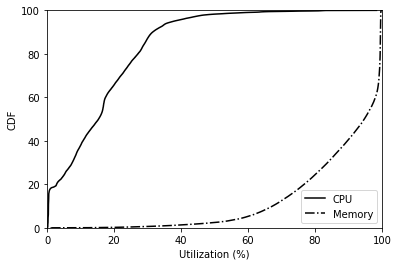

In [19]:
x, y = get_cdf(cpu_util)
plt.plot(x, y, label='CPU', color='black', linestyle='-')
x, y = get_cdf(mem_util)
plt.plot(x, y, label='Memory', color='black', linestyle='-.')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.xlabel('Utilization (%)')
plt.ylabel('CDF')
plt.show()